In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN-AD")

In [2]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import os
import scipy.stats as ss
from scipy import signal
from tqdm import tqdm
import pickle
import seaborn as sns
import numbers
import scipy
import pandas as pd
%matplotlib inline

In [3]:
import importlib
import pyTVDN.utils
importlib.reload(pyTVDN.utils)
from pyTVDN.utils import load_pkl

In [4]:
regionNamesRaw  ="""
ctx-lh-bankssts
ctx-lh-caudalanteriorcingulate
ctx-lh-caudalmiddlefrontal
ctx-lh-cuneus
ctx-lh-entorhinal
ctx-lh-frontalpole
ctx-lh-fusiform
ctx-lh-inferiorparietal
ctx-lh-inferiortemporal
ctx-lh-insula
ctx-lh-isthmuscingulate
ctx-lh-lateraloccipital
ctx-lh-lateralorbitofrontal
ctx-lh-lingual
ctx-lh-medialorbitofrontal
ctx-lh-middletemporal
ctx-lh-paracentral
ctx-lh-parahippocampal
ctx-lh-parsopercularis
ctx-lh-parsorbitalis
ctx-lh-parstriangularis
ctx-lh-pericalcarine
ctx-lh-postcentral
ctx-lh-posteriorcingulate
ctx-lh-precentral
ctx-lh-precuneus
ctx-lh-rostralanteriorcingulate
ctx-lh-rostralmiddlefrontal
ctx-lh-superiorfrontal
ctx-lh-superiorparietal
ctx-lh-superiortemporal
ctx-lh-supramarginal
ctx-lh-temporalpole
ctx-lh-transversetemporal
ctx-rh-bankssts
ctx-rh-caudalanteriorcingulate
ctx-rh-caudalmiddlefrontal
ctx-rh-cuneus
ctx-rh-entorhinal
ctx-rh-frontalpole
ctx-rh-fusiform
ctx-rh-inferiorparietal
ctx-rh-inferiortemporal
ctx-rh-insula
ctx-rh-isthmuscingulate
ctx-rh-lateraloccipital
ctx-rh-lateralorbitofrontal
ctx-rh-lingual
ctx-rh-medialorbitofrontal
ctx-rh-middletemporal
ctx-rh-paracentral
ctx-rh-parahippocampal
ctx-rh-parsopercularis
ctx-rh-parsorbitalis
ctx-rh-parstriangularis
ctx-rh-pericalcarine
ctx-rh-postcentral
ctx-rh-posteriorcingulate
ctx-rh-precentral
ctx-rh-precuneus
ctx-rh-rostralanteriorcingulate
ctx-rh-rostralmiddlefrontal
ctx-rh-superiorfrontal
ctx-rh-superiorparietal
ctx-rh-superiortemporal
ctx-rh-supramarginal
ctx-rh-temporalpole
ctx-rh-transversetemporal
"""
regionNames = [i.strip()[4].title() + i.strip()[6:].title() for i in regionNamesRaw.split("\n") if len(i.strip())>0]

In [5]:
os.chdir("/home/huaqingj/MyResearch/TVDN-AD/")
resDir = Path("./results")
dataDir = Path("./data")

## Summary of the Patients (I am not using it)

in file `Select Data.ipynb`

In [73]:
from scipy.stats import chi2_contingency

In [693]:
ADSum = pd.read_csv("./OtherFils/ADcomplete.csv").loc[:87, :]
CtrlSum = pd.read_excel("./OtherFils/Ctrlcomplete.xlsx")
# Rm part of data to balance
ADSum = ADSum[ADSum["MEG_Age"]>=56]
CtrlSum = CtrlSum[CtrlSum["MEG_Age"]<=80]

In [694]:
charaNames = ["Gender", "Handedness", "Race", "Education", "MEG_Age", "MMSE"]

In [697]:
curChara = "Gender"
grpLabs = np.array(["AD"] * len(ADSum) + ["Ctrl"] * len(CtrlSum))
vls = list(ADSum[curChara]) + list(CtrlSum[curChara])
vls = np.array([ix.lower() for ix in vls])
cTb = np.array(pd.crosstab(vls, grpLabs))
chi2, pv, _, _ = chi2_contingency(cTb)
pStr = f"The chisq stat is {chi2:.3f}, the pvalue of the test is {pv:.3f}."
print(pStr)
print(pd.crosstab(vls, grpLabs, normalize="columns"))
print(pd.crosstab(vls, grpLabs, normalize=False))

The chisq stat is 0.002, the pvalue of the test is 0.964.
col_0      AD   Ctrl
row_0               
female  0.631  0.619
male    0.369  0.381
col_0   AD  Ctrl
row_0           
female  41    39
male    24    24


In [698]:
curChara = "Handedness"
grpLabs = np.array(["AD"] * len(ADSum) + ["Ctrl"] * len(CtrlSum))
vls = list(ADSum[curChara]) + list(CtrlSum[curChara])
vls = np.array(vls)
cTb = np.array(pd.crosstab(vls, grpLabs))
# remove the NAN
chi2, pv, _, _ = chi2_contingency(cTb[:2, :])
pStr = f"The chisq stat is {chi2:.3f}, the pvalue of the test is {pv:.3f}."
print(pStr)
print(pd.crosstab(vls, grpLabs, normalize="columns"))
print(pd.crosstab(vls, grpLabs, normalize=False))

The chisq stat is 2.508, the pvalue of the test is 0.113.
col_0     AD   Ctrl
row_0              
LEFT   0.092  0.238
RIGHT  0.738  0.746
nan    0.169  0.016
col_0  AD  Ctrl
row_0          
LEFT    6    15
RIGHT  48    47
nan    11     1


In [699]:
curChara = "Race"
grpLabs = np.array(["AD"] * len(ADSum) + ["Ctrl"] * len(CtrlSum))
vls = list(ADSum[curChara]) + list(CtrlSum[curChara])
vls = np.array(vls)
vls = np.array([ix.lower() for ix in vls ])
tVls = []
for vl in vls:
    if vl == "white":
        tVls.append(vl)
    elif vl != "nan":
        tVls.append("others")
    else:
        tVls.append(vl)
vls = np.array(tVls)    
cTb = np.array(pd.crosstab(vls, grpLabs))
# remove the nan
chi2, pv, _, _ = chi2_contingency(cTb[1:, :])
pStr = f"The chisq stat is {chi2:.3f}, the pvalue of the test is {pv:.3f}."
print(pStr)
print(pd.crosstab(vls, grpLabs, normalize="columns"))
print(pd.crosstab(vls, grpLabs, normalize=False))

The chisq stat is 2.562, the pvalue of the test is 0.109.
col_0      AD   Ctrl
row_0               
nan     0.031  0.032
others  0.015  0.095
white   0.954  0.873
col_0   AD  Ctrl
row_0           
nan      2     2
others   1     6
white   62    55


In [700]:
curChara = "MEG_Age"
grpLabs = np.array(["AD"] * len(ADSum) + ["Ctrl"] * len(CtrlSum))
vls = list(ADSum[curChara]) + list(CtrlSum[curChara])
ttRes = scipy.stats.ttest_ind(ADSum[curChara], CtrlSum[curChara])
ttRes.pvalue

0.09675846636477846

In [701]:
curChara = "Education"
grpLabs = np.array(["AD"] * len(ADSum) + ["Ctrl"] * len(CtrlSum))
vls = list(ADSum[curChara]) + list(CtrlSum[curChara])
ADdat = ADSum[curChara][~np.isnan(np.array(ADSum[curChara]))]
Ctrldat = CtrlSum[curChara][~np.isnan(np.array(CtrlSum[curChara]))]
ttRes = scipy.stats.ttest_ind(ADdat, Ctrldat)
ttRes.pvalue

0.007400603828966532

In [702]:
curChara = "MMSE"
grpLabs = np.array(["AD"] * len(ADSum) + ["Ctrl"] * len(CtrlSum))
vls = list(ADSum[curChara]) + list(CtrlSum[curChara])
ADdat = ADSum[curChara][~np.isnan(np.array(ADSum[curChara]))]
Ctrldat = CtrlSum[curChara][~np.isnan(np.array(CtrlSum[curChara]))]
ttRes = scipy.stats.ttest_ind(ADdat, Ctrldat)
ttRes.pvalue

1.1011929676237257e-16

In [705]:
AllSum = ADSum[charaNames].append(CtrlSum[charaNames], ignore_index=True)
AllSum = AllSum.assign(Grp=["AD"]*len(ADSum)+["Ctrl"]*len(CtrlSum))

In [764]:
AllSum.corr()

Education  MEG_Age   MMSE
Education      1.000    0.148  0.305
MEG_Age        0.148    1.000  0.176
MMSE           0.305    0.176  1.000

In [760]:
AllSum.groupby("Grp").describe()

Education                                               MEG_Age          \
         count    mean    std   min   25%   50%    75%   max   count    mean   
Grp                                                                            
AD        63.0  16.381  2.599  11.0  14.0  16.0  18.00  24.0    65.0  66.117   
Ctrl      62.0  17.484  1.862  14.0  16.0  18.0  18.75  20.0    63.0  68.284   

      ...                  MMSE                                                
      ...     75%     max count    mean    std   min    25%   50%   75%   max  
Grp   ...                                                                      
AD    ...  72.100  84.300  64.0  22.188  5.976   3.0  17.75  23.0  28.0  30.0  
Ctrl  ...  74.357  79.581  63.0  29.492  0.878  25.0  29.00  30.0  30.0  30.0  

[2 rows x 24 columns]

In [706]:
AllSum[["MEG_Age", "Grp"]].groupby("Grp").describe()

MEG_Age                                                      
       count    mean    std     min    25%     50%     75%     max
Grp                                                               
AD      65.0  66.117  7.508  56.800  59.90  64.400  72.100  84.300
Ctrl    63.0  68.284  7.130  52.536  63.33  69.073  74.357  79.581

### Reg with MMSE on Edu and Age

In [765]:
import statsmodels.api as sm
blX = np.array(AllSum[["Education", "MEG_Age"]])
# impute the nan
blX[np.isnan(blX)] = np.array([16.381, 16.381, 17.484])
stdBlX = (blX - blX.mean(axis=0))/blX.std(axis=0)
stdBlX = np.concatenate([stdBlX, stdXs], axis=1)
stdBlX = sm.add_constant(stdBlX)
tmYs = np.array(AllSum["MMSE"])
tmYs[np.isnan(tmYs)] = np.array([22.188])
model = sm.OLS(tmYs, stdBlX)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     2.344
Date:                Sat, 02 Apr 2022   Prob (F-statistic):           0.000615
Time:                        23:55:59   Log-Likelihood:                -312.18
No. Observations:                 128   AIC:                             770.4
Df Residuals:                      55   BIC:                             978.6
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.7827      0.374     68.951      0.0

In [771]:
stdEdu = stdBlX[:, 1]

### The keep index

In [787]:

RID_AD_labs = loadmat("./OtherFils/radid_AD.mat")["radid"].reshape(-1)
ADlabs = [lab[0].split("A")[0] for lab in RID_AD_labs] 
RID_Ctrl_labs = loadmat("./OtherFils/radid_control.mat")["radid"].reshape(-1)
Ctrllabs = [lab[0].split("A")[0] for lab in RID_Ctrl_labs] 

kpAD = []
for ADlab in ADlabs:
    kpAD.append(np.sum(ADSum["RID"] == ADlab))
kpAD = np.array(kpAD)
kpCtrl = []
for Ctrllab in Ctrllabs:
    kpCtrl.append(np.sum(CtrlSum["RID"] == Ctrllab))
kpCtrl = np.array(kpCtrl)

kpAll = np.concatenate([kpAD, kpCtrl])

In [743]:
with open("./OtherFils/KpIdxs.pkl", "wb") as sf:
    pickle.dump([kpAD, kpCtrl, kpAll], sf)

### Propensity score and weighting (Not use it)

because they dislike weighting

In [493]:
from sklearn.linear_model import LogisticRegression

In [627]:
#selCols = ["MEG_Age"]
selCols = ["Education", "MEG_Age"]
blX = np.concatenate([np.array(ADSum[selCols]), np.array(CtrlSum[selCols])])
# impute the nan
blX[np.isnan(blX)] = np.array([16.326, 16.326, 17.435])
As = np.concatenate([np.ones(88), np.zeros(70)])
stdBlX = (blX - blX.mean(axis=0))/blX.std(axis=0)

In [628]:
PSfit = LogisticRegression(penalty="none", random_state=0, solver="newton-cg")
PSfit.fit(stdBlX, As)
probs = PSfit.predict_proba(stdBlX)
PSs = [prob[int(ix)] for ix, prob in zip(As, probs)]

In [629]:
PIDs = np.concatenate([np.array(ADSum["PID"]), np.array(CtrlSum["PID"])])
RIDs = np.concatenate([np.array(ADSum["RID"]), np.array(CtrlSum["RID"])])
dfSave = pd.DataFrame({
    "PID":PIDs, 
    "RID":RIDs, 
    "PS":PSs, 
    "Group":As
})

In [630]:
dfSave.to_csv("./OtherFils/PSs.csv", index=False)

#### Get ws with correct ordering

In [631]:
RID_AD_labs = loadmat("./OtherFils/radid_AD.mat")["radid"].reshape(-1)
ADlabs = [lab[0].split("A")[0] for lab in RID_AD_labs] 
RID_Ctrl_labs = loadmat("./OtherFils/radid_control.mat")["radid"].reshape(-1)
Ctrllabs = [lab[0].split("A")[0] for lab in RID_Ctrl_labs] 

wsAD = []
for ADlab in ADlabs:
    w = (88/158)/np.array(dfSave[dfSave["RID"] == ADlab]["PS"])[0]
    wsAD.append(w)
wsAD = np.array(wsAD)
    
wsCtrl = []
for Ctrllab in Ctrllabs:
    w = (70/158)/np.array(dfSave[dfSave["RID"] == Ctrllab]["PS"])[0]
    wsCtrl.append(w)
wsCtrl = np.array(wsCtrl)
    
wsAll = np.concatenate([wsAD, wsCtrl])

## Load features

### Load data

In [6]:
with open("./OtherFils/KpIdxsAll.pkl", "rb") as sf:
    kpAD, kpCtrl, kpAll = pickle.load(sf)

In [7]:
# ecpts
fil = list(resDir.glob("AD_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssCtrl = pickle.load(f)

In [8]:
# Eigvals
fil = list(resDir.glob("AD_*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsCtrl = pickle.load(f)

In [9]:
fil = list(resDir.glob("AD_*_eigVecs.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_eigVecs.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsCtrl = pickle.load(f)

In [10]:
# Sel data (only need when use sub data)
ecptssAD = [ ecptsAD for ecptsAD, kpix in zip(ecptssAD, kpAD) if kpix==1]
ecptssCtrl = [ ecptsCtrl for ecptsCtrl, kpix in zip(ecptssCtrl, kpCtrl) if kpix==1]
eigValsAD = [ v for v, kpix in zip(eigValsAD, kpAD) if kpix==1]
eigValsCtrl = [ v for v, kpix in zip(eigValsCtrl, kpCtrl) if kpix==1]
eigVecsAD = [ v for v, kpix in zip(eigVecsAD, kpAD) if kpix==1]
eigVecsCtrl = [ v for v, kpix in zip(eigVecsCtrl, kpCtrl) if kpix==1]

In [11]:
# graph metrics from TVDN
graph_fs_AD = load_pkl(resDir/"graphic_fs_AD.pkl")
graph_fs_Ctrl = load_pkl(resDir/"graphic_fs_Ctrl.pkl")

In [12]:
def minmax2(x):
    num = 2 * (x-np.min(x))
    den = np.max(x) - np.min(x)
    return num/den - 1

In [13]:
### The canonical networks
def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den

fcR = pd.read_csv('./OtherFils/DK_dic68.csv').set_index('Unnamed: 0')
rowNames = list(fcR.index)
colNames = np.array(fcR.columns)

fcRarr = np.array(fcR)

# minmax 
fcRarrMM = np.zeros_like(fcRarr)
for i, fcRar in enumerate(fcRarr):
    # lh = minmax(fcRar[:34])
    # rh = minmax(fcRar[34:])
    # fcRarrMM[i, :34] = lh
    # fcRarrMM[i, 34:] = rh
    fcRarrMM[i, :] = minmax(fcRar)

In [14]:
# calculat the topk mean of graphic feature based on dwell time
def topk_mean(topk, graphic_f, dwell, key):
    idxs = np.argsort(-dwell)[:topk]
    sel_graphic_f = np.array([graphic_f[idx][key] for idx in idxs])
    mean_v = np.mean(sel_graphic_f)
    return mean_v

In [15]:
def halfMinmax(x):
    lpMM = minmax(x[:34])
    rpMM = minmax(x[34:])
    res = np.concatenate([lpMM, rpMM])
    return res

### The basic data transformation 

In [24]:
def rmRepFn(eigVal):
    firstCol = np.array([[True] * np.array(eigVal).shape[0]]).T
    otherCols = np.diff(np.abs(eigVal), 1)!=0
    tmpKpIdx = np.concatenate([firstCol, otherCols], axis=1)
    rmEigVals = np.array(eigVal)[:, tmpKpIdx[0, :]]
    return rmEigVals

In [25]:
# Dwell times in second
freq = 120
dwellsAD = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssAD]
dwellsCtrl = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssCtrl]

In [26]:
ecptss = ecptssAD
dwells = dwellsAD
eigVals = eigValsAD
eigVecs = eigVecsAD
graph_fs = graph_fs_AD

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.dwell = dwell 
    fs.ncpts = len(ecptss[i])
    fs.meanDwell = np.mean(dwell)
    fs.maxDwell = np.max(dwell)
    fs.minDwell = np.min(dwell)
    
    eigVal = eigVals[i]
    
    fs.eigVal = eigVal
    fs.absEigValMean = np.abs(eigVal).mean()
    fs.absImagEigValMean = np.abs(np.array(eigVal).imag).mean()
    fs.absMaxEigValMean = np.abs(eigVal).max(axis=1).mean()
    idx = np.argmax(dwell)
    if fs.ncpts >=1:
        idx2 = np.where((-dwell).argsort().argsort()==1)[0][0]
    
    maxEigVal = eigVal[idx]
    fs.maxEigVal = maxEigVal[np.argmax(np.abs(maxEigVal))]
    fs.maxEigValMode = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))])
    fs.maxEigValReal = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].real)
    fs.maxEigValImag = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].imag)
    
    
    tmp = maxEigVal.copy()
    tmp[np.abs(maxEigVal) == np.max(np.abs(maxEigVal))] = 0
    fs.max2EigVal = tmp[np.argmax(np.abs(tmp))]
    fs.max2EigValMode = np.abs(tmp[np.argmax(np.abs(tmp))])
    fs.max2EigValReal = np.abs(tmp[np.argmax(np.abs(tmp))].real)
    fs.max2EigValImag = np.abs(tmp[np.argmax(np.abs(tmp))].imag)
    
    fs.maxwU = np.abs(np.matmul(eigVecs[i], maxEigVal))
    fs.wUAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real)
    fs.wUAllMM = (fs.wUAll - fs.wUAll.min(axis=0))/(fs.wUAll.max(axis=0)-fs.wUAll.min(axis=0))
    fs.wUAllMMmean = fs.wUAllMM.mean(axis=1)
    fs.wUsumAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).sum(axis=1)
    fs.wUmeanAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).mean(axis=1)
    fs.maxwUraw = np.matmul(eigVecs[i], maxEigVal).real
    fs.maxwUnorm = np.linalg.norm(fs.maxwU)
    
    fs.wUcorrsAll = []
    for jx in range(fs.wUAll.shape[1]):
        curwU = fs.wUAll[:, jx]
        curwUMM = np.zeros_like(curwU)
        # curwUMM[:34] = minmax(curwU[:34])
        # curwUMM[34:] = minmax(curwU[34:])
        curwUMM[:] = minmax(curwU[:])
        curwUcorrs = []
        for ix in range(fcRarrMM.shape[0]):
            fcRarrMMcur = fcRarrMM[ix, :]
            curwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], curwUMM)[0])
        fs.wUcorrsAll.append(curwUcorrs)
    
    wUmeanMM = np.zeros_like(fs.wUmeanAll)
    # wUmeanMM[:34] = minmax(fs.wUmeanAll[:34])
    # wUmeanMM[34:] = minmax(fs.wUmeanAll[34:])
    wUmeanMM[:] = minmax(fs.wUmeanAll[:])
    fs.wUmeancorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.wUmeancorrs.append(ss.pearsonr(fcRarrMM[ix, :], wUmeanMM)[0])
    
    maxwUMM = np.zeros_like(fs.maxwU)
    #maxwUMM[:34] = minmax(fs.maxwU[:34])
    #maxwUMM[34:] = minmax(fs.maxwU[34:])
    maxwUMM[:] = minmax(fs.maxwU[:])
    fs.maxwUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxwUMM)[0])
        
    if fs.ncpts >=1:
        fs.maxwU2 = np.abs(np.matmul(eigVecs[i], eigVal[idx2]))
        fs.maxwU2norm = np.linalg.norm(fs.maxwU2)
    else:
        fs.maxwU2 = np.zeros(fs.maxwU.shape)
        fs.maxwU2norm = 0
    
    fs.maxU = eigVecs[i][:, np.argmax(np.abs(maxEigVal))]
    fs.maxUnorm = np.linalg.norm(fs.maxU)
    fs.maxUMode = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))])
    fs.maxUReal = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].real)
    fs.maxUImag = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].imag)
    maxUMM = np.zeros_like(fs.maxUMode)
    #maxUMM[:34] = minmax(fs.maxUMode[:34])
    #maxUMM[34:] = minmax(fs.maxUMode[34:])
    maxUMM[:] = minmax(fs.maxUMode[:])
    fs.maxUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxUMM)[0])
    
    fs.r  = len(maxEigVal)
    
    # graph metric
    graph_f = graph_fs[i]
    fs["top1_Q"] = topk_mean(1, graph_f, dwell, "tQ")
    fs["top1_C"] = topk_mean(1, graph_f, dwell, "tmC")
    fs["top1_L"] = topk_mean(1, graph_f, dwell, "tmL")
    fs["var_Q"] = np.var([v["tQ"] for v in graph_f])
    fs["var_C"] = np.var([v["tmC"] for v in graph_f])
    fs["var_L"] = np.var([v["tmL"] for v in graph_f])
    
    fsAll.append(fs)
    
fsAD = fsAll    

In [27]:
ecptss = ecptssCtrl
dwells = dwellsCtrl
eigVals = eigValsCtrl
eigVecs = eigVecsCtrl
graph_fs = graph_fs_Ctrl

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.dwell = dwell 
    fs.ncpts = len(ecptss[i])
    fs.meanDwell = np.mean(dwell)
    fs.maxDwell = np.max(dwell)
    fs.minDwell = np.min(dwell)
    
    eigVal = eigVals[i]
    
    fs.eigVal = eigVal
    fs.absEigValMean = np.abs(eigVal).mean()
    fs.absImagEigValMean = np.abs(np.array(eigVal).imag).mean()
    fs.absMaxEigValMean = np.abs(eigVal).max(axis=1).mean()
    idx = np.argmax(dwell)
    if fs.ncpts >=1:
        idx2 = np.where((-dwell).argsort().argsort()==1)[0][0]
    
    maxEigVal = eigVal[idx]
    fs.maxEigVal = maxEigVal[np.argmax(np.abs(maxEigVal))]
    fs.maxEigValMode = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))])
    fs.maxEigValReal = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].real)
    fs.maxEigValImag = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].imag)
    
    
    tmp = maxEigVal.copy()
    tmp[np.abs(maxEigVal) == np.max(np.abs(maxEigVal))] = 0
    fs.max2EigVal = tmp[np.argmax(np.abs(tmp))]
    fs.max2EigValMode = np.abs(tmp[np.argmax(np.abs(tmp))])
    fs.max2EigValReal = np.abs(tmp[np.argmax(np.abs(tmp))].real)
    fs.max2EigValImag = np.abs(tmp[np.argmax(np.abs(tmp))].imag)
    
    fs.maxwU = np.abs(np.matmul(eigVecs[i], maxEigVal))
    fs.wUAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real)
    fs.wUAllMM = (fs.wUAll - fs.wUAll.min(axis=0))/(fs.wUAll.max(axis=0)-fs.wUAll.min(axis=0))
    fs.wUAllMMmean = fs.wUAllMM.mean(axis=1)
    fs.wUsumAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).sum(axis=1)
    fs.wUmeanAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).mean(axis=1)
    fs.maxwUraw = np.matmul(eigVecs[i], maxEigVal).real
    fs.maxwUnorm = np.linalg.norm(fs.maxwU)
    
    fs.wUcorrsAll = []
    for jx in range(fs.wUAll.shape[1]):
        curwU = fs.wUAll[:, jx]
        curwUMM = np.zeros_like(curwU)
        # curwUMM[:34] = minmax(curwU[:34])
        # curwUMM[34:] = minmax(curwU[34:])
        curwUMM[:] = minmax(curwU[:])
        curwUcorrs = []
        for ix in range(fcRarrMM.shape[0]):
            fcRarrMMcur = fcRarrMM[ix, :]
            curwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], curwUMM)[0])
        fs.wUcorrsAll.append(curwUcorrs)
    
    wUmeanMM = np.zeros_like(fs.wUmeanAll)
    # wUmeanMM[:34] = minmax(fs.wUmeanAll[:34])
    # wUmeanMM[34:] = minmax(fs.wUmeanAll[34:])
    wUmeanMM[:] = minmax(fs.wUmeanAll[:])
    fs.wUmeancorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.wUmeancorrs.append(ss.pearsonr(fcRarrMM[ix, :], wUmeanMM)[0])
    
    maxwUMM = np.zeros_like(fs.maxwU)
    #maxwUMM[:34] = minmax(fs.maxwU[:34])
    #maxwUMM[34:] = minmax(fs.maxwU[34:])
    maxwUMM[:] = minmax(fs.maxwU[:])
    fs.maxwUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxwUMM)[0])
        
    if fs.ncpts >=1:
        fs.maxwU2 = np.abs(np.matmul(eigVecs[i], eigVal[idx2]))
        fs.maxwU2norm = np.linalg.norm(fs.maxwU2)
    else:
        fs.maxwU2 = np.zeros(fs.maxwU.shape)
        fs.maxwU2norm = 0
    
    fs.maxU = eigVecs[i][:, np.argmax(np.abs(maxEigVal))]
    fs.maxUnorm = np.linalg.norm(fs.maxU)
    fs.maxUMode = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))])
    fs.maxUReal = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].real)
    fs.maxUImag = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].imag)
    maxUMM = np.zeros_like(fs.maxUMode)
    #maxUMM[:34] = minmax(fs.maxUMode[:34])
    #maxUMM[34:] = minmax(fs.maxUMode[34:])
    maxUMM[:] = minmax(fs.maxUMode[:])
    fs.maxUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxUMM)[0])
    
    fs.r  = len(maxEigVal)
    
    # graph metric
    graph_f = graph_fs[i]
    fs["top1_Q"] = topk_mean(1, graph_f, dwell, "tQ")
    fs["top1_C"] = topk_mean(1, graph_f, dwell, "tmC")
    fs["top1_L"] = topk_mean(1, graph_f, dwell, "tmL")
    fs["var_Q"] = np.var([v["tQ"] for v in graph_f])
    fs["var_C"] = np.var([v["tmC"] for v in graph_f])
    fs["var_L"] = np.var([v["tmL"] for v in graph_f])
    
    
    fsAll.append(fs)
    
fsCtrl = fsAll    

### Save the feature for brain plot

In [24]:
def U2BrainVec(wU):
    emVec = np.zeros_like(DKtmplate, dtype=np.float64)
    for idx in range(1, 69):
        emVec[DKtmplate==idx] = wU[idx-1]
    return emVec

def reorderU(wU):
    wUreorder = np.zeros_like(wU, dtype=np.float64)
    wUreorder[0::2] = wU[:34]
    wUreorder[1::2] = wU[34:]
    return wUreorder

In [25]:
# This function is to discretize the vec
def discretVec(Vec, ps=[0, 0.25, 0.5, 0.75, 1]):
    qs = np.quantile(Vec, ps)
    disVec = Vec 
    for ix in range(len(qs)-1):
        low = qs[ix]
        up = qs[ix+1]
        idxVec= np.bitwise_and(Vec >= low, Vec <up)
        disVec[idxVec] = np.mean(Vec[idxVec])
    return disVec

In [20]:
with open("./OtherFils/BNVtemplate_DK68.txt", "r") as tf:
    DKtmplateRaw = tf.readlines()
DKtmplate = np.array([int(x.strip()) for x in DKtmplateRaw])

In [19]:
# mean of  wUmean
fName = "wUmeanAll"
mFAD = np.array([fs[fName] for fs in fsAD]).mean(axis=0)
mFCtrl = np.array([fs[fName] for fs in fsCtrl]).mean(axis=0)
mFAD = minmax(mFAD)
mFCtrl = minmax(mFCtrl)
outAD = U2BrainVec(reorderU(mFAD))
outCtrl = U2BrainVec(reorderU(mFCtrl))
np.savetxt("./brainPlotFils/wUmeanAD.txt", outAD)
np.savetxt("./brainPlotFils/wUmeanCtrl.txt", outCtrl)
pd.DataFrame({"Name": regionNames, "Vec": mFAD}).to_csv("./brainPlotFils/wUmeanAD.csv", index=False)
pd.DataFrame({"Name": regionNames, "Vec": mFCtrl}).to_csv("./brainPlotFils/wUmeanCtrl.csv", index=False)

In [279]:
# mean of  wUmean, half minmax
fName = "wUmeanAll"
mFAD = np.array([fs[fName] for fs in fsAD]).mean(axis=0)
mFCtrl = np.array([fs[fName] for fs in fsCtrl]).mean(axis=0)
mFAD = halfMinmax(mFAD)
mFCtrl = halfMinmax(mFCtrl)
outAD = U2BrainVec(reorderU(mFAD))
outCtrl = U2BrainVec(reorderU(mFCtrl))
np.savetxt("./brainPlotFils/wUmeanADHalf.txt", outAD)
np.savetxt("./brainPlotFils/wUmeanCtrlHalf.txt", outCtrl)
pd.DataFrame({"Name": regionNames, "Vec": mFAD}).to_csv("./brainPlotFils/wUmeanADHalf.csv", index=False)
pd.DataFrame({"Name": regionNames, "Vec": mFCtrl}).to_csv("./brainPlotFils/wUmeanCtrlHalf.csv", index=False)

In [16]:
# mean of  maximal wU
fName = "maxwU"
mFAD = np.array([fs[fName] for fs in fsAD]).mean(axis=0)
mFCtrl = np.array([fs[fName] for fs in fsCtrl]).mean(axis=0)
mFAD = minmax(mFAD)
mFCtrl = minmax(mFCtrl)
outAD = U2BrainVec(reorderU(mFAD))
outCtrl = U2BrainVec(reorderU(mFCtrl))
np.savetxt(f"./brainPlotFils/{fName}AD.txt", outAD)
np.savetxt(f"./brainPlotFils/{fName}Ctrl.txt", outCtrl)
pd.DataFrame({"Name": regionNames, "Vec": mFAD}).to_csv(f"./brainPlotFils/{fName}AD.csv", index=False)
pd.DataFrame({"Name": regionNames, "Vec": mFCtrl}).to_csv(f"./brainPlotFils/{fName}Ctrl.csv", index=False)

In [17]:
# mean of  the U corresponding to maximal eigval
fName = "maxUMode"
mFAD = np.array([fs[fName] for fs in fsAD]).mean(axis=0)
mFCtrl = np.array([fs[fName] for fs in fsCtrl]).mean(axis=0)
mFAD = minmax(mFAD)
mFCtrl = minmax(mFCtrl)
outAD = U2BrainVec(reorderU(mFAD))
outCtrl = U2BrainVec(reorderU(mFCtrl))
np.savetxt(f"./brainPlotFils/{fName}AD.txt", outAD)
np.savetxt(f"./brainPlotFils/{fName}Ctrl.txt", outCtrl)
pd.DataFrame({"Name": regionNames, "Vec": mFAD}).to_csv(f"./brainPlotFils/{fName}AD.csv", index=False)
pd.DataFrame({"Name": regionNames, "Vec": mFCtrl}).to_csv(f"./brainPlotFils/{fName}Ctrl.csv", index=False)

#### We do not need these code now

In [665]:
nDis = 8
fName = "wUmeanAll"
mFAD = np.array([fs[fName] for fs in fsAD]).mean(axis=0)
mFCtrl = np.array([fs[fName] for fs in fsCtrl]).mean(axis=0)
disMFAD = discretVec(mFAD, np.linspace(0, 1, nDis+1))
disMFCtrl = discretVec(mFCtrl, np.linspace(0, 1, nDis+1))
mFAD = minmax(disMFAD)
mFCtrl = minmax(disMFCtrl)
outAD = U2BrainVec(reorderU(mFAD))
outCtrl = U2BrainVec(reorderU(mFCtrl))
np.savetxt(f"./brainPlotFils/wUmeanAD_{nDis}.txt", outAD)
np.savetxt(f"./brainPlotFils/wUmeanCtrl_{nDis}.txt", outCtrl)
pd.DataFrame({"Name": regionNames, "Vec": mFAD}).to_csv(f"./brainPlotFils/wUmeanAD_{nDis}.csv", index=False)
pd.DataFrame({"Name": regionNames, "Vec": mFCtrl}).to_csv(f"./brainPlotFils/wUmeanCtrl_{nDis}.csv", index=False)

In [17]:
# mean of  wUsum
fName = "wUsumAll"
mFAD = np.array([fs[fName] for fs in fsAD]).mean(axis=0)
mFCtrl = np.array([fs[fName] for fs in fsCtrl]).mean(axis=0)
mFAD = minmax(mFAD)
mFCtrl = minmax(mFCtrl)
outAD = U2BrainVec(reorderU(mFAD))
outCtrl = U2BrainVec(reorderU(mFCtrl))
np.savetxt("./brainPlotFils/wUsumAD.txt", outAD)
np.savetxt("./brainPlotFils/wUsumCtrl.txt", outCtrl)

In [18]:
# mean of  wU1
fName = "maxwU"
mFAD = np.array([fs[fName] for fs in fsAD]).mean(axis=0)
mFCtrl = np.array([fs[fName] for fs in fsCtrl]).mean(axis=0)
mFAD = minmax(mFAD)
mFCtrl = minmax(mFCtrl)
outAD = U2BrainVec(reorderU(mFAD))
outCtrl = U2BrainVec(reorderU(mFCtrl))
np.savetxt("./brainPlotFils/wU1AD.txt", outAD)
np.savetxt("./brainPlotFils/wU1Ctrl.txt", outCtrl)

## Basic analysis

In [18]:
from prettytable import PrettyTable as pTB
from scipy.stats import f as fDist
from statsmodels.stats.weightstats import ttest_ind

/home/huaqingj/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Some basic plots

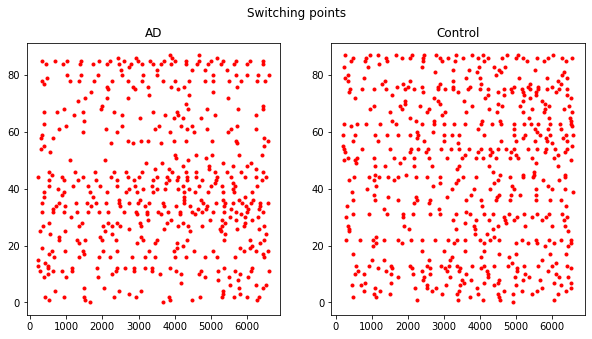

In [85]:
plt.figure(figsize=[10, 5])
plt.suptitle("Switching points")
plt.subplot(121)
for idx, ecpts in enumerate(ecptssAD):
    plt.plot(ecpts, [idx]*len(ecpts), ".r")
plt.title("AD")

plt.subplot(122)
for idx, ecpts in enumerate(ecptssCtrl):
    plt.plot(ecpts, [idx]*len(ecpts), ".r")
plt.title("Control")
plt.savefig("./plots/switching_pts.jpg", bbox_inches='tight')

#### Dynamic properties (eigvals)

In [55]:
eig_seg_abs_mean = lambda eig_val: np.abs(eig_val).mean(axis=-1)
cur_fn = eig_seg_abs_mean

In [59]:
def get_eig_val_trans_curve(ecpts, eig_val):
    ecpts_full = np.concatenate([[0], ecpts, [7200]])
    eig_val_trans_vec = np.zeros(7200)
    for ix in range(len(ecpts_full)-1):
        low_idx, up_idx = ecpts_full[ix:(ix+2)].astype(int)
        eig_val_trans_vec[low_idx:up_idx] = cur_fn(eig_val)[ix]
    return eig_val_trans_vec

In [65]:
eig_val_trans_curves_AD = [get_eig_val_trans_curve(ecptssAD[ix], fsAD[ix].eigVal) for ix in range(len(fsAD))]
eig_val_trans_curves_Ctrl = [get_eig_val_trans_curve(ecptssCtrl[ix], fsCtrl[ix].eigVal) for ix in range(len(fsCtrl))]
eig_val_trans_curves_AD = np.array(eig_val_trans_curves_AD)
eig_val_trans_curves_Ctrl = np.array(eig_val_trans_curves_Ctrl)

In [137]:
def get_win_std(vec, win_size, step):
    vec = np.array(vec)
    cur_flag = 0
    win_std_vec = []
    while cur_flag <= (len(vec)-win_size):
        win_std_vec.append(vec[cur_flag:(cur_flag+win_size)].std())
        cur_flag += step 
    return np.array(win_std_vec)

##### Calculate STD for each subject (not work)

In [156]:
# 120Hz
win_size = 120
step = 10
eig_val_trans_stds_AD = np.array([get_win_std(ix, win_size, step) for ix in eig_val_trans_curves_AD])
eig_val_trans_stds_Ctrl = np.array([get_win_std(ix, win_size, step) for ix in eig_val_trans_curves_Ctrl])

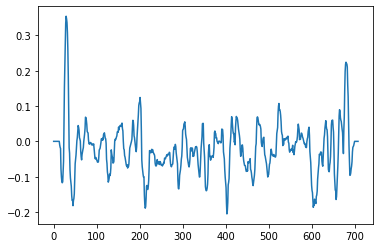

In [163]:
AD_Ctrl_std_diff = eig_val_trans_stds_AD.mean(axis=0) - eig_val_trans_stds_Ctrl.mean(axis=0)
plt.plot(AD_Ctrl_std_diff)

In [165]:
pvals = []
for ix in range(len(AD_Ctrl_std_diff)):
    res = scipy.stats.ttest_ind(eig_val_trans_stds_AD[:, ix], eig_val_trans_stds_Ctrl[:, ix])
    pvals.append(res.pvalue)

In [167]:
np.mean(np.array(pvals)<0.05)

0.06205923836389281

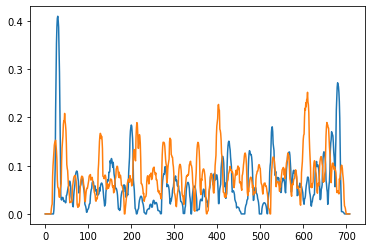

In [151]:
plt.plot(np.array(eig_val_trans_stds_AD).mean(axis=0))
plt.plot(np.array(eig_val_trans_stds_Ctrl).mean(axis=0))

##### Take mean first

In [68]:
eig_val_trans_meancurve_AD = eig_val_trans_curves_AD.mean(axis=0)
eig_val_trans_meancurve_Ctrl = eig_val_trans_curves_Ctrl.mean(axis=0)

In [171]:
std_vec = lambda x: (x-x.mean())/x.std()

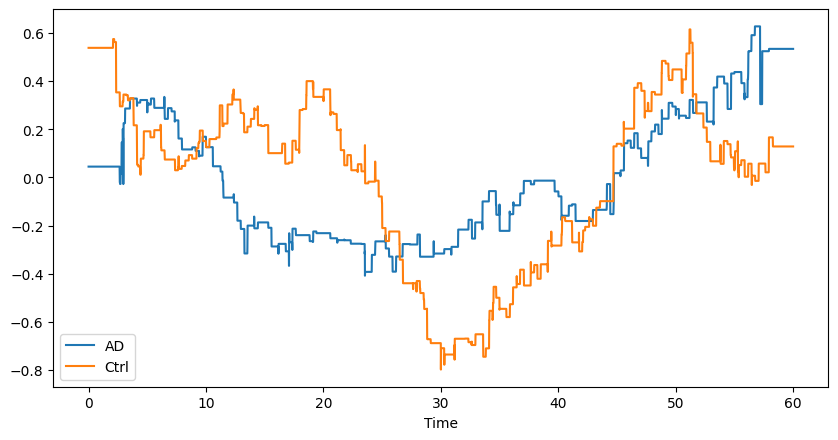

In [175]:
plt.figure(figsize=[10, 5], dpi=100)
times = np.linspace(0, 60, 7200)
plt.plot(times, eig_val_trans_meancurve_AD-eig_val_trans_meancurve_AD.mean(), "-", label="AD")
plt.plot(times, eig_val_trans_meancurve_Ctrl-eig_val_trans_meancurve_Ctrl.mean(), "-", label="Ctrl")
plt.xlabel("Time")
plt.legend()

In [168]:
time_w = 1
time_w_pts = time_w * 120
step = 10
eig_val_trans_std_win_ADs = get_win_std(eig_val_trans_meancurve_AD, win_size=time_w_pts, step=step)
eig_val_trans_std_win_Ctrls = get_win_std(eig_val_trans_meancurve_Ctrl, win_size=time_w_pts, step=step)

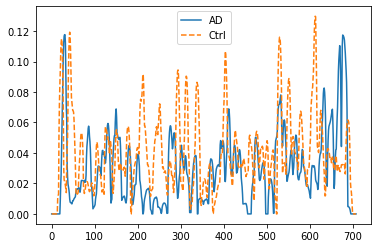

In [169]:
plt.plot(eig_val_trans_std_win_ADs, "-", label="AD")
plt.plot(eig_val_trans_std_win_Ctrls, "--", label="Ctrl")
plt.legend()

#### Temperal varation

In [104]:
wUvarAD = np.array([fAD.wUAll.std(axis=1) for fAD in fsAD])
wUvarCtrl  = np.array([fCtrl.wUAll.std(axis=1) for fCtrl in fsCtrl])
pvs = []
for ix in range(68):
    curAD = wUvarAD[:, ix]
    curCtrl = wUvarCtrl[:, ix]
    curRes = scipy.stats.ttest_ind(curAD, curCtrl)
    pvs.append(curRes.pvalue)

In [108]:
nlogpvs = -np.log(pvs)
outVec = U2BrainVec(reorderU(minmax(nlogpvs)))
np.savetxt("./brainPlotFils/temVarNLogPvs.txt", outVec)
pd.DataFrame({"Name": regionNames, "Vec": minmax(nlogpvs)}).to_csv("./brainPlotFils/temVarNLogPvs.csv", index=False)

In [111]:
outAD = U2BrainVec(reorderU(minmax(wUvarAD.mean(axis=0))))
outCtrl = U2BrainVec(reorderU(minmax(wUvarCtrl.mean(axis=0))))
np.savetxt("./brainPlotFils/temVarMeanAD.txt", outAD)
pd.DataFrame({"Name": regionNames, "Vec":minmax(wUvarAD.mean(axis=0))}).to_csv("./brainPlotFils/temVarMeanAD.csv", index=False)
np.savetxt("./brainPlotFils/temVarMeanCtrl.txt", outCtrl)
pd.DataFrame({"Name": regionNames, "Vec":minmax(wUvarCtrl.mean(axis=0))}).to_csv("./brainPlotFils/temVarMeanCtrl.csv", index=False)

##  Distinguish between AD anc Ctrl

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.cbook as cbook
import statsmodels.api as sm

from sklearn.cluster import KMeans, SpectralClustering
from scipy.stats import fisher_exact, norm
from prettytable import PrettyTable as pTB
from sklearn.metrics import f1_score
from collections import defaultdict as ddict


from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [30]:
def TuningCFn(inpX, inpY, Cs=[0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4], penalty="l2"):
    aucCs = []
    for C in Cs:
        eProbs = []
        loo = LeaveOneOut()
        for trIdxs, testIdxs in loo.split(inpX):
            clf = LogisticRegression(penalty=penalty, random_state=0, C=C)
            clf.fit(inpX[trIdxs, :], inpY[trIdxs])
            eProbs.append(clf.predict_proba(inpX[testIdxs, :]))
        eProbs = np.array(eProbs).squeeze()
        auc = roc_auc_score(inpY, eProbs[:, 1])
        fpr, tpr, thresholds = roc_curve(inpY, eProbs[:, 1], pos_label=1)
        aucCs.append(auc)
            
    optC = Cs[np.argmax(aucCs)]
    res = edict()
    res["optC"] = optC
    res["Cs"] = Cs
    res["aucCs"] = aucCs
    return res

### Logistic under different features

In [31]:
fsAD[0].keys()

dict_keys(['dwell', 'ncpts', 'meanDwell', 'maxDwell', 'minDwell', 'eigVal', 'absEigValMean', 'absImagEigValMean', 'absMaxEigValMean', 'maxEigVal', 'maxEigValMode', 'maxEigValReal', 'maxEigValImag', 'max2EigVal', 'max2EigValMode', 'max2EigValReal', 'max2EigValImag', 'maxwU', 'wUAll', 'wUAllMM', 'wUAllMMmean', 'wUsumAll', 'wUmeanAll', 'maxwUraw', 'maxwUnorm', 'wUcorrsAll', 'wUmeancorrs', 'maxwUcorrs', 'maxwU2', 'maxwU2norm', 'maxU', 'maxUnorm', 'maxUMode', 'maxUReal', 'maxUImag', 'maxUcorrs', 'r', 'top1_Q', 'top1_C', 'top1_L', 'var_Q', 'var_C', 'var_L'])

In [32]:
penalty= "l2"
fsNameSet = [
    #["r"], ["maxwU"], ["ncpts"],  ["wUsumAll"],  ["wUmeanAll"], 
             #["r", "ncpts"],
             #["ncpts", "maxwU"],  ["ncpts", "wUsumAll"],  ["ncpts", "wUmeanAll"], 
             #["r", "maxwU"],  ["r", "wUsumAll"],  
             #["r", "wUmeanAll"], 
             #["r", "ncpts", "maxwU"], 
             #["r", "ncpts", "wUsumAll"],  
             ["r", "ncpts", "wUmeanAll"], 
             ["r", "ncpts", "absEigValMean", "wUmeanAll"], 
             ["r", "ncpts", "absImagEigValMean", "wUmeanAll"], 
             #["r", "ncpts", "maxDwell", "wUmeanAll"], 
           ]
#fsNameSet = [ 
#              ["r", "ncpts", "wUmeanAll"], 
#            ]
Cs=[0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4]
print("="*100)
print(f"The penalty is {penalty}.")
for fsName in tqdm(fsNameSet):
    Ys = np.concatenate([np.ones(len(fsAD)), np.zeros(len(fsCtrl))])
    XsAD = []
    XsCtrl = []
    for fName in fsName:
        if isinstance(fsAD[0][fName], numbers.Number):
            cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
            cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
        else:
            cfAD = np.array([fs[fName] for fs in fsAD])
            cfCtrl = np.array([fs[fName] for fs in fsCtrl])
        
        XsAD.append(cfAD)
        XsCtrl.append(cfCtrl)
    XsAD = np.concatenate(XsAD, axis=1)
    XsCtrl = np.concatenate(XsCtrl, axis=1)
    Xs = np.concatenate([XsAD, XsCtrl], axis=0)
    stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)
    
    
    eProbs = []
    loo = LeaveOneOut()
    parass = []
    #optC = TuningCFn(stdXs, Ys, Cs=Cs, penalty=penalty)["optC"]
    #print(optC)
    for trIdxs, testIdxs in loo.split(stdXs):
        curStdXs, curYs = stdXs[trIdxs, :], Ys[trIdxs]
        curOptC = TuningCFn(curStdXs, curYs, Cs=Cs, penalty=penalty)["optC"]
        clf = LogisticRegression(penalty=penalty, random_state=0, C=curOptC)
        #clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
        clf.fit(curStdXs, curYs)
        paras = np.concatenate([clf.intercept_, clf.coef_.reshape(-1)])
        parass.append(paras)
        eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
    eProbs = np.array(eProbs).squeeze()
    auc = roc_auc_score(Ys, eProbs[:, 1])
    fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
    parass = np.array(parass)
    
    optC = TuningCFn(stdXs, Ys, Cs=Cs, penalty=penalty)["optC"]
    nobs = stdXs.shape[0]
    Aucss = []
    for j in range(1000):
        testIdx = np.random.choice(nobs, int(nobs/5), False)
        trainIdx = np.delete(np.arange(nobs), testIdx)
        clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
        clf.fit(stdXs[trainIdx], Ys[trainIdx])
        curEprobs = clf.predict_proba(stdXs[testIdx, :])
        curAuc = roc_auc_score(Ys[testIdx], curEprobs[:, 1])
        Aucss.append(curAuc)
    mAUC = np.mean(Aucss)
    stdAUC = np.std(Aucss)
    print(f"Features are {fsName}.")
    print(f"The AUC under optimal C is {auc:.3f}.")
    print(f"The mean of AUC under 1000 repetitions is {mAUC:.3f} and the standard deviation is {stdAUC:.3f}.")
    print("-"*100)

  0%|          | 0/3 [00:00<?, ?it/s]

The penalty is l2.


 33%|███▎      | 1/3 [06:05<12:11, 365.98s/it]

Features are ['r', 'ncpts', 'wUmeanAll'].
The AUC under optimal C is 0.768.
The mean of AUC under 1000 repetitions is 0.771 and the standard deviation is 0.076.
----------------------------------------------------------------------------------------------------


 67%|██████▋   | 2/3 [12:13<06:06, 366.42s/it]

Features are ['r', 'ncpts', 'absEigValMean', 'wUmeanAll'].
The AUC under optimal C is 0.786.
The mean of AUC under 1000 repetitions is 0.780 and the standard deviation is 0.078.
----------------------------------------------------------------------------------------------------


100%|██████████| 3/3 [18:26<00:00, 368.95s/it]

Features are ['r', 'ncpts', 'absImagEigValMean', 'wUmeanAll'].
The AUC under optimal C is 0.791.
The mean of AUC under 1000 repetitions is 0.783 and the standard deviation is 0.078.
----------------------------------------------------------------------------------------------------


### Choose one model under the Logistic

#### Results when add age cov

In [158]:
bslineDat = pd.read_csv("./OtherFils/AllDataBaseline.csv")

In [159]:
RID_AD_labs = loadmat("./OtherFils/radid_AD.mat")["radid"].reshape(-1)
ADlabs = [lab[0].split("A")[0] for lab in RID_AD_labs] 
RID_Ctrl_labs = loadmat("./OtherFils/radid_control.mat")["radid"].reshape(-1)
Ctrllabs = [lab[0].split("A")[0] for lab in RID_Ctrl_labs] 
RID_Ctrl_labs_Add = loadmat("./OtherFils/radid_control_add.mat")["radid"].reshape(-1)
CtrllabsAdd = [lab[0] for lab in RID_Ctrl_labs_Add] 
CtrllabsBoth = Ctrllabs + CtrllabsAdd

In [171]:
ageAD = []
for ADlab in ADlabs:
    ageAD.append(np.array(bslineDat["MEG_Age"][bslineDat["RID"] == ADlab])[0])
ageAD = np.array(ageAD)

ageCtrl = []
for Ctrllab in CtrllabsBoth:
    ageCtrl.append(np.array(bslineDat["MEG_Age"][bslineDat["RID"] == Ctrllab])[0])
ageCtrl = np.array(ageCtrl)

ageAll = np.concatenate([ageAD, ageCtrl])
stdAge = (ageAll - np.mean(ageAll))/np.std(ageAll)

In [172]:
stdAge = np.array([ix for ix, kpId in zip(stdAge, kpAll) if kpId!=0])

In [177]:
fsName = ["r", "ncpts", "wUmeanAll"]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)
stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

stdXs = np.concatenate([stdAge.reshape(-1, 1), stdXs], axis=1)

gOptC = TuningCFn(stdXs, Ys, Cs)["optC"]

clfFinal = LogisticRegression(penalty=penalty, random_state=0, C=gOptC)
clfFinal.fit(stdXs, Ys)
coefsFinal = clfFinal.coef_.reshape(-1)


np.random.seed(0)
repTime = 10000
parassBoot = []
for i in tqdm(range(repTime)):
    bootIdx = np.random.choice(len(Ys), len(Ys))
    YsBoot = Ys[bootIdx]
    stdXsBoot = stdXs[bootIdx]
    clf = LogisticRegression(penalty=penalty, random_state=0, C=gOptC)
    clf.fit(stdXsBoot, YsBoot)
    parasBoot = clf.coef_.reshape(-1)
    parassBoot.append(parasBoot)
    
parassBoot = np.array(parassBoot)
lows, ups = coefsFinal-parassBoot.std(axis=0)*1.96, coefsFinal+parassBoot.std(axis=0)*1.96
kpidxBoot = np.bitwise_or(lows >0,  ups < 0)
kpidxIdBoot = np.where(kpidxBoot)[0]

xlabs = np.concatenate([["Age", "Rank", "Num of cpts"], regionNames])

testStatsBoot = coefsFinal/parassBoot.std(axis=0)
#testStatsBoot = parassBoot.mean(axis=0)/parassBoot.std(axis=0)
normRV = norm()
# to be consistent, I think we should use two-sided pvalue
bootPvs = 2*(1-normRV.cdf(np.abs(testStatsBoot)))

# Bootstrap p value and CI are consistent
tmpIdx = np.bitwise_xor(bootPvs <= 0.05, kpidxBoot)
resDic = {
   "Feature" : xlabs[tmpIdx],  
    "Parameters": coefsFinal[tmpIdx],
    "Lower": lows[tmpIdx],
    "Upper": ups[tmpIdx],
    "Pvalues": bootPvs[tmpIdx]
}
pd.set_option("display.precision", 3)
resDF = pd.DataFrame(resDic)
print(resDF)

resDic = {
   "Feature" : xlabs,
    "Parameters": coefsFinal,
    "Lower": lows,
    "Upper": ups,
    "Pvalues": bootPvs
}
pd.set_option("display.precision", 3)
resDF = pd.DataFrame(resDic)
print(resDF)

100%|██████████| 10000/10000 [00:13<00:00, 723.78it/s]


Empty DataFrame
Columns: [Feature, Parameters, Lower, Upper, Pvalues]
Index: []
                      Feature  Parameters  Lower  Upper    Pvalues
0                         Age      -0.262 -0.583  0.058  1.086e-01
1                        Rank       1.182  0.669  1.695  6.245e-06
2                 Num of cpts      -0.428 -0.759 -0.097  1.133e-02
3                  L-Bankssts      -0.022 -0.354  0.310  8.956e-01
4   L-Caudalanteriorcingulate       0.034 -0.331  0.398  8.570e-01
..                        ...         ...    ...    ...        ...
66         R-Superiorparietal      -0.180 -0.628  0.268  4.313e-01
67         R-Superiortemporal       0.043 -0.249  0.334  7.741e-01
68            R-Supramarginal       0.237 -0.118  0.592  1.914e-01
69             R-Temporalpole       0.050 -0.318  0.418  7.891e-01
70       R-Transversetemporal      -0.112 -0.552  0.328  6.169e-01

[71 rows x 5 columns]


In [178]:
eProbs = []
loo = LeaveOneOut()
parass = []
with tqdm(total=len(Ys)) as t:
    for trIdxs, testIdxs in loo.split(stdXs):
        curStdXs, curYs = stdXs[trIdxs, :], Ys[trIdxs]
        curOptC = TuningCFn(curStdXs, curYs, Cs, penalty=penalty)["optC"]
        #print(curOptC)
        clf = LogisticRegression(penalty=penalty, random_state=0, C=curOptC)
        clf.fit(curStdXs, curYs)
        paras = clf.coef_.reshape(-1)
        parass.append(paras)
        eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
        
        t.update()
eProbs = np.array(eProbs).squeeze()
gAuc = roc_auc_score(Ys, eProbs[:, 1])
gFpr, gTpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
parass = np.array(parass)
print(gAuc)

100%|██████████| 176/176 [06:18<00:00,  2.15s/it]

0.7742768595041323


In [175]:
np.random.seed(0)
nobs = stdXs.shape[0]
Aucss = []
for j in tqdm(range(10000)):
    testIdx = np.random.choice(nobs, int(nobs/5), False)
    trainIdx = np.delete(np.arange(nobs), testIdx)
    clf = LogisticRegression(penalty=penalty, random_state=0, C=gOptC)
    clf.fit(stdXs[trainIdx], Ys[trainIdx])
    curEprobs = clf.predict_proba(stdXs[testIdx, :])
    curAuc = roc_auc_score(Ys[testIdx], curEprobs[:, 1])
    Aucss.append(curAuc)
mAUC = np.mean(Aucss)
stdAUC = np.std(Aucss)
print(f"The mean of AUC under 1000 repetitions is {mAUC:.3f} and the standard deviation is {stdAUC:.3f}, "
      f"the 95% CI is ({np.quantile(Aucss, 0.025):.3f}, {np.quantile(Aucss, 0.975):.3f}).")

100%|██████████| 10000/10000 [00:16<00:00, 592.69it/s]

The mean of AUC under 1000 repetitions is 0.770 and the standard deviation is 0.075, the 95% CI is (0.612, 0.907).


#### Fit the main  model

including

- LOO evalution

- CV 

- Plot the ROC

In [39]:
penalty = "l2"
Ys = np.concatenate([np.ones(len(fsAD)), np.zeros(len(fsCtrl))])
fsName = ["r", "ncpts", "absEigValMean", "wUmeanAll"]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)
stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

# name prefix to save the results
preFix = "_".join(fsName) + f"_{penalty}"
Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4]

In [39]:
eProbs = []
loo = LeaveOneOut()
parass = []
with tqdm(total=len(Ys)) as t:
    for trIdxs, testIdxs in loo.split(stdXs):
        curStdXs, curYs = stdXs[trIdxs, :], Ys[trIdxs]
        curOptC = TuningCFn(curStdXs, curYs, Cs, penalty=penalty)["optC"]
        #print(curOptC)
        clf = LogisticRegression(penalty=penalty, random_state=0, C=curOptC)
        clf.fit(curStdXs, curYs)
        paras = clf.coef_.reshape(-1)
        parass.append(paras)
        eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
        
        t.update()
eProbs = np.array(eProbs).squeeze()
gAuc = roc_auc_score(Ys, eProbs[:, 1])
gFpr, gTpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
parass = np.array(parass)
print(gAuc)
with open(resDir/f"TVDN_ROCcurve_{preFix}.pkl", "wb") as f:
    resROC = {"fpr":gFpr, "tpr":gTpr, "AUC":gAuc}
    pickle.dump(resROC, f)
    

100%|██████████| 176/176 [06:02<00:00,  2.06s/it]

0.7857696280991735


In [40]:
# The opTuningC will be used throughout
gOptC = TuningCFn(stdXs, Ys, Cs, penalty=penalty)["optC"]

In [41]:
np.random.seed(0)
nobs = stdXs.shape[0]
Aucss = []
for j in tqdm(range(10000)):
    testIdx = np.random.choice(nobs, int(nobs/5), False)
    trainIdx = np.delete(np.arange(nobs), testIdx)
    clf = LogisticRegression(penalty=penalty, random_state=0, C=gOptC)
    clf.fit(stdXs[trainIdx], Ys[trainIdx])
    curEprobs = clf.predict_proba(stdXs[testIdx, :])
    curAuc = roc_auc_score(Ys[testIdx], curEprobs[:, 1])
    Aucss.append(curAuc)
mAUC = np.mean(Aucss)
stdAUC = np.std(Aucss)
print(f"The mean of AUC under 1000 repetitions is {mAUC:.3f} and the standard deviation is {stdAUC:.3f}, "
      f"the 95% CI is ({np.quantile(Aucss, 0.025):.3f}, {np.quantile(Aucss, 0.975):.3f}).")

100%|██████████| 10000/10000 [00:16<00:00, 591.76it/s]

The mean of AUC under 1000 repetitions is 0.780 and the standard deviation is 0.076, the 95% CI is (0.621, 0.918).


In [57]:
rocAll = {}
with open(resDir/'TVDN_ROCcurve_r_ncpts_absEigValMean_wUmeanAll_l2.pkl', "rb") as f:
    rocAll["TVDN"] = pickle.load(f)
    
with open(resDir/'TV_ROCcurve_r_absEigValMean_wU.pkl', "rb") as f:
    rocAll["ND1"] = pickle.load(f)
    
with open(resDir/'TV_ROCcurve_r_absEigValMean_wU_tC_tL_tQ.pkl', "rb") as f:
    rocAll["ND2"] = pickle.load(f)
    
with open(resDir/'DMD_ROCcurve_r_absEigValMean_wU.pkl', "rb") as f:
    rocAll["DMD1"] = pickle.load(f)
    
with open(resDir/'DMD_ROCcurve_r_absEigValMean_wU_tC_tL_tQ.pkl', "rb") as f:
    rocAll["DMD2"] = pickle.load(f)
    
with open(resDir/'dynDMD_ROCcurve_r_ncpts_absEigValMean_wUmeanAll.pkl', "rb") as f:
    rocAll["TVDMD"] = pickle.load(f)

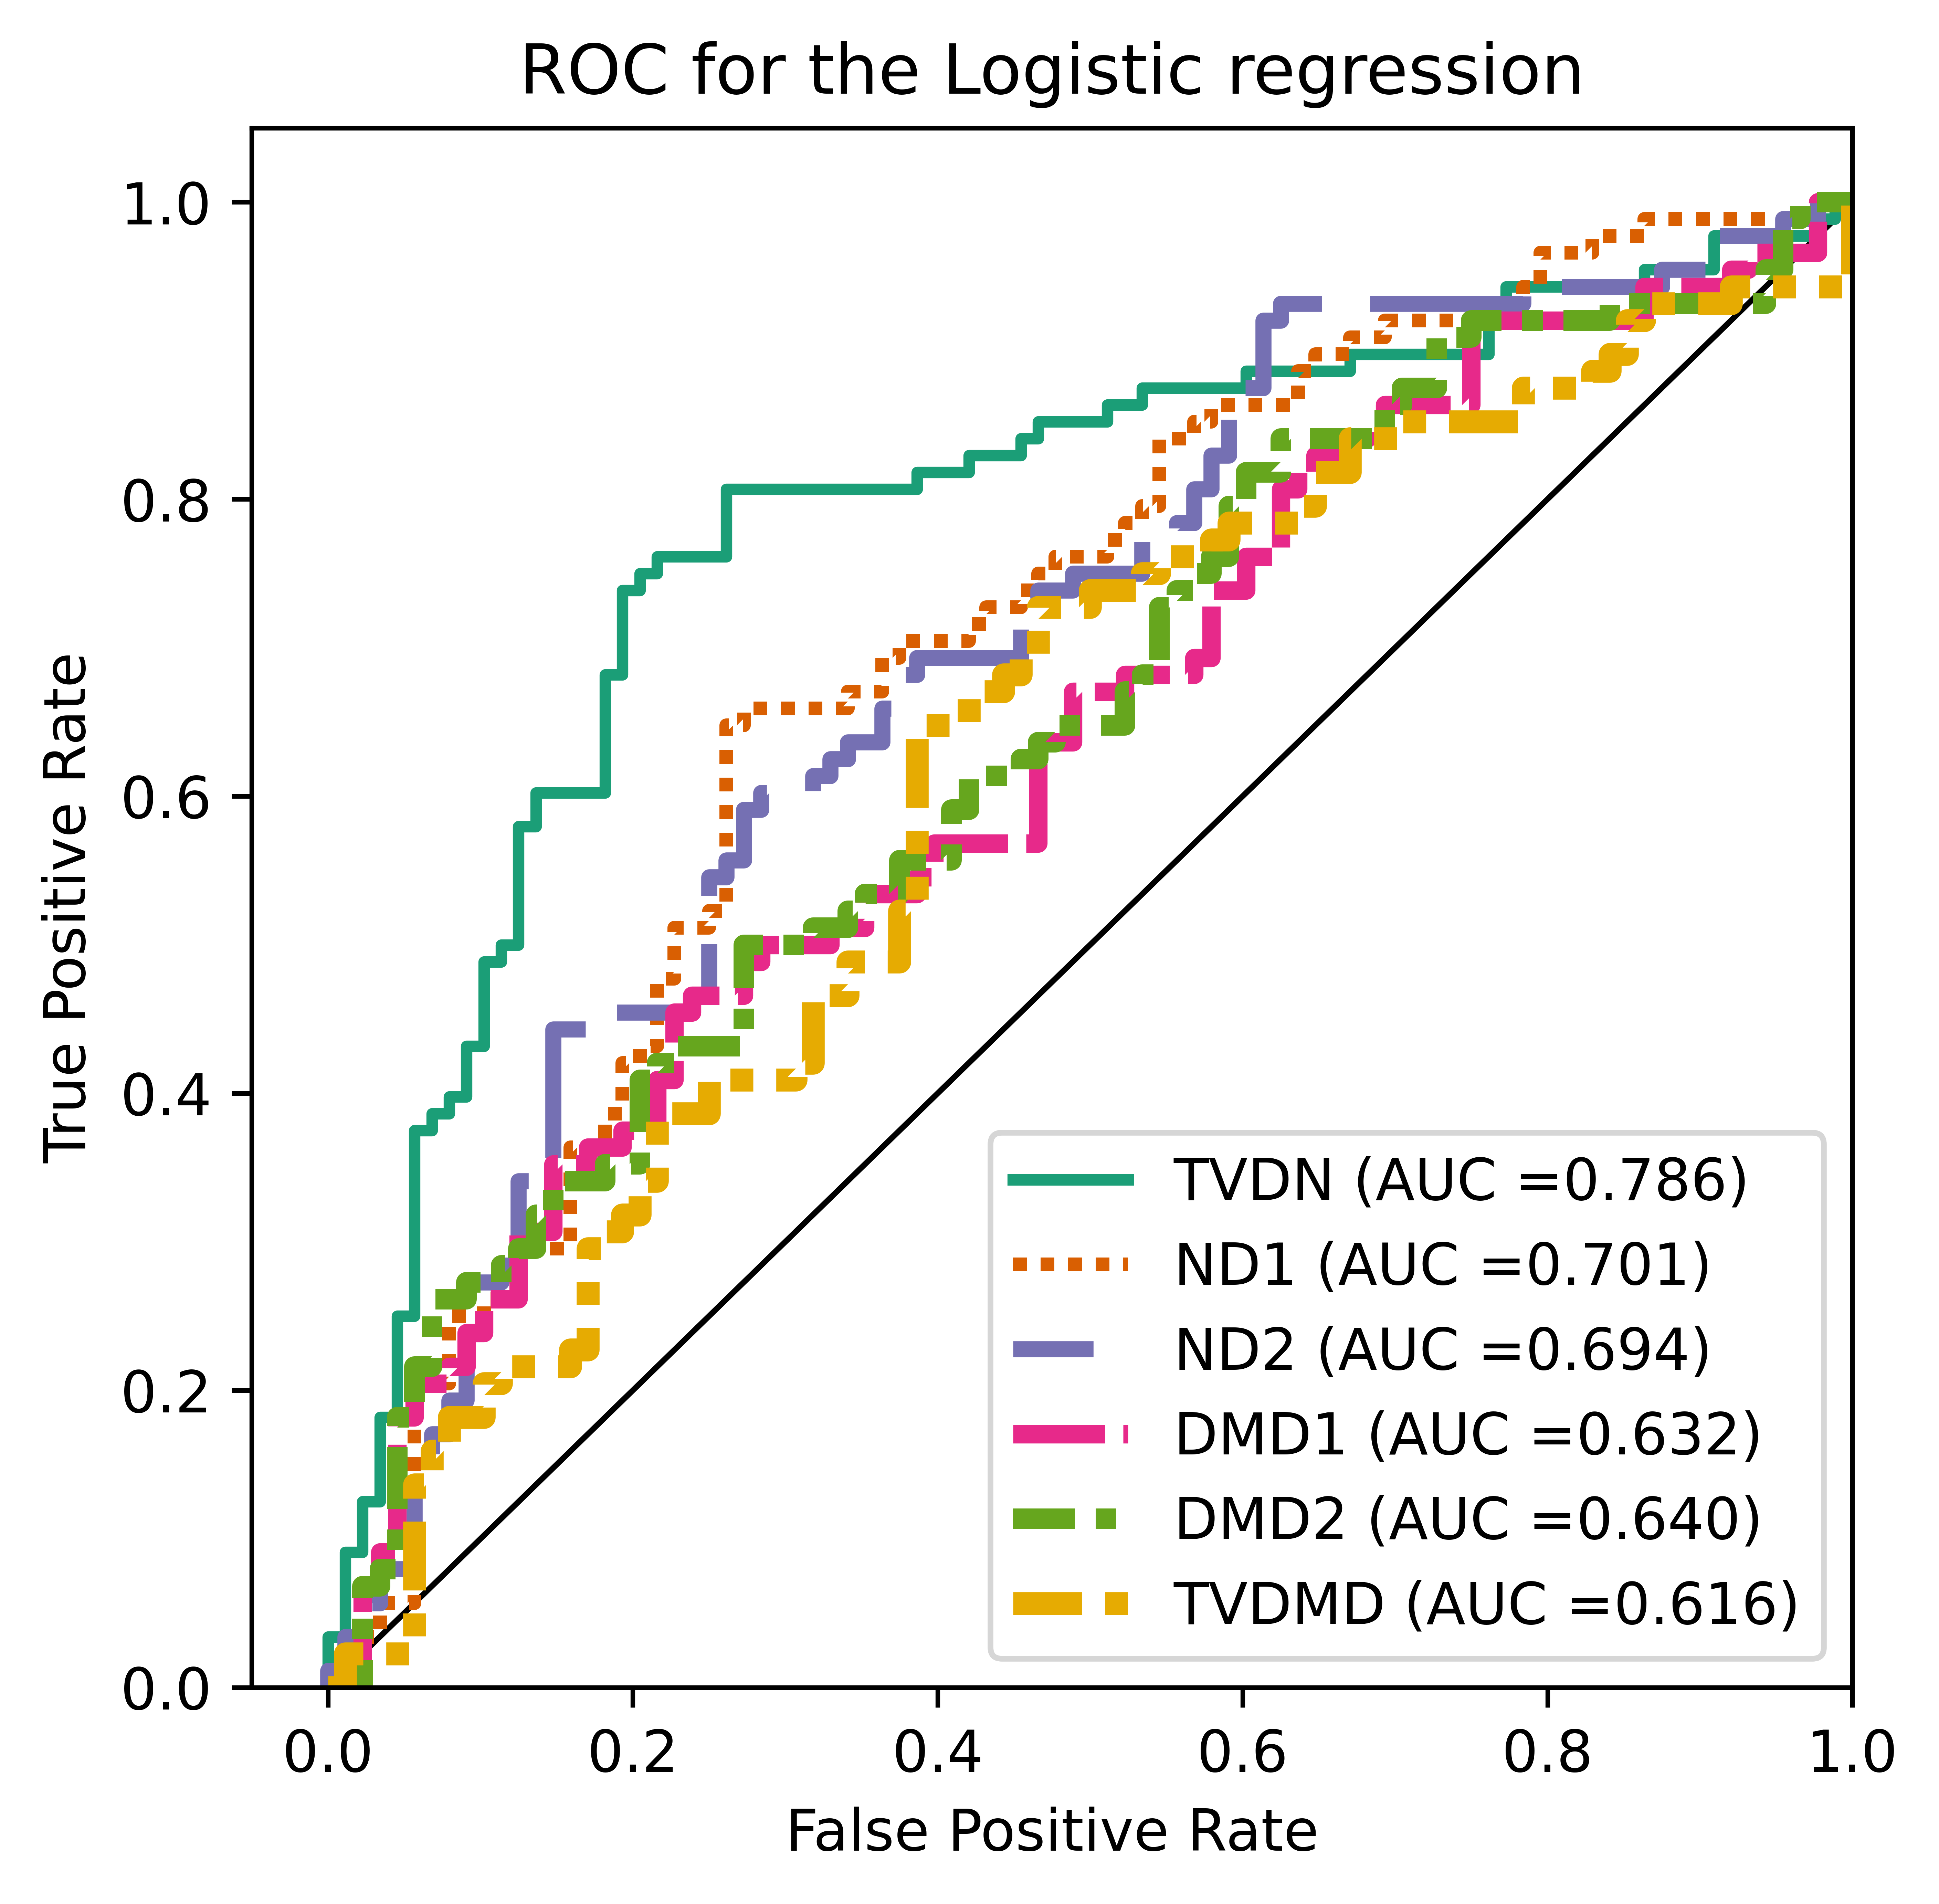

In [80]:
lss = [
     ("line", "-"),
     ('densely dotted',        (0, (1, 1))),
     ('long dash with offset', (5, (10, 3))),
     ('densely dashed',        (0, (5, 1))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]
import seaborn as sns
#cols = sns.color_palette(None, len(rocAll))
#cols =["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33",]
cols = [ "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02",]
markers = ["o", "h", "s", "*", "^", "+"]
lws = np.linspace(2, 4, 6)
plt.figure(figsize=[5, 5], dpi=1200)
plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle="-")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for the Logistic regression")
flag = 0
for key, v in rocAll.items():
    plt.plot(v["fpr"], v["tpr"], label=f"{key} (AUC ={v['AUC']:.3f})", 
             lw=lws[flag], color=cols[flag], linestyle=lss[flag][1])
    flag += 1
plt.legend(loc="lower right")
plt.savefig(f"./plots/{preFix}_rocAll.jpg", bbox_inches='tight')

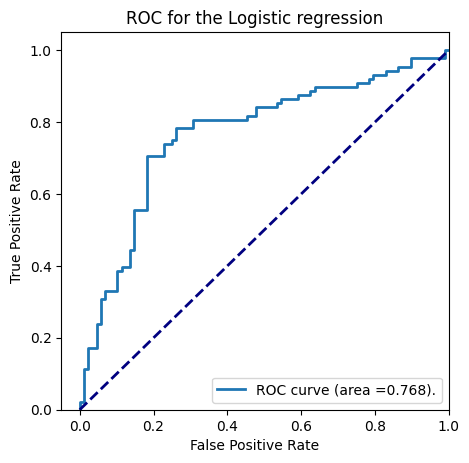

In [79]:
plt.figure(figsize=[5, 5], dpi=100)
plt.plot(gFpr, gTpr, label=f"ROC curve (area ={gAuc:.3f}).", lw=2, color=palette[0])
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for the Logistic regression")
plt.legend(loc="lower right")
#plt.savefig(f"./plots/{preFix}_roc.jpg", bbox_inches='tight')

#### Final fit

In [41]:
clfFinal = LogisticRegression(penalty=penalty, random_state=0, C=gOptC)
clfFinal.fit(stdXs, Ys)
coefsFinal = clfFinal.coef_.reshape(-1)

##### Sel C by Hessian matrix of log reg (I do not think it is meaningful)

In [39]:
clfNoP = LogisticRegression(penalty=penalty, random_state=0, C=1e15)
clfNoP.fit(stdXs, Ys)
NoProbs = clfNoP.predict_proba(stdXs)[:, 1]
Dmat = np.diag(NoProbs*(1-NoProbs))
Hmat = np.matmul(np.matmul(stdXs.T, Dmat), stdXs)
_, Sigs, _ = np.linalg.svd(Hmat)

In [40]:
print(np.mean(Sigs), np.median(Sigs))

0.5301356344229998 0.014305366662637995


In [578]:
eProbs = []
loo = LeaveOneOut()
parass = []
for trIdxs, testIdxs in loo.split(stdXs):
    clf = LogisticRegression(penalty=penalty, random_state=0, C=np.mean(Sigs))
    clf.fit(stdXs[trIdxs, :], Ys[trIdxs])
    paras = clf.coef_.reshape(-1)
    parass.append(paras)
    eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
eProbs = np.array(eProbs).squeeze()
auc = roc_auc_score(Ys, eProbs[:, 1])
fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
parass = np.array(parass)
print(auc)

0.7900974025974026


#### Select important features

##### LOO Confidence interval selection

Not good
(I do not use it)

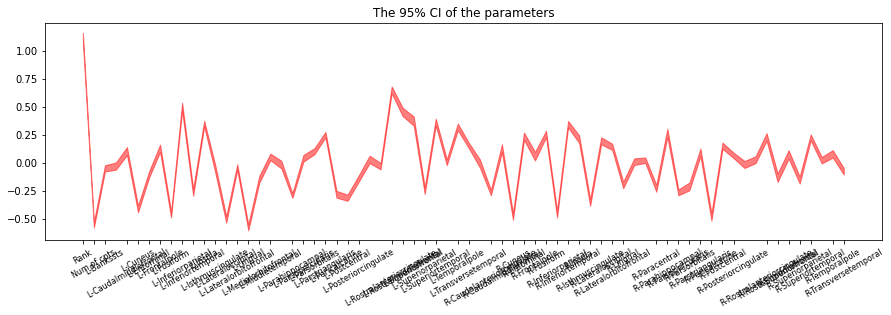

In [24]:
lows, ups = np.quantile(parass[:, :], [0.025, 0.975], axis=0)
#kpidxLOO = np.bitwise_and(lows !=0,  ups != 0)
kpidxLOO = np.bitwise_or(lows >0,  ups < 0)
kpidxLOOId = np.where(kpidxLOO)[0]

xlabs = np.concatenate([["Rank", "Num of cpts"], regionNames])
plt.figure(figsize=[15, 4])
plt.fill_between(list(range(len(lows))), lows, ups, color="red", alpha=.5)
plt.title("The 95% CI of the parameters")
_ = plt.xticks(kpidxLOOId, xlabs[kpidxLOOId], rotation=30, fontsize=8)
#plt.savefig(f"./plots/{preFix}_penaltySel.jpg", bbox_inches='tight')

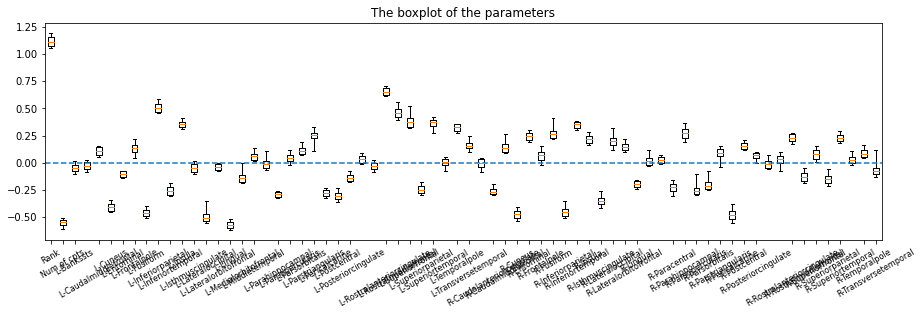

In [26]:
fig, ax = plt.subplots(1, 1, figsize=[15, 4])
stats = []
for idx, nam in enumerate(xlabs):
    stats.append(cbook.boxplot_stats(parass[:, idx], labels=[nam])[0])
    stats[idx]["q1"], stats[idx]["q3"] = np.percentile(parass[:, idx], [2.5, 97.5])
    stats[idx]["whishi"], stats[idx]["whislo"] = np.max(parass[:, idx]), np.min(parass[:, idx])
    stats[idx]["med"] = stats[idx]["mean"]
ax.bxp(stats, positions=range(len(lows)), showfliers=False)    
plt.axhline(y=0, ls="--")
plt.title("The boxplot of the parameters")
_ = plt.xticks(kpidxLOOId, xlabs[kpidxLOOId], rotation=30, fontsize=8)
#plt.savefig(f"./plots/{preFix}_penaltySel.jpg", bbox_inches='tight')

In [28]:
#md = sm.Logit(Ys, stdXs)
md = sm.Logit(Ys, sm.add_constant(stdXs[:, kpidxLOO])) # add intercept
mdres = md.fit()
print(mdres.summary())
print(xlabs[kpidxLOO][mdres.pvalues[1:]<0.05])
#print(xlabs[kpidx])

Optimization terminated successfully.
         Current function value: 0.218097
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  158
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                           59
Date:                Sat, 26 Feb 2022   Pseudo R-squ.:                  0.6824
Time:                        09:43:30   Log-Likelihood:                -34.459
converged:                       True   LL-Null:                       -108.49
Covariance Type:            nonrobust   LLR p-value:                 1.316e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3484      2.107      2.064      0.039       0.219       8.478
x1             4.1258      1

##### Bootstrap Confidence interval selection

I use Bootstrap to select finally as it has better results

We can also calculate the pvalue based on bootstrap by assuming, under $H_0$, $\beta \sim N(0, \sigma^2)$. 

In [42]:
np.random.seed(0)
repTime = 10000
parassBoot = []
for i in tqdm(range(repTime)):
    bootIdx = np.random.choice(len(Ys), len(Ys))
    YsBoot = Ys[bootIdx]
    stdXsBoot = stdXs[bootIdx]
    clf = LogisticRegression(penalty=penalty, random_state=0, C=gOptC)
    clf.fit(stdXsBoot, YsBoot)
    parasBoot = clf.coef_.reshape(-1)
    parassBoot.append(parasBoot)

100%|██████████| 10000/10000 [00:13<00:00, 748.75it/s]


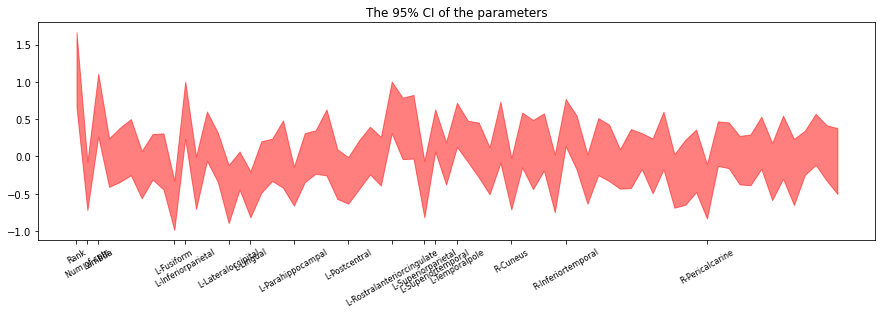

In [43]:
parassBoot = np.array(parassBoot)
#lows, ups = np.quantile(parassBoot[:, :], [0.025, 0.975], axis=0)
lows, ups = coefsFinal-parassBoot.std(axis=0)*1.96, coefsFinal+parassBoot.std(axis=0)*1.96
kpidxBoot = np.bitwise_or(lows >0,  ups < 0)
kpidxIdBoot = np.where(kpidxBoot)[0]

xlabs = np.concatenate([["Rank", "Num of cpts", "Lambda"], regionNames])
#xlabs = np.array(regionNames)
plt.figure(figsize=[15, 4])
plt.fill_between(list(range(len(lows))), lows, ups, color="red", alpha=.5)
plt.title("The 95% CI of the parameters")
_ = plt.xticks(kpidxIdBoot, xlabs[kpidxIdBoot], rotation=30, fontsize=8)

In [47]:
with open(resDir/"main_reg_keep_idx.pkl", "wb") as f:
    pickle.dump(kpidxBoot, f)

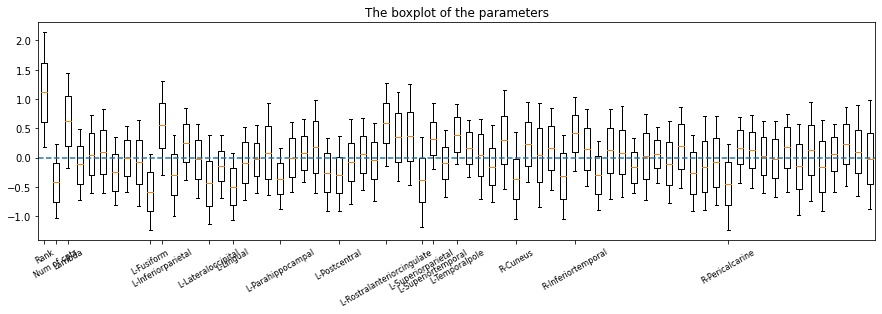

In [31]:
fig, ax = plt.subplots(1, 1, figsize=[15, 4])
stats = []
for idx, nam in enumerate(xlabs):
    stats.append(cbook.boxplot_stats(parassBoot[:, idx], labels=[nam])[0])
    stats[idx]["q1"], stats[idx]["q3"] = np.percentile(parassBoot[:, idx], [2.5, 97.5])
    stats[idx]["whishi"], stats[idx]["whislo"] = np.max(parassBoot[:, idx]), np.min(parassBoot[:, idx])
    stats[idx]["med"] = stats[idx]["mean"]
ax.bxp(stats, positions=range(len(lows)), showfliers=False)    
plt.axhline(y=0, ls="--")
plt.title("The boxplot of the parameters")
_ = plt.xticks(kpidxIdBoot, xlabs[kpidxIdBoot], rotation=30, fontsize=8)
#plt.savefig(f"./plots/{preFix}_penaltySelBoot.jpg", bbox_inches='tight')

In [32]:
# Pvalue
testStatsBoot = coefsFinal/parassBoot.std(axis=0)
#testStatsBoot = parassBoot.mean(axis=0)/parassBoot.std(axis=0)
normRV = norm()
# to be consistent, I think we should use two-sided pvalue
bootPvs = 2*(1-normRV.cdf(np.abs(testStatsBoot)))

In [33]:
# Bootstrap p value and CI are consistent
tmpIdx = np.bitwise_xor(bootPvs <= 0.05, kpidxBoot)
resDic = {
   "Feature" : xlabs[tmpIdx],  
    "Parameters": coefsFinal[tmpIdx],
    "Lower": lows[tmpIdx],
    "Upper": ups[tmpIdx],
    "Pvalues": bootPvs[tmpIdx]
}
pd.set_option("display.precision", 3)
resDF = pd.DataFrame(resDic)
print(resDF)

Empty DataFrame
Columns: [Feature, Parameters, Lower, Upper, Pvalues]
Index: []


##### Permutation test to obtain Pvs and sel parameter (We do not need it anymore)

In [241]:
np.random.seed(0)
repTime = 10000
parassPerm = []
for i in range(repTime):
    YsPerm = np.random.permutation(Ys)
    clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
    clf.fit(stdXs, YsPerm)
    parasPerm= clf.coef_.reshape(-1)
    parassPerm.append(parasPerm)
    
parassPerm = np.array(parassPerm)


#pvals = (np.abs(parassPerm) > np.abs(coefsFinal)).mean(axis=0)
pvals = np.array([(parassPerm > coefsFinal).mean(axis=0), (parassPerm < coefsFinal).mean(axis=0)]).min(axis=0)

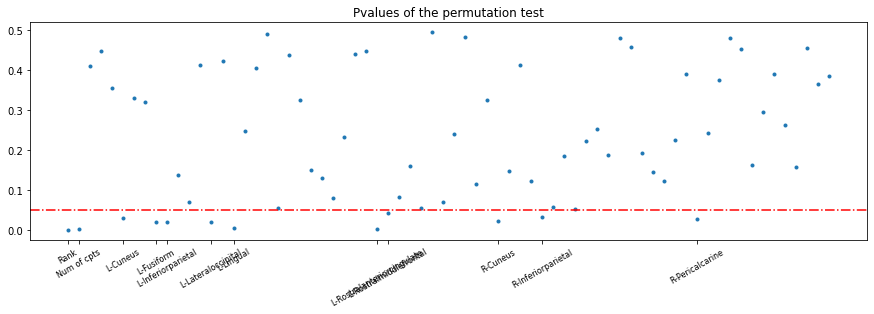

In [183]:
kpidxPerm = pvals < 0.05
kpidxIdPerm= np.where(kpidxPerm)[0]

plt.figure(figsize=[15, 4])
plt.plot(pvals, ".")
plt.axhline(y=0.05, color="red", ls="-.")
plt.title("Pvalues of the permutation test")
_ = plt.xticks(kpidxIdPerm, xlabs[kpidxIdPerm], rotation=30, fontsize=8)
plt.savefig(f"./plots/{preFix}_penaltySelPermPv.jpg", bbox_inches='tight')

##### The output table 

In [34]:
resDic = {
   "Feature" : xlabs[kpidxBoot],  
    "Parameters": coefsFinal[kpidxBoot],
    "Lower": lows[kpidxBoot],
    "Upper": ups[kpidxBoot],
    "Pvalues": bootPvs[kpidxBoot]
}
#pd.set_option("display.precision", 3)
pd.set_option('display.float_format',lambda x : '%.3f' % x)
resDF = pd.DataFrame(resDic)
print(resDF)

                       Feature  Parameters  Lower  Upper  Pvalues
0                         Rank       1.164  0.662  1.666    0.000
1                  Num of cpts      -0.395 -0.720 -0.071    0.017
2                       Lambda       0.690  0.268  1.111    0.001
3                   L-Fusiform      -0.654 -0.985 -0.323    0.000
4           L-Inferiorparietal       0.621  0.237  1.005    0.002
5           L-Lateraloccipital      -0.505 -0.895 -0.115    0.011
6                    L-Lingual      -0.508 -0.817 -0.199    0.001
7            L-Parahippocampal      -0.399 -0.660 -0.137    0.003
8                L-Postcentral      -0.320 -0.633 -0.008    0.044
9   L-Rostralanteriorcingulate       0.657  0.311  1.004    0.000
10          L-Superiorparietal      -0.439 -0.816 -0.061    0.023
11          L-Superiortemporal       0.349  0.066  0.633    0.016
12              L-Temporalpole       0.423  0.127  0.720    0.005
13                    R-Cuneus      -0.366 -0.711 -0.020    0.038
14        

#### Save data for brain under current model

In [919]:
# mean paras of LOO evaluation, do not need this
mParas = np.abs(parass.mean(axis=0)[2:])
outmParas = U2BrainVec(reorderU(minmax(mParas)))
np.savetxt(f"./brainPlotFils/{preFix}_meanParas.txt", outmParas)
pd.DataFrame({"Name": regionNames, "Vec": minmax(mParas)}).to_csv(f"./brainPlotFils/{preFix}_meanParas.csv", index=False)

In [920]:
# mean paras of Bootstrap, do not need this
mParasBoot = np.abs(parassBoot.mean(axis=0)[2:])
outmParasBoot = U2BrainVec(reorderU(minmax(mParasBoot)))
np.savetxt(f"./brainPlotFils/{preFix}_meanParasBoot.txt", outmParasBoot)
pd.DataFrame({"Name": regionNames, "Vec": minmax(mParasBoot)}).to_csv(f"./brainPlotFils/{preFix}_meanParasBoot.csv", index=False)

In [ ]:
# The selected ROIs by after selection via pvalue (Boot), do not need this 
selVec = (kpidxPerm[2:]).astype(np.int)
outSelVec = U2BrainVec(reorderU(selVec))
np.savetxt(f"./brainPlotFils/{preFix}_SelVecPval.txt", outSelVec)
pd.DataFrame({"Name": regionNames, "Vec": selVec }).to_csv(f"./brainPlotFils/{preFix}_SelVecPval.csv", index=False)

In [36]:
# final parameter 
fParas = np.abs(coefsFinal[3:])
outfParas = U2BrainVec(reorderU(minmax(fParas)))
np.savetxt(f"./brainPlotFils/{preFix}_finalParas.txt", outfParas)
pd.DataFrame({"Name": regionNames, "Vec": minmax(fParas)}).to_csv(f"./brainPlotFils/{preFix}_finalParas.csv", index=False)

In [159]:
# final parameter, no abs
oParas = coefsFinal[3:]
outOParas = U2BrainVec(reorderU(minmax2(oParas)))
np.savetxt(f"./brainPlotFils/{preFix}_finalOParas.txt", outOParas)
pd.DataFrame({"Name": regionNames, "Vec": minmax2(oParas)}).to_csv(f"./brainPlotFils/{preFix}_finalOParas.csv", index=False)

In [57]:
# The selected ROIs by after selection via bootstrap
selVec = (kpidxBoot[3:]).astype(np.int)
outSelVec = U2BrainVec(reorderU(selVec))
np.savetxt(f"./brainPlotFils/{preFix}_SelVecBoot.txt", outSelVec)
pd.DataFrame({"Name": regionNames, "Vec": selVec }).to_csv(f"./brainPlotFils/{preFix}_SelVecBoot.csv", index=False)

In [66]:
# The pvalues under Boot
NLogPvs = -np.log10(bootPvs[3:])
NLogPvs[NLogPvs < -np.log10(0.05)] = 0
outSelVec = U2BrainVec(reorderU(NLogPvs))
np.savetxt(f"./brainPlotFils/{preFix}_NLogPvsBoot.txt", outSelVec)
pd.DataFrame({"Name": regionNames, "Vec": NLogPvs}).to_csv(f"./brainPlotFils/{preFix}_NLogPvsBoot.csv", index=False)

In [40]:
# final parameter, abs, remove pv <0.05
oPParas = minmax(np.abs(coefsFinal[3:]))
NLogPvs = -np.log10(bootPvs[3:])
oPParas[NLogPvs < -np.log10(0.05)] = 0
outOPParas = U2BrainVec(reorderU(oPParas))
print(np.sum(oPParas ==0), np.sum(NLogPvs < -np.log10(0.05)))
np.savetxt(f"./brainPlotFils/{preFix}_finalabsOPParas.txt", outOPParas)
pd.DataFrame({"Name": regionNames,
              "Vec": oPParas}).to_csv(f"./brainPlotFils/{preFix}_finalabsOPParas.csv", index=False)

55 55


### Prediction with rank and wUmeanAll

#### No Proj

In [93]:
def rmRepFn(eigVal):
    firstCol = np.array([[True] * np.array(eigVal).shape[0]]).T
    otherCols = np.diff(np.abs(eigVal), 1)!=0
    tmpKpIdx = np.concatenate([firstCol, otherCols], axis=1)
    rmEigVals = np.array(eigVal)[:, tmpKpIdx[0, :]]
    return rmEigVals

In [77]:
fsName = ["r", "wUmeanAll"]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)
stdXs2 = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

In [78]:
eProbs = []
loo = LeaveOneOut()
with tqdm(total=len(Ys)) as t:
    for trIdxs, testIdxs in loo.split(stdXs2):
        curStdXs, curYs = stdXs2[trIdxs, :], Ys[trIdxs]
        curOptC = TuningCFn(curStdXs, curYs, Cs)["optC"]
        clf = LogisticRegression(penalty=penalty, random_state=0, C=curOptC)
        clf.fit(curStdXs, curYs)
        eProbs.append(clf.predict_proba(stdXs2[testIdxs, :]))
        
        t.update()
eProbs = np.array(eProbs).squeeze()
auc2 = roc_auc_score(Ys, eProbs[:, 1])
fpr2, tpr2, _ = roc_curve(Ys, eProbs[:, 1], pos_label=1)
print(auc2)

100%|██████████| 158/158 [04:24<00:00,  1.67s/it]

0.7413961038961039


In [79]:
optC2 = TuningCFn(stdXs2, Ys, Cs)["optC"]

np.random.seed(0)
nobs = stdXs2.shape[0]
Aucss2 = []
for j in tqdm(range(10000)):
    testIdx = np.random.choice(nobs, int(nobs/5), False)
    trainIdx = np.delete(np.arange(nobs), testIdx)
    clf = LogisticRegression(penalty=penalty, random_state=0, C=optC2)
    clf.fit(stdXs2[trainIdx], Ys[trainIdx])
    curEprobs = clf.predict_proba(stdXs2[testIdx, :])
    curAuc = roc_auc_score(Ys[testIdx], curEprobs[:, 1])
    Aucss2.append(curAuc)
mAUC2 = np.mean(Aucss2)
stdAUC2 = np.std(Aucss2)
print(f"The mean of AUC under 1000 repetitions is {mAUC2:.3f} and the standard deviation is {stdAUC2:.3f}.")



100%|██████████| 10000/10000 [00:15<00:00, 640.94it/s]

The mean of AUC under 1000 repetitions is 0.756 and the standard deviation is 0.080.


#### Proj

In [58]:
fsName = ["r", "ncpts", "wUmeanAll"]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)
stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

In [69]:
subSp = stdXs[:, 1]
proj = np.matmul(subSp.reshape(-1, 1), subSp.reshape(1, -1))/np.sum(subSp*subSp)
orProj = np.eye(len(subSp)) - proj
resMat = np.matmul(orProj, stdXs[:, 2:])

# the feature to regression
projXs = np.concatenate([stdXs[:, 0].reshape(-1, 1), resMat], axis=1)
projStdXs = (projXs - projXs.mean(axis=0))/projXs.std(axis=0)
Ys = np.concatenate([np.ones(len(fsAD)), np.zeros(len(fsCtrl))])

In [74]:
eProbs = []
loo = LeaveOneOut()
with tqdm(total=len(Ys)) as t:
    for trIdxs, testIdxs in loo.split(projStdXs):
        curStdXs, curYs = projStdXs[trIdxs, :], Ys[trIdxs]
        curOptC = TuningCFn(curStdXs, curYs, Cs)["optC"]
        clf = LogisticRegression(penalty=penalty, random_state=0, C=curOptC)
        clf.fit(curStdXs, curYs)
        eProbs.append(clf.predict_proba(projStdXs[testIdxs, :]))
        
        t.update()
eProbs = np.array(eProbs).squeeze()
projAuc = roc_auc_score(Ys, eProbs[:, 1])
projFpr, projTpr, _ = roc_curve(Ys, eProbs[:, 1], pos_label=1)
print(projAuc)

100%|██████████| 158/158 [04:49<00:00,  1.83s/it]

0.7435064935064934


In [76]:
projOptC = TuningCFn(projStdXs, Ys, Cs)["optC"]

np.random.seed(0)
nobs = projStdXs.shape[0]
projAucss = []
for j in tqdm(range(10000)):
    testIdx = np.random.choice(nobs, int(nobs/5), False)
    trainIdx = np.delete(np.arange(nobs), testIdx)
    clf = LogisticRegression(penalty=penalty, random_state=0, C=projOptC)
    clf.fit(projStdXs[trainIdx], Ys[trainIdx])
    curEprobs = clf.predict_proba(projStdXs[testIdx, :])
    curAuc = roc_auc_score(Ys[testIdx], curEprobs[:, 1])
    projAucss.append(curAuc)
mProjAUC = np.mean(projAucss)
stdProjAUC = np.std(projAucss)
print(f"The mean of AUC under 1000 repetitions is {mProjAUC:.3f} and the standard deviation is {stdProjAUC:.3f}.")



100%|██████████| 10000/10000 [00:15<00:00, 635.63it/s]

The mean of AUC under 1000 repetitions is 0.760 and the standard deviation is 0.079.


###  Clustering with X used in regression

In [50]:
Ys = np.concatenate([np.ones(len(fsAD)), np.zeros(len(fsCtrl))])
fsName = ["r", "ncpts", "wUmeanAll"]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)
stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

clu = KMeans(n_clusters=2, random_state=0).fit(stdXs)
# clu= SpectralClustering(n_clusters=2, random_state=0).fit(stdXs)
elabs =clu.labels_
tlabs = Ys.copy()
tlabsRaw = np.array(["AD"] * int(np.sum(Ys)) + ["Control"] * int(np.sum(1-Ys)))
tb = np.array(pd.crosstab(elabs, tlabs))
OR, pv = fisher_exact(tb)
pStr = f"The odds ratio between control and AD groups is {OR:.3f}, the pvalue of the fisher exact test is {pv:.3f}."
print(pStr)
pd.crosstab(elabs, tlabsRaw)

The odds ratio between control and AD groups is 1.667, the pvalue of the fisher exact test is 0.424.


col_0  AD  Control
row_0             
0      78       65
1      10        5

### Projection wUmean on [rank, ncpt] space 

In [133]:
fsName = ["r", "ncpts", "wUmeanAll"]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)
stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

In [134]:
targetMat = stdXs[:, :2]
orgMat = stdXs[:, 2:]
projMat = np.eye(targetMat.shape[0]) -  \
          np.matmul(np.matmul(targetMat, np.linalg.inv(np.matmul(targetMat.T, targetMat))), targetMat.T)
resMat = np.matmul(projMat, orgMat)

Test statistic: 1.2491807289115167
Degrees of freedom: 68 and 89
p-value: 0.16165967020537741


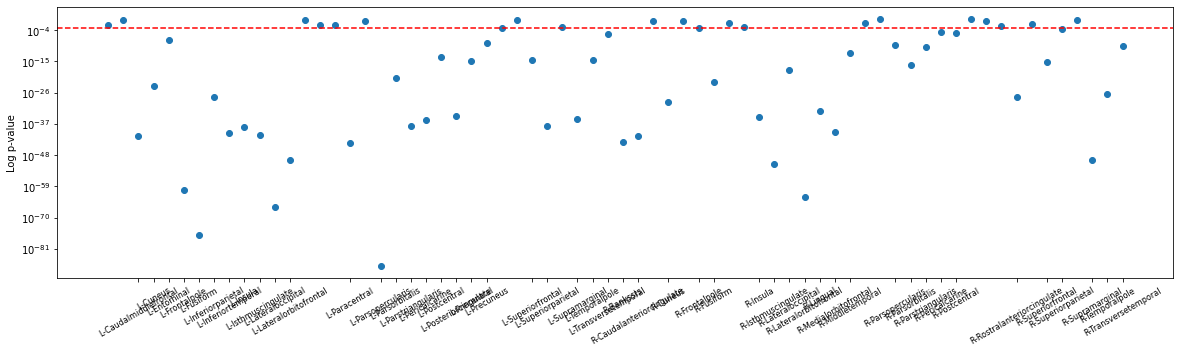

In [135]:
saveNam = "_".join(fsName)
mFAD = resMat[:len(fsAD), :]
mFCtrl = resMat[len(fsAD):, ]
_, hotelPv = TwoSampleT2Test(mFAD, mFCtrl)

mPvs = []
for ix in range(68):
    curAD = mFAD[ix, :]
    curCtrl = mFCtrl[ix, :]
    curRes = scipy.stats.ttest_ind(curAD, curCtrl)
    mPvs.append(curRes.pvalue)
    
curKpIdx = np.array(mPvs) <= (0.05/68)
curKpIdxId = np.where(curKpIdx)[0]
plt.figure(figsize=[20, 5])
plt.plot(mPvs, "o")
plt.axhline(y=0.05/68, color="red", ls="--")
plt.yscale("log")
plt.ylabel("Log p-value")
_ = plt.xticks(curKpIdxId, np.array(regionNames)[curKpIdxId], rotation=30, fontsize=8)
#plt.savefig(f"./plots/{fName}_ttestPval.jpg", bbox_inches='tight')


selVec = (curKpIdx).astype(np.int)
outSelVec = U2BrainVec(reorderU(selVec))
np.savetxt(f"./brainPlotFils/{saveNam}_ttestPvalSelProj.txt", outSelVec)
pd.DataFrame({"Name": regionNames, "Vec": selVec }).to_csv(f"./brainPlotFils/{saveNam}_ttestPvalSelProj.csv", index=False)

In [136]:
projXs = np.concatenate([targetMat, resMat], axis=1)
projStdXs = (projXs - projXs.mean(axis=0))/projXs.std(axis=0)
Ys = np.concatenate([np.ones(len(fsAD)), np.zeros(len(fsCtrl))])
    
Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4]
eProbs = []
loo = LeaveOneOut()
parass = []
with tqdm(total=len(Ys)) as t:
    for trIdxs, testIdxs in loo.split(projStdXs):
        curStdXs, curYs = projStdXs[trIdxs, :], Ys[trIdxs]
        curOptC = TuningCFn(curStdXs, curYs, Cs)["optC"]
        clf = LogisticRegression(penalty=penalty, random_state=0, C=curOptC)
        clf.fit(curStdXs, curYs)
        paras = np.concatenate([clf.intercept_, clf.coef_.reshape(-1)])
        parass.append(paras)
        eProbs.append(clf.predict_proba(projStdXs[testIdxs, :]))
        
        t.update()
        
eProbs = np.array(eProbs).squeeze()
auc = roc_auc_score(Ys, eProbs[:, 1])
fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
parass = np.array(parass)
    
projOptC = TuningCFn(projStdXs, Ys, Cs)["optC"]
nobs = projStdXs.shape[0]
Aucss = []
for j in tqdm(range(10000)):
    testIdx = np.random.choice(nobs, int(nobs/5), False)
    trainIdx = np.delete(np.arange(nobs), testIdx)
    clf = LogisticRegression(penalty=penalty, random_state=0, C=projOptC)
    clf.fit(projStdXs[trainIdx], Ys[trainIdx])
    curEprobs = clf.predict_proba(projStdXs[testIdx, :])
    curAuc = roc_auc_score(Ys[testIdx], curEprobs[:, 1])
    Aucss.append(curAuc)
mAUC = np.mean(Aucss)
stdAUC = np.std(Aucss)
print(f"The AUC under optimal C is {auc:.3f}.")
print(f"The mean of AUC under 1000 repetitions is {mAUC:.3f} and the standard deviation is {stdAUC:.3f}.")
print("-"*100)

100%|██████████| 10000/10000 [00:17<00:00, 570.64it/s]

The AUC under optimal C is 0.774.
The mean of AUC under 1000 repetitions is 0.773 and the standard deviation is 0.077.
----------------------------------------------------------------------------------------------------


In [137]:
projClfFinal = LogisticRegression(penalty=penalty, random_state=0, C=projOptC)
projClfFinal.fit(projStdXs, Ys)
projCoefsFinal = projClfFinal.coef_.reshape(-1)

In [138]:
np.random.seed(0)
repTime = 10000
projParassBoot = []
for i in tqdm(range(repTime)):
    bootIdx = np.random.choice(len(Ys), len(Ys))
    YsBoot = Ys[bootIdx]
    stdXsBoot = projStdXs[bootIdx]
    clf = LogisticRegression(penalty=penalty, random_state=0, C=projOptC)
    clf.fit(stdXsBoot, YsBoot)
    parasBoot = clf.coef_.reshape(-1)
    projParassBoot.append(parasBoot)

100%|██████████| 10000/10000 [00:13<00:00, 738.96it/s]


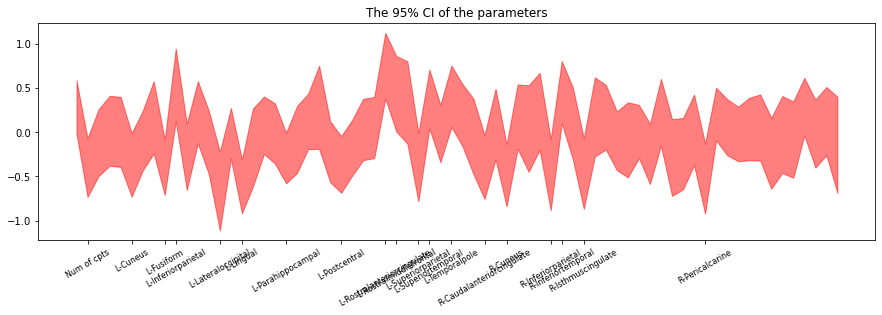

In [139]:
projParassBoot = np.array(projParassBoot)
lows, ups = projCoefsFinal-projParassBoot.std(axis=0)*1.96, projCoefsFinal+projParassBoot.std(axis=0)*1.96
projKpidxBoot = np.bitwise_or(lows >0,  ups < 0)
projKpidxIdBoot = np.where(projKpidxBoot)[0]

xlabs = np.concatenate([["Rank", "Num of cpts"], regionNames])
#xlabs = np.array(regionNames)
plt.figure(figsize=[15, 4])
plt.fill_between(list(range(len(lows))), lows, ups, color="red", alpha=.5)
plt.title("The 95% CI of the parameters")
_ = plt.xticks(projKpidxIdBoot, xlabs[projKpidxIdBoot], rotation=30, fontsize=8)

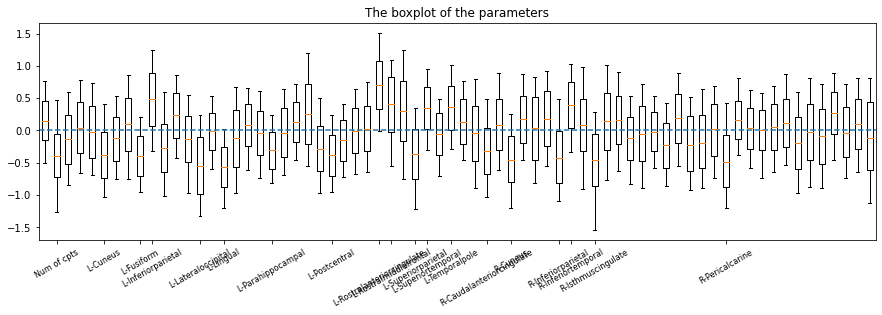

In [140]:
fig, ax = plt.subplots(1, 1, figsize=[15, 4])
stats = []
for idx, nam in enumerate(xlabs):
    stats.append(cbook.boxplot_stats(projParassBoot[:, idx], labels=[nam])[0])
    stats[idx]["q1"], stats[idx]["q3"] = np.percentile(projParassBoot[:, idx], [2.5, 97.5])
    stats[idx]["whishi"], stats[idx]["whislo"] = np.max(projParassBoot[:, idx]), np.min(projParassBoot[:, idx])
    stats[idx]["med"] = stats[idx]["mean"]
ax.bxp(stats, positions=range(len(lows)), showfliers=False)    
plt.axhline(y=0, ls="--")
plt.title("The boxplot of the parameters")
_ = plt.xticks(projKpidxIdBoot, xlabs[projKpidxIdBoot], rotation=30, fontsize=8)
plt.savefig(f"./plots/{preFix}_penaltySelBootProj.jpg", bbox_inches='tight')

In [141]:
# Pvalue
testStatsBoot = projCoefsFinal/projParassBoot.std(axis=0)
normRV = norm()
# to be consistent, I think we should use two-sided pvalue
projBootPvs = 2*(1-normRV.cdf(np.abs(testStatsBoot)))

In [142]:
# Bootstrap p value and CI are consistent
tmpIdx = np.bitwise_xor(projBootPvs <= 0.05, projKpidxBoot)
resDic = {
   "Feature" : xlabs[tmpIdx],  
    "Parameters": projCoefsFinal[tmpIdx],
    "Lower": lows[tmpIdx],
    "Upper": ups[tmpIdx],
    "Pvalues": projBootPvs[tmpIdx]
}
pd.set_option("display.precision", 3)
resDF = pd.DataFrame(resDic)
print(resDF)

Empty DataFrame
Columns: [Feature, Parameters, Lower, Upper, Pvalues]
Index: []


In [143]:
resDic = {
   "Feature" : xlabs[projKpidxBoot],  
    "Parameters": projCoefsFinal[projKpidxBoot],
    "Lower": lows[projKpidxBoot],
    "Upper": ups[projKpidxBoot],
    "Pvalues": projBootPvs[projKpidxBoot]
}
pd.set_option("display.precision", 3)
resDF = pd.DataFrame(resDic)
print(resDF)

                       Feature  Parameters  Lower  Upper    Pvalues
0                  Num of cpts      -0.400 -0.733 -0.068  1.815e-02
1                     L-Cuneus      -0.369 -0.729 -0.009  4.475e-02
2                   L-Fusiform      -0.398 -0.710 -0.085  1.259e-02
3           L-Inferiorparietal       0.539  0.127  0.951  1.032e-02
4           L-Lateraloccipital      -0.667 -1.113 -0.220  3.429e-03
5                    L-Lingual      -0.614 -0.918 -0.309  7.753e-05
6            L-Parahippocampal      -0.291 -0.578 -0.004  4.658e-02
7                L-Postcentral      -0.364 -0.686 -0.043  2.622e-02
8   L-Rostralanteriorcingulate       0.757  0.385  1.128  6.583e-05
9       L-Rostralmiddlefrontal       0.437  0.009  0.865  4.550e-02
10          L-Superiorparietal      -0.395 -0.784 -0.006  4.631e-02
11          L-Superiortemporal       0.380  0.047  0.712  2.516e-02
12              L-Temporalpole       0.409  0.060  0.757  2.146e-02
13   R-Caudalanteriorcingulate      -0.394 -0.75

In [144]:
# final parameter
fParas = np.abs(projCoefsFinal[2:])
outfParas = U2BrainVec(reorderU(minmax(fParas)))
np.savetxt(f"./brainPlotFils/{preFix}_finalParasProj.txt", outfParas)
pd.DataFrame({"Name": regionNames, "Vec": minmax(fParas)}).to_csv(f"./brainPlotFils/{preFix}_finalParasProj.csv", index=False)

In [145]:
# The selected ROIs by after selection via bootstrap
selVec = (projKpidxBoot[2:]).astype(np.int)
outSelVec = U2BrainVec(reorderU(selVec))
np.savetxt(f"./brainPlotFils/{preFix}_SelVecBootProj.txt", outSelVec)
pd.DataFrame({"Name": regionNames, "Vec": selVec }).to_csv(f"./brainPlotFils/{preFix}_SelVecBootProj.csv", index=False)

###  Correlation of  7 cannonical networks and wU and Kmean on wU

####  Violin plot for corrs for all wU

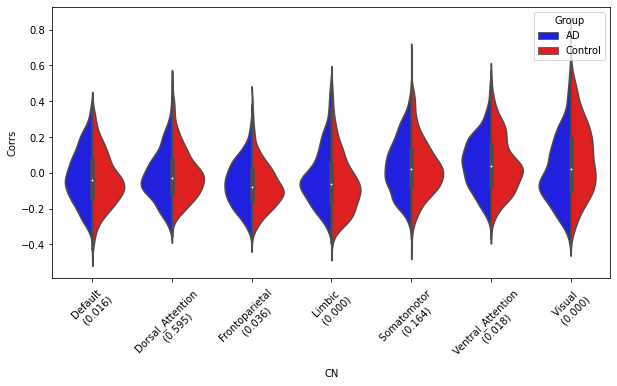

In [158]:
corrAD = []
corrCtrl = []
for ix in range(len(fsAD)):
    corrAD = corrAD + fsAD[ix].wUcorrsAll
for ix in range(len(fsCtrl)):
    corrCtrl = corrCtrl + fsCtrl[ix].wUcorrsAll
groupLabs = ["AD"] * (len(corrAD)*7) + ["Control"] * (len(corrCtrl)*7)

cnLabs = []
corrAD = np.array(corrAD)
corrADflat = []
corrCtrl = np.array(corrCtrl)
corrCtrlflat = []
for ix in range(7):
    corrADflat = corrADflat + list(corrAD[:, ix])
    cnLabs = cnLabs + [rowNames[ix]] * len(corrAD[:, ix])
    
for ix in range(7):
    corrCtrlflat = corrCtrlflat + list(corrCtrl[:, ix])
    cnLabs = cnLabs + [rowNames[ix]] * len(corrCtrl[:, ix])
corrs = corrADflat + corrCtrlflat

corrDF = pd.DataFrame({"Corrs":np.array(corrs), "CN":cnLabs, "Group":groupLabs})

xticklabs = []
for nam in rowNames:
    curSubAD = corrDF[(corrDF["CN"] == nam) & (corrDF["Group"] == "AD")]
    curSubCtrl = corrDF[(corrDF["CN"] == nam) & (corrDF["Group"] == "Control")]
    restt = scipy.stats.ttest_ind(curSubAD["Corrs"], curSubCtrl["Corrs"])
    resrs = scipy.stats.ranksums(curSubAD["Corrs"], curSubCtrl["Corrs"])
    resks = scipy.stats.kstest(curSubAD["Corrs"], curSubCtrl["Corrs"])
    xticklabs.append(f"{nam} \n ({resks.pvalue:.3f})")

plt.figure(figsize=[10, 5])
sns.violinplot(x="CN", y="Corrs", hue="Group", data=corrDF, 
               split=True, palette = {"AD":'blue', "Control":'red'}, order=rowNames)
plt.xticks(np.arange(7), xticklabs)
_ = plt.xticks(rotation=45)

#### Dist of maximal corrs among the 7 CNs

In [159]:
maxCorrNetAD = []
for ix in range(len(fsAD)):
    maxCorrNetAD = maxCorrNetAD + list(np.array(rowNames)[np.array(fsAD[ix].wUcorrsAll).argmax(axis=1)])
maxCorrNetCtrl = []
for ix in range(len(fsCtrl)):
    maxCorrNetCtrl = maxCorrNetCtrl + list(np.array(rowNames)[np.array(fsCtrl[ix].wUcorrsAll).argmax(axis=1)])

In [160]:
ADct = []
Ctrlct = []
for nam in rowNames:
    ADct.append(maxCorrNetAD.count(nam))
    Ctrlct.append(maxCorrNetCtrl.count(nam))
ADfreq = np.array(ADct)/np.sum(ADct)
Ctrlfreq = np.array(Ctrlct)/np.sum(Ctrlct)

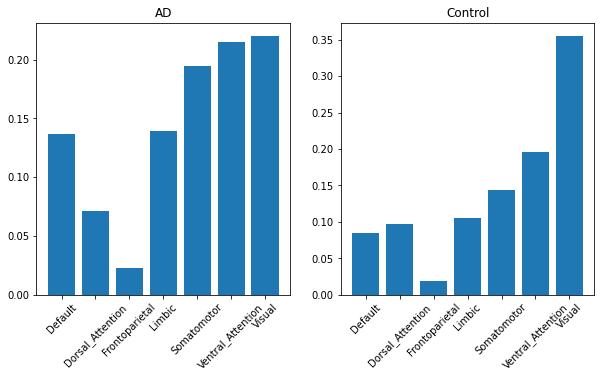

In [161]:
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.title("AD")
plt.bar(rowNames, ADfreq)
plt.xticks(rotation=45)

plt.subplot(122)
plt.title("Control")
plt.bar(rowNames, Ctrlfreq)
_ = plt.xticks(rotation=45)

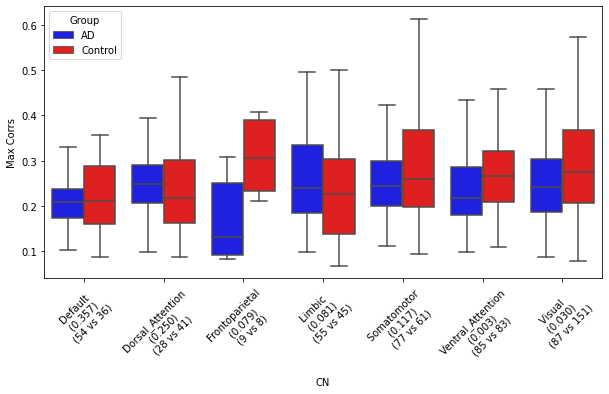

In [162]:
cnLabsMax = []
corrADMaxflat = []
corrCtrlMaxflat = []
for ix in range(len(fsAD)):
    curF = fsAD[ix]
    for ixx in range(len(curF.wUcorrsAll)):
        corrADMaxflat.append(np.max(curF.wUcorrsAll[ixx]))
        cnLabsMax.append(rowNames[np.argmax(curF.wUcorrsAll[ixx])])
    
for ix in range(len(fsCtrl)):
    curF = fsCtrl[ix]
    for ixx in range(len(curF.wUcorrsAll)):
        corrCtrlMaxflat.append(np.max(curF.wUcorrsAll[ixx]))
        cnLabsMax.append(rowNames[np.argmax(curF.wUcorrsAll[ixx])])
        
corrsMax = corrADMaxflat + corrCtrlMaxflat
groupLabsMax = ["AD"]* len(corrADMaxflat) + ["Control"] * len(corrCtrlMaxflat)
corrDF = pd.DataFrame({"Corrs":np.array(corrsMax), "CN":cnLabsMax, "Group":groupLabsMax})

xticklabs = []
for nam in rowNames:
    curSubAD = corrDF[(corrDF["CN"] == nam) & (corrDF["Group"] == "AD")]
    curSubCtrl = corrDF[(corrDF["CN"] == nam) & (corrDF["Group"] == "Control")]
    restt = scipy.stats.ttest_ind(curSubAD["Corrs"], curSubCtrl["Corrs"])
    resrs = scipy.stats.ranksums(curSubAD["Corrs"], curSubCtrl["Corrs"])
    resks = scipy.stats.kstest(curSubAD["Corrs"], curSubCtrl["Corrs"])
    xticklabs.append(f"{nam} \n ({resks.pvalue:.3f}) \n ({len(curSubAD)} vs {len(curSubCtrl)})")

plt.figure(figsize=[10, 5])
#sns.violinplot(x="CN", y="Corrs", hue="Group", data=corrDF, 
#               split=True, palette = {"AD":'blue', "Control":'red'}, order=rowNames)
sns.boxplot(x="CN", y="Corrs", hue="Group", data=corrDF, showfliers=False, 
               palette = {"AD":'blue', "Control":'red'}, order=rowNames)
plt.xticks(np.arange(7), xticklabs)
plt.ylabel("Max Corrs")
_ = plt.xticks(rotation=45)

####  Dist of dwell times for maximal corrs of 7 nets 

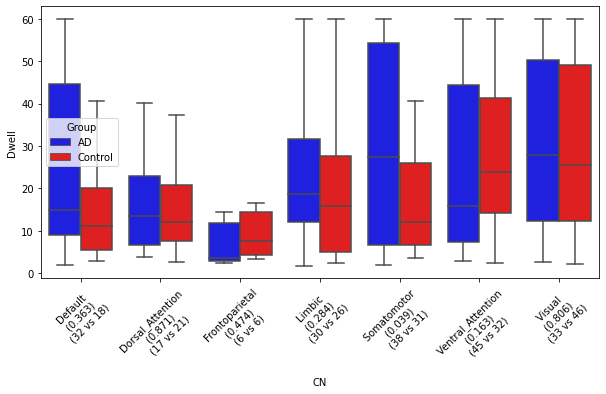

In [163]:
curDNLAD = []
curDNLCtrl = []
curDwell = []

for ix in range(len(fsAD)):
    curDwellCt = ddict(float)
    curMlabs = np.array(rowNames)[np.array(fsAD[ix].wUcorrsAll).argmax(axis=1)]
    for ixx, curMlab in enumerate(curMlabs):
        curDwellCt[curMlab] += fsAD[ix].dwell[ixx]
    allIts = list(curDwellCt.items())
    curDwell = curDwell + [ixxx[1] for ixxx in allIts]
    curDNLAD = curDNLAD + [ixxx[0] for ixxx in allIts]

for ix in range(len(fsCtrl)):
    curDwellCt = ddict(float)
    curMlabs = np.array(rowNames)[np.array(fsCtrl[ix].wUcorrsAll).argmax(axis=1)]
    for ixx, curMlab in enumerate(curMlabs):
        curDwellCt[curMlab] += fsCtrl[ix].dwell[ixx]
    allIts = list(curDwellCt.items())
    curDwell = curDwell + [ixxx[1] for ixxx in allIts]
    curDNLCtrl = curDNLCtrl + [ixxx[0] for ixxx in allIts]
    
# below do not consider a subject have multiple segment for same label
# for ix in range(len(fsAD)):
#     curDwell = curDwell + list(fsAD[ix].dwell)
#     curDNLAD = curDNLAD + list(np.array(rowNames)[np.array(fsAD[ix].wUcorrsAll).argmax(axis=1)])
# for ix in range(len(fsCtrl)):
#     curDwell = curDwell + list(fsCtrl[ix].dwell)
#     curDNLCtrl = curDNLCtrl + list(np.array(rowNames)[np.array(fsCtrl[ix].wUcorrsAll).argmax(axis=1)])
    
dwellDF = pd.DataFrame({"Dwell": curDwell, "CN": curDNLAD+curDNLCtrl, 
                        "Group": ["AD"]*len(curDNLAD) + ["Control"]*len(curDNLCtrl)})

xticklabs = []
for nam in rowNames:
    curSubAD = dwellDF[(dwellDF["CN"] == nam) & (dwellDF["Group"] == "AD")]
    curSubCtrl = dwellDF[(dwellDF["CN"] == nam) & (dwellDF["Group"] == "Control")]
    restt = scipy.stats.ttest_ind(curSubAD["Dwell"], curSubCtrl["Dwell"])
    resrs = scipy.stats.ranksums(curSubAD["Dwell"], curSubCtrl["Dwell"])
    resks = scipy.stats.kstest(curSubAD["Dwell"], curSubCtrl["Dwell"])
    # xticklabs.append(f"{nam} \n ({restt.pvalue:.3f})")
    xticklabs.append(f"{nam} \n ({resks.pvalue:.3f}) \n ({len(curSubAD)} vs {len(curSubCtrl)})")
    
plt.figure(figsize=[10, 5])
sns.boxplot(x="CN", y="Dwell", hue="Group", data=dwellDF, palette = {"AD":'blue', "Control":'red'}, order=rowNames, showfliers=False)
#sns.violinplot(x="CN", y="Dwell", hue="Group", data=dwellDF, split=True, palette = {"AD":'blue', "Control":'red'}, order=rowNames)
plt.xticks(np.arange(7), xticklabs)
_ = plt.xticks(rotation=45)

#### mean of wU with label assigned by maximal correlations

In [164]:
wUADdict = ddict(list)
wUCtrldict = ddict(list)

for ix in range(len(fsAD)):
    curFs = fsAD[ix]
    CNlabs = list(np.array(rowNames)[np.array(curFs.wUcorrsAll).argmax(axis=1)])
    for ixx, CNlab in enumerate(CNlabs):
        curWU = curFs.wUAll[:, ixx]
        wUADdict[CNlab].append(curWU)
        
for ix in range(len(fsCtrl)):
    curFs = fsCtrl[ix]
    CNlabs = list(np.array(rowNames)[np.array(curFs.wUcorrsAll).argmax(axis=1)])
    for ixx, CNlab in enumerate(CNlabs):
        curWU = curFs.wUAll[:, ixx]
        wUCtrldict[CNlab].append(curWU)

In [165]:
nDis = 8
for nam in rowNames:
    curWUmeanAD = np.array(wUADdict[nam]).mean(axis=0)
    curWUmeanCtrl = np.array(wUCtrldict[nam]).mean(axis=0)
    # curWUmeanAD = discretVec(curWUmeanAD, np.linspace(0, 1, nDis+1))
    # curWUmeanAD = discretVec(curWUmeanCtrl, np.linspace(0, 1, nDis+1))
    mFAD = minmax(curWUmeanAD)
    mFCtrl = minmax(curWUmeanCtrl)
    outAD = U2BrainVec(reorderU(mFAD))
    outCtrl = U2BrainVec(reorderU(mFCtrl))
    np.savetxt(f"./brainPlotFils/wUmeanAD_{nam}.txt", outAD)
    np.savetxt(f"./brainPlotFils/wUmeanCtrl_{nam}.txt", outCtrl)
    


In [348]:
for ix, nam in enumerate(rowNames):
    curFcRMM = fcRarrMM[ix, :]
    outVec = U2BrainVec(reorderU(curFcRMM))
    np.savetxt(f"./brainPlotFils/CN_{nam}.txt", outVec)

####  Corr between clustering center and CNs

In [23]:
wUADAll = np.concatenate([fs.wUAll for fs in fsAD], axis=1)
wUCtrlAll = np.concatenate([fs.wUAll for fs in fsCtrl], axis=1)
dwellADAll = np.concatenate([fs.dwell for fs in fsAD])
dwellCtrlAll = np.concatenate([fs.dwell for fs in fsCtrl])

In [24]:
cluAD = KMeans(n_clusters=7, random_state=0).fit(wUADAll.T)
ADcluCenter = cluAD.cluster_centers_
cluCtrl = KMeans(n_clusters=7, random_state=0).fit(wUCtrlAll.T)
CtrlcluCenter = cluCtrl.cluster_centers_

In [25]:
ADcorrsCens = []
for ix in range(ADcluCenter.shape[0]):
    curCenterMM = minmax(ADcluCenter[ix, :])
    curCorrs = []
    for ixx in range(fcRarrMM.shape[0]):
        curCorrs.append(ss.pearsonr(fcRarrMM[ixx, :], curCenterMM)[0])
    ADcorrsCens.append(curCorrs)

In [26]:
CtrlcorrsCens = []
for ix in range(CtrlcluCenter.shape[0]):
    curCenterMM = minmax(CtrlcluCenter[ix, :])
    curCorrs = []
    for ixx in range(fcRarrMM.shape[0]):
        curCorrs.append(ss.pearsonr(fcRarrMM[ixx, :], curCenterMM)[0])
    CtrlcorrsCens.append(curCorrs)

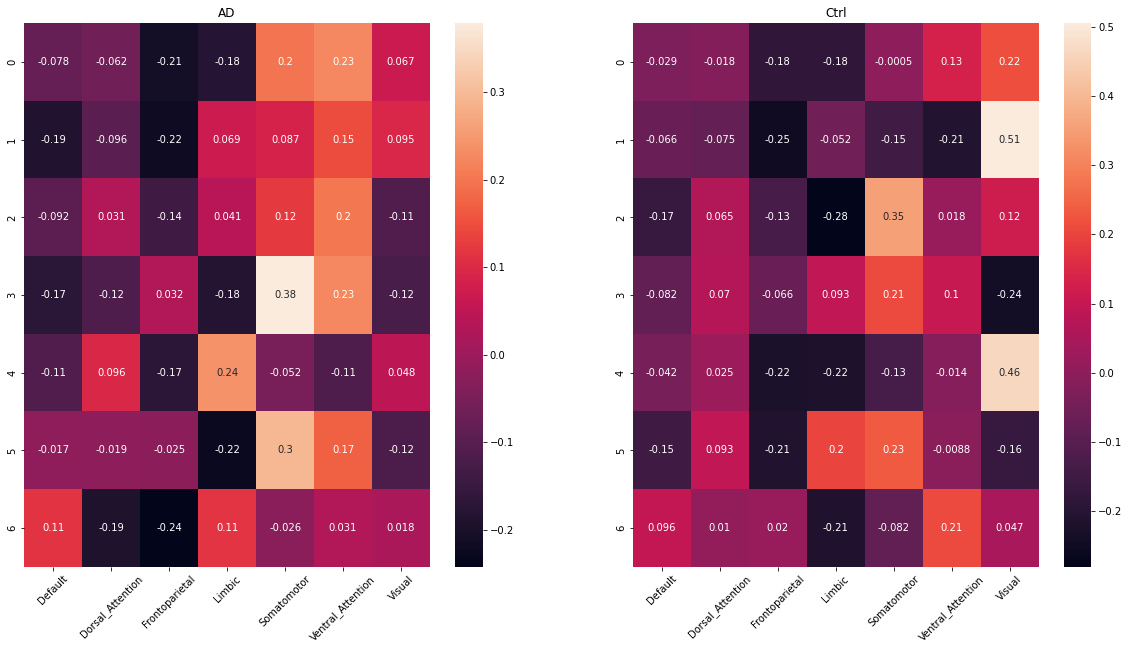

In [27]:
plt.figure(figsize=[20, 10])
plt.subplot(121)
sns.heatmap(ADcorrsCens, annot=True)
plt.title("AD")
plt.xticks(np.arange(7)+0.5, rowNames, rotation=45)

plt.subplot(122)
sns.heatmap(CtrlcorrsCens, annot=True)
plt.title("Ctrl")
_ =  plt.xticks(np.arange(7)+0.5, rowNames, rotation=45)

#### Clustering wU after minmax

In [172]:
wUlabs = np.concatenate([np.ones(wUADAll.shape[1]),np.zeros(wUCtrlAll.shape[1])])
wUAll = np.concatenate([wUADAll, wUCtrlAll], axis=1)
dwellAll = np.concatenate([dwellADAll, dwellCtrlAll])
wUlabsRaw = np.array(["AD"] * wUADAll.shape[1] + ["Control"] * wUCtrlAll.shape[1])
wUAllMM = (wUAll - wUAll.min(axis=0))/(wUAll.max(axis=0)-wUAll.min(axis=0))

In [173]:
wUAllnormed = wUAll/np.linalg.norm(wUAll, axis=0)

In [174]:
cluAll = KMeans(n_clusters=2, random_state=0).fit(wUAllMM.T)
#cluAll = AgglomerativeClustering(n_clusters=2).fit(wUAllMM.T)
#cluAll = SpectralClustering(n_clusters=2, random_state=0).fit(wUAllMM.T)
cTb = np.array(pd.crosstab(wUlabs, cluAll.labels_))
OR, pv = fisher_exact(cTb)
pStr = f"The odds ratio between control and AD groups is {OR:.3f}, the pvalue of the fisher exact test is {pv:.3f}."
print(pStr)

pd.crosstab(wUlabsRaw, cluAll.labels_)

The odds ratio between control and AD groups is 0.628, the pvalue of the fisher exact test is 0.004.


col_0      0    1
row_0            
AD       154  128
Control  164  217

In [175]:
cluAll = KMeans(n_clusters=7, random_state=0).fit(wUAllMM.T)
#cluAll = AgglomerativeClustering(n_clusters=7).fit(wUAllMM.T)
#cluAll = SpectralClustering(n_clusters=7, random_state=0).fit(wUAllMM.T)
cTb = np.array(pd.crosstab(wUlabs, cluAll.labels_))
chi2, pv, _, _ = chi2_contingency(cTb)
pStr = f"The chisq stat is {chi2:.3f}, the pvalue of the test is {pv:.3f}."
print(pStr)
pd.crosstab(wUlabsRaw, cluAll.labels_)

The chisq stat is 32.371, the pvalue of the test is 0.000.


col_0     0   1   2   3   4   5   6
row_0                              
AD       43  41  38  29  30  58  43
Control  40  49  59  69  69  34  61

##### R spectral clustering (I do not use it)

In [31]:
from rpy2 import robjects as robj
r = robj.r
Rstr = """

spectral_clustering <- function(X, # matrix of data points
                                nn = 10, # the k nearest neighbors to consider
                                n_eig = 2) # m number of eignenvectors to keep
{
  mutual_knn_graph <- function(X, nn = 10)
  {
    D <- as.matrix( dist(X) ) # matrix of euclidean distances between data points in X
    
    # intialize the knn matrix
    knn_mat <- matrix(0,
                      nrow = nrow(X),
                      ncol = nrow(X))
    
    # find the 10 nearest neighbors for each point
    for (i in 1: nrow(X)) {
      neighbor_index <- order(D[i,])[2:(nn + 1)]
      knn_mat[i,][neighbor_index] <- 1 
    }
   
    # Now we note that i,j are neighbors iff K[i,j] = 1 or K[j,i] = 1 
    knn_mat <- knn_mat + t(knn_mat) # find mutual knn
    
    knn_mat[ knn_mat == 2 ] = 1
    
    return(knn_mat)
  }
  
  graph_laplacian <- function(W, normalized = TRUE)
  {
    stopifnot(nrow(W) == ncol(W)) 
    
    g = colSums(W) # degrees of vertices
    n = nrow(W)
    
    if(normalized)
    {
      D_half = diag(1 / sqrt(g) )
      return( diag(n) - D_half %*% W %*% D_half )
    }
    else
    {
      return( diag(g) - W )
    }
  }
  
  W = mutual_knn_graph(X) # 1. matrix of similarities
  L = graph_laplacian(W) # 2. compute graph laplacian
  ei = eigen(L, symmetric = TRUE) # 3. Compute the eigenvectors and values of L
  n = nrow(L)
  return(ei$vectors[,(n - n_eig):(n - 1)]) # return the eigenvectors of the n_eig smallest eigenvalues

}

"""

r(Rstr)

RSpeCluFn = r["spectral_clustering"]
RwUAllT = r["matrix"](robj.FloatVector(np.ascontiguousarray(wUAll.T.reshape(-1))), nrow=wUAll.shape[1], byrow=True)
wUAllT_Sc = np.array(RSpeCluFn(RwUAllT, n_eig=20))

In [32]:
cluAll1 = KMeans(n_clusters=2, random_state=0).fit(wUAllT_Sc)
elabs = cluAll1.labels_

cTb = np.array(pd.crosstab(wUlabs, elabs))
OR, pv = fisher_exact(cTb)
pStr = f"The odds ratio between control and AD groups is {OR:.3f}, the pvalue of the fisher exact test is {pv:.3f}."
print(pStr)

pd.crosstab(wUlabsRaw, elabs)

The odds ratio between control and AD groups is 0.434, the pvalue of the fisher exact test is 0.044.


col_0      0   1
row_0           
AD       274   8
Control  357  24

In [33]:
cluAll1 = KMeans(n_clusters=3, random_state=0).fit(wUAllT_Sc)
cTb = np.array(pd.crosstab(wUlabs, cluAll1.labels_))
chi2, pv, _, _ = chi2_contingency(cTb)
pStr = f"The chisq stat is {chi2:.3f}, the pvalue of the test is {pv:.3f}."
print(pStr)
pd.crosstab(wUlabsRaw, cluAll1.labels_)

The chisq stat is 33.125, the pvalue of the test is 0.000.


col_0      0    1   2
row_0                
AD       200   45  37
Control  265  105  11

12.667965779467679 9.857469969969967
14.760037878787879 9.909564860426931


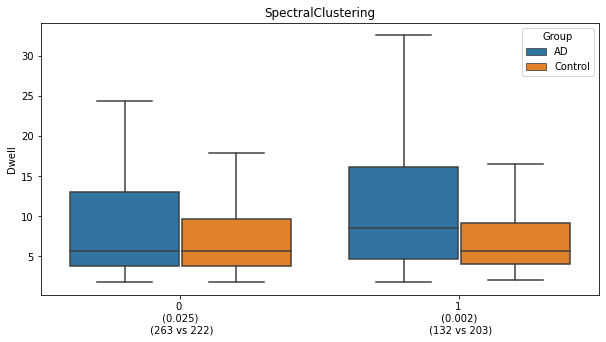

In [949]:
cluAll1 = KMeans(n_clusters=2, random_state=0).fit(wUAllT_Sc)
elabsSC = cluAll1.labels_
cluDFSC  = pd.DataFrame({"Dwell": dwellAll, "elabs": elabsSC, "Group":["AD"]*len(dwellADAll)+["Control"]*len(dwellCtrlAll)})

                       
xticklabsSC = []
for ix in range(np.max(elabsSC)+1):
    curAD = cluDFSC[(cluDFSC["elabs"]==ix) & (cluDFSC["Group"]=="AD")]
    curCtrl = cluDFSC[(cluDFSC["elabs"]==ix) & (cluDFSC["Group"]=="Control")]
    print(np.mean(curAD["Dwell"]), np.mean(curCtrl["Dwell"]))
    restt = scipy.stats.ttest_ind(curAD["Dwell"], curCtrl["Dwell"])
    resrs = scipy.stats.ranksums(curAD["Dwell"], curCtrl["Dwell"])
    resks = scipy.stats.kstest(curAD["Dwell"], curCtrl["Dwell"])
    xticklabsSC.append(f"{ix} \n ({restt.pvalue:.3f}) \n ({len(curAD)} vs {len(curCtrl)})")
    

plt.figure(figsize=[10, 5])
plt.title("SpectralClustering")
sns.boxplot(x="elabs", y="Dwell", hue="Group", data=cluDFSC, showfliers=False, order=np.arange(np.max(elabsSC)+1))
#sns.violinplot(x="elabs", y="Dwell", hue="ClusterMethod", data=cluDFBoth, split=True)
plt.xlabel("")
_ = plt.xticks(np.arange(np.max(elabsSC)+1), xticklabsSC)

#### PCA Kmeans

32


Text(0.5, 0, 'Num comps')

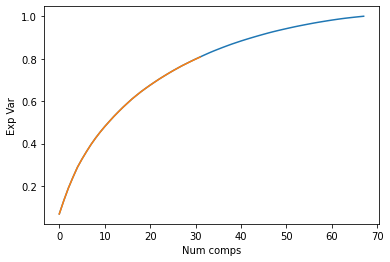

In [176]:
# select ncomp for PCA
perComp = 0.8
pca = PCA(n_components=wUAllMM.shape[0], random_state=0)
pcafit = pca.fit(wUAllMM.T)
cmVs = np.cumsum(pcafit.explained_variance_ratio_)

nComp =  np.where(cmVs>=perComp)[0][0] + 1
plt.plot(np.cumsum(pcafit.explained_variance_ratio_))
plt.ylabel("Exp Var")
plt.xlabel("Num comps")
print(nComp)

# PCA first 
pca = PCA(n_components=nComp, random_state=0)
pcafit = pca.fit(wUAllMM.T)
plt.plot(np.cumsum(pcafit.explained_variance_ratio_))
plt.ylabel("Exp Var")
plt.xlabel("Num comps")

In [177]:
rdwUAll = pcafit.transform(wUAllMM.T)
cluAll = KMeans(n_clusters=2, random_state=0).fit(rdwUAll)
elabs = cluAll.labels_

cTb = np.array(pd.crosstab(wUlabs, elabs))
OR, pv = fisher_exact(cTb)
pStr = f"The odds ratio between control and AD groups is {OR:.3f}, the pvalue of the fisher exact test is {pv:.3f}."
print(pStr)

pd.crosstab(wUlabsRaw, elabs)

The odds ratio between control and AD groups is 1.509, the pvalue of the fisher exact test is 0.010.


col_0      0    1
row_0            
AD       128  154
Control  212  169

In [178]:
cluAll = KMeans(n_clusters=4, random_state=0).fit(rdwUAll)
elabs = cluAll.labels_

cTb = np.array(pd.crosstab(wUlabs, elabs))
chi2, pv, _, _ = chi2_contingency(cTb)
pStr = f"The chisq stat is {chi2:.3f}, the pvalue of the test is {pv:.3f}."
print(pStr)
pd.crosstab(wUlabsRaw, elabs)

The chisq stat is 17.496, the pvalue of the test is 0.001.


col_0     0   1    2    3
row_0                    
AD       78  51   93   60
Control  70  78  104  129

##### Choose the n of clusters by BIC

In [179]:
def KmeanBIC(kmCluObj, Cn=1):
    nclu = kmCluObj.n_clusters
    nsps = len(kmCluObj.labels_)
    nDim = kmCluObj.cluster_centers_.shape[1]
    log_lik = np.log(kmCluObj.inertia_/nsps/nDim)
    BIC = log_lik + Cn*np.log(np.log(nsps*nDim))*np.log(nsps)*(nclu-1)/nsps
    return BIC
    

3


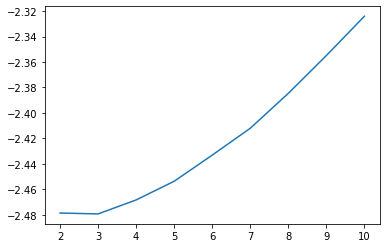

In [180]:
n_clus = list(range(2, 11))
BICs = []
for n_clu in n_clus:
    curClu = KMeans(n_clusters=n_clu, random_state=0).fit(rdwUAll)
    BICs.append(KmeanBIC(curClu, Cn=2))
plt.plot(n_clus, BICs)
ncluOpt = n_clus[np.argmin(BICs)]
print(ncluOpt)

In [140]:
# only to find the sig parts
cluAll = KMeans(n_clusters=ncluOpt, random_state=0).fit(rdwUAll)
elabs = cluAll.labels_
ords = np.arange(np.max(elabs)+1)
cluMeans = []
for curOrd in ords:
    curVec = wUAll.T[elabs==curOrd, :].mean(axis=0)
    print(curOrd, np.array(regionNames)[np.array(minmax(curVec))>0.85])

0 ['L-Isthmuscingulate' 'L-Lingual' 'L-Pericalcarine' 'R-Isthmuscingulate'
 'R-Postcentral' 'R-Posteriorcingulate' 'R-Precuneus']
1 ['L-Medialorbitofrontal' 'R-Lingual']
2 ['L-Caudalanteriorcingulate' 'R-Caudalanteriorcingulate']


In [181]:
cluAll = KMeans(n_clusters=ncluOpt, random_state=0).fit(rdwUAll)
elabs = cluAll.labels_
ords = np.arange(np.max(elabs)+1)
cluMeans = []
for curOrd in ords:
    curVec = minmax(wUAllMM.T[elabs==curOrd, :].mean(axis=0))
    curVec[curVec <=0.5] = 0
    outVec = U2BrainVec(reorderU(curVec))
    # note that the order of the files is not sorted by p value 
    np.savetxt(f"./brainPlotFils/PCA_KMTrunc_{len(ords)}_{curOrd}.txt", outVec)
    pd.DataFrame({"Name": regionNames, "Vec": curVec}).to_csv(f"./brainPlotFils/PCA_KMTrunc_{len(ords)}_{curOrd}.csv", index=False)
    
    idxAD = np.bitwise_and(wUlabs==1, elabs==curOrd)
    idxCtrl  = np.bitwise_and(wUlabs==0, elabs==curOrd)
    curVecAD = minmax(wUAllMM.T[idxAD, :].mean(axis=0))
    curVecAD[curVecAD <=0.55] = 0
    curVecCtrl = minmax(wUAllMM.T[idxCtrl, :].mean(axis=0))
    curVecCtrl[curVecCtrl <=0.55] = 0
    
    
    outVecAD = U2BrainVec(reorderU(curVecAD))
    np.savetxt(f"./brainPlotFils/PCA_KMADTrunc_{len(ords)}_{curOrd}.txt", outVecAD)
    pd.DataFrame({"Name": regionNames, "Vec": curVecAD}).to_csv(f"./brainPlotFils/PCA_KMADTrunc_{len(ords)}_{curOrd}.csv", index=False)
    
    outVecCtrl = U2BrainVec(reorderU(curVecCtrl))
    np.savetxt(f"./brainPlotFils/PCA_KMCtrlTrunc_{len(ords)}_{curOrd}.txt", outVecCtrl)
    pd.DataFrame({"Name": regionNames, "Vec": curVecCtrl}).to_csv(f"./brainPlotFils/PCA_KMCtrlTrunc_{len(ords)}_{curOrd}.csv", index=False)
    
    # pDatAD = wUAllMM.T[idxAD, :]
    # pDatCtrl = wUAllMM.T[idxCtrl, :]
    # curPvs = np.array([scipy.stats.ttest_ind(pDatAD[:, ix], pDatCtrl[:, ix], equal_var=False).pvalue for ix in range(68)]) 
    # #curSigROIs = (curPvs <= 0.05/68) * 1
    # sigInds = np.sort(curPvs) < (0.20 * np.arange(1, 69)/68)
    # curSigROIs = sigInds[np.argsort(np.argsort(curPvs))] * 1
    # outSigROIs = U2BrainVec(reorderU(curSigROIs))
    # np.savetxt(f"./brainPlotFils/PCA_KMSig_{len(ords)}_{curOrd}_20.txt", outSigROIs)
    # pd.DataFrame({"Name": regionNames, "Vec": curSigROIs}).to_csv(f"./brainPlotFils/PCA_KMSig_{len(ords)}_{curOrd}.csv", index=False)
    
    curVecAD = wUAllMM.T[idxAD, :].mean(axis=0)
    curVecCtrl = wUAllMM.T[idxCtrl, :].mean(axis=0)
    curVecDiff = minmax2(curVecAD - curVecCtrl)
    curVecDiff[np.abs(curVecDiff)<=0.55] = 0
    outVecDiff = U2BrainVec(reorderU(curVecDiff))
    np.savetxt(f"./brainPlotFils/PCA_KMDiffTrunc_{len(ords)}_{curOrd}.txt", outVecDiff)
    pd.DataFrame({"Name": regionNames, "Vec": curVecDiff}).to_csv(f"./brainPlotFils/PCA_KMDiffTrunc_{len(ords)}_{curOrd}.csv", index=False)

In [182]:
for curOrd in [0, 1, 2]:
    curVec = minmax(wUAllMM.T[elabs==curOrd, :].mean(axis=0))
    print(np.quantile(curVec, 0.90))

0.688591310310958
0.6257523646189971
0.4859530727839951


In [41]:
# wU diff between AD and ctrl brain
vecADAll = wUAll.T[wUlabs==1, :].mean(axis=0)
vecCtrlAll = wUAll.T[wUlabs==0, :].mean(axis=0)
vecDiffAll = np.abs(vecADAll-vecCtrlAll)
#vecDiffAll = np.abs(minmax(vecADAll)-minmax(vecCtrlAll))
outVecDiffAll = U2BrainVec(reorderU(minmax(vecDiffAll)))

halfOutVecDiffAll = U2BrainVec(reorderU(halfMinmax(vecDiffAll)))

np.savetxt(f"./brainPlotFils/wUDiffAll.txt", outVecDiffAll)
np.savetxt(f"./brainPlotFils/wUDiffAllHalf.txt", halfOutVecDiffAll)
pd.DataFrame({"Name": regionNames, "Vec": minmax(vecDiffAll)}).to_csv(f"./brainPlotFils/wUDiffAll.csv", index=False)
pd.DataFrame({"Name": regionNames, "Vec": halfMinmax(vecDiffAll)}).to_csv(f"./brainPlotFils/wUDiffAllHalf.csv", index=False)

In [42]:
#wUmean between AD and ctrl
vecADwUmean = np.array([fs.wUmeanAll for fs in fsAD]).mean(axis=0)
vecCtrlwUmean = np.array([fs.wUmeanAll for fs in fsCtrl]).mean(axis=0)
vecDiffwUmean = np.abs(vecADwUmean-vecCtrlwUmean)
#vecDiffwUmean = np.abs(minmax(vecADwUmean)-minmax(vecCtrlwUmean))
outVecDiffwUmean = U2BrainVec(reorderU(minmax(vecDiffwUmean)))

np.savetxt(f"./brainPlotFils/wUDiffwUmean.txt", outVecDiffwUmean)
pd.DataFrame({"Name": regionNames, "Vec": minmax(vecDiffwUmean)}).to_csv(f"./brainPlotFils/wUDiffwUmean.csv", index=False)

In [183]:
def corrFn(x):
    resVs = []
    for ix in range(7):
        resV = scipy.stats.pearsonr(fcRarrMM[ix, :], x)
        resVs.append(resV)
    resVs = np.array(resVs)
    res = pd.DataFrame({
        "Corr": resVs[:, 0], 
        "Pv": resVs[:, 1]})
    res.index = fcR.index
    return res

In [184]:
cluAll = KMeans(n_clusters=ncluOpt, random_state=0).fit(rdwUAll)
oCens = pcafit.inverse_transform(cluAll.cluster_centers_)
elabs = cluAll.labels_
ords = np.arange(np.max(elabs)+1)
cluMeans = []
for curOrd in ords:
    idxAD = np.bitwise_and(wUlabs==1, elabs==curOrd)
    idxCtrl  = np.bitwise_and(wUlabs==0, elabs==curOrd)
    curVecAD = wUAll.T[idxAD, :].mean(axis=0)
    curVecCtrl = wUAll.T[idxCtrl, :].mean(axis=0)
    curVec = wUAll.T[elabs==curOrd, :].mean(axis=0)
    print(corrFn(minmax(curVec)))


                       Corr        Pv
Unnamed: 0                           
Default           -0.155592  0.205158
Dorsal_Attention  -0.020985  0.865121
Frontoparietal    -0.331301  0.005785
Limbic            -0.308772  0.010409
Somatomotor        0.250893  0.039047
Ventral_Attention  0.080366  0.514736
Visual             0.328318  0.006268
                       Corr        Pv
Unnamed: 0                           
Default           -0.006016  0.961169
Dorsal_Attention  -0.117221  0.341098
Frontoparietal    -0.315124  0.008859
Limbic             0.245393  0.043696
Somatomotor       -0.078185  0.526243
Ventral_Attention -0.014644  0.905650
Visual             0.083376  0.499061
                       Corr        Pv
Unnamed: 0                           
Default           -0.022027  0.858493
Dorsal_Attention   0.004081  0.973651
Frontoparietal     0.044836  0.716565
Limbic            -0.197684  0.106113
Somatomotor        0.112581  0.360683
Ventral_Attention  0.374231  0.001667
Visual      

##### Non add dwell of the same subject together

In [58]:
nclu = ncluOpt
cluAll = KMeans(n_clusters=nclu, random_state=0).fit(rdwUAll)
elabsKM = cluAll.labels_
cluDFKM  = pd.DataFrame({"Dwell": dwellAll, "elabs": elabsKM, "Group":["AD"]*len(dwellADAll)+["Control"]*len(dwellCtrlAll)})

xticklabsKM = []
pvsKM = []
for ix in range(np.max(elabsKM)+1):
    curAD = cluDFKM[(cluDFKM["elabs"]==ix) & (cluDFKM["Group"]=="AD")]
    curCtrl = cluDFKM[(cluDFKM["elabs"]==ix) & (cluDFKM["Group"]=="Control")]
    restt = scipy.stats.ttest_ind(curAD["Dwell"], curCtrl["Dwell"], equal_var=False)
    resrs = scipy.stats.ranksums(curAD["Dwell"], curCtrl["Dwell"])
    resks = scipy.stats.kstest(curAD["Dwell"], curCtrl["Dwell"])
    pv = restt.pvalue
    pvsKM.append(pv)
    xticklabsKM.append(f"Cluster {ix+1} \n ({pv:.3f}) \n ({len(curAD)} vs {len(curCtrl)})")
    
# ignore orignal cluster idx, i.e.,  sort cluster index by pvalue
xticklabsKM = []
for ix in range(np.max(elabsKM)+1):
    curAD = cluDFKM[(cluDFKM["elabs"]==ix) & (cluDFKM["Group"]=="AD")]
    curCtrl = cluDFKM[(cluDFKM["elabs"]==ix) & (cluDFKM["Group"]=="Control")]
    restt = scipy.stats.ttest_ind(curAD["Dwell"], curCtrl["Dwell"], equal_var=False)
    resrs = scipy.stats.ranksums(curAD["Dwell"], curCtrl["Dwell"])
    resks = scipy.stats.kstest(curAD["Dwell"], curCtrl["Dwell"])
    pv = restt.pvalue
    xticklabsKM.append(f"Cluster {np.argsort(np.argsort(pvsKM))[ix]+1}")
    #xticklabsKM.append(f"Cluster {np.argsort(np.argsort(pvsKM))[ix]+1} \n ({pv:.3f}) \n ({len(curAD)} vs {len(curCtrl)})")
                       


txty, txth, txtcol = 65, 1, "k"
txtxdlt = 0.2
plt.figure(figsize=[15, 5], dpi=1200)
#plt.title("Kmeans")
sns.boxplot(x="elabs", y="Dwell", hue="Group", data=cluDFKM, showfliers=False, order=np.argsort(pvsKM), 
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
#sns.violinplot(x="elabs", y="Dwell", hue="ClusterMethod", data=cluDFBoth, split=True)
plt.xlabel("")
for ix in range(np.max(elabsKM)+1):
    txtx1, txtx2 = ix-txtxdlt, ix+txtxdlt
    plt.plot([txtx1, txtx1, txtx2, txtx2], [txty, txty+txth, txty+txth, txty], lw=1.5, c=txtcol)
    plt.text((txtx1+txtx2)*.5, txty+txth+0.5, f"P-value:{np.sort(pvsKM)[ix]:.3f}", ha='center', va='bottom', color=txtcol)
plt.legend(loc="upper left")
plt.ylim([0, 70])
plt.ylabel("Dwell times", fontsize=20)
_ = plt.xticks(np.arange(np.max(elabsKM)+1), np.array(xticklabsKM)[np.argsort(pvsKM)], fontsize=20)

plt.savefig(f"./plots/boxplot_wUKmeans_{nclu}NoOrder.jpg", bbox_inches='tight')
#plt.savefig(f"./plots/boxplot_wUKmeans_{nclu}.jpg", bbox_inches='tight')

In [46]:
elabsKMused = elabsKM
cluIdxMap = np.argsort(np.argsort(pvsKM))

In [47]:
print(pvsKM,  cluIdxMap)

[0.12488597318060916, 0.026796035918569543, 0.03217312670447832] [2 0 1]


In [77]:
cluDFKM  = pd.DataFrame({"Dwell": dwellAll, "elabs": elabsKM, "Group":["AD"]*len(dwellADAll)+["Control"]*len(dwellCtrlAll)})

In [79]:
cluDFKM.groupby(["Group", "elabs"]).describe()

Dwell                                                       \
               count       mean        std       min       25%        50%   
Group   elabs                                                               
AD      0      127.0  17.110105  18.061199  2.650000  5.000000   8.233333   
        1       88.0  23.963163  21.169182  2.641667  7.218750  13.679167   
        2       67.0  14.899378  16.688358  2.066667  5.000000   7.333333   
Control 0      162.0  14.030144  15.232002  1.733333  5.293750   8.116667   
        1      106.0  17.703066  17.097441  2.050000  5.675000   9.700000   
        2      113.0  10.005236  10.145244  2.083333  4.708333   7.066667   

                                
                     75%   max  
Group   elabs                   
AD      0      21.041667  60.0  
        1      41.258333  60.0  
        2      16.037500  60.0  
Control 0      14.933333  60.0  
        1      24.229167  60.0  
        2      10.533333  60.0

In [74]:
cluDFKM.groupby(["Group", "elabs"]).sum()

Dwell
Group   elabs             
AD      0      2172.983333
        1      2108.758333
        2       998.258333
Control 0      2272.883333
        1      1876.525000
        2      1130.591667

##### Transition matrix

In [48]:
flag = 0
transMatADCt = np.zeros((ncluOpt, ncluOpt))
for ix in range(len(fsAD)):
    curNDwell = len(fsAD[ix].dwell)
    curLabs = elabsKMused[flag:(flag+curNDwell)]
    curLabs = np.argsort(np.argsort(pvsKM))[curLabs] # adjust label to make it consistent with pval
    for ixx in range(len(curLabs)-1):
        fromState = curLabs[ixx]
        toState = curLabs[ixx+1]
        transMatADCt[fromState, toState] =  transMatADCt[fromState, toState] + 1
    flag = flag + curNDwell
    
transMatCtrlCt = np.zeros((ncluOpt, ncluOpt))
for ix in range(len(fsCtrl)):
    curNDwell = len(fsCtrl[ix].dwell)
    curLabs = elabsKMused[flag:(flag+curNDwell)]
    curLabs = np.argsort(np.argsort(pvsKM))[curLabs] # adjust label to make it consistent with pval
    for ixx in range(len(curLabs)-1):
        fromState = curLabs[ixx]
        toState = curLabs[ixx+1]
        transMatCtrlCt[fromState, toState] =  transMatCtrlCt[fromState, toState] + 1
    flag = flag + curNDwell

In [49]:
tMatCtrl = transMatCtrlCt/ transMatCtrlCt.sum(axis=1).reshape(-1, 1)
tMatAD = transMatADCt/ transMatADCt.sum(axis=1).reshape(-1, 1)

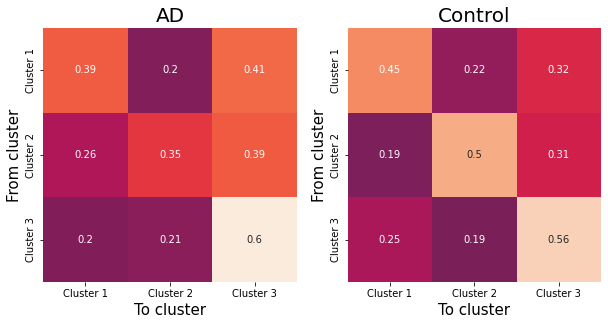

In [50]:
maxP = np.max([np.max(tMatAD), np.max(tMatCtrl)])
plt.figure(figsize=[10, 5])
plt.subplot(121)
sns.heatmap(tMatAD, annot=True, cbar=0, vmin=0, vmax=maxP, square=1)
plt.xticks([0.5, 1.5, 2.5], [f"Cluster {i+1}" for i in range(3)])
plt.yticks([0.5, 1.5, 2.5], [f"Cluster {i+1}" for i in range(3)])
plt.ylabel("From cluster", fontsize=15)
plt.xlabel("To cluster", fontsize=15)
plt.title("AD", fontsize=20)

plt.subplot(122)
sns.heatmap(tMatCtrl, annot=True, cbar=0, vmin=0, vmax=maxP, square=1)
plt.xticks([0.5, 1.5, 2.5], [f"Cluster {i+1}" for i in range(3)])
plt.yticks([0.5, 1.5, 2.5], [f"Cluster {i+1}" for i in range(3)])
plt.ylabel("From cluster", fontsize=15)
plt.xlabel("To cluster", fontsize=15)
plt.title("Control", fontsize=20)

plt.savefig(f"./plots/TransMat_wUKmeans_{nclu}NoOrder.jpg", bbox_inches='tight')

##### add dwell of the same subject together (not used now)

In [185]:
nclu = ncluOpt

In [193]:
# KM 
cluAll = KMeans(n_clusters=nclu, random_state=0).fit(rdwUAll)
elabsKM = cluAll.labels_

curDwell = []
curCluLabAD = []
curCluLabCtrl = []
flag = 0
curElabs = elabsKM
for ix in range(len(fsAD)):
    #curDwellCt = ddict(float)
    curDwellCt = {ix:0 for ix in range(nclu)}
    curMlabs = curElabs[flag:(flag+len(fsAD[ix].dwell))]
    for ixx, curMlab in enumerate(curMlabs):
        curDwellCt[curMlab] += fsAD[ix].dwell[ixx]
    allIts = list(curDwellCt.items())
    curDwell = curDwell + [ixxx[1] for ixxx in allIts]
    curCluLabAD = curCluLabAD + [ixxx[0] for ixxx in allIts]
    flag += len(fsAD[ix].dwell)

#flag = 0
for ix in range(len(fsCtrl)):
    curDwellCt = {ix:0 for ix in range(nclu)}
    #curDwellCt = ddict(float)
    curMlabs = curElabs[flag:(flag+len(fsCtrl[ix].dwell))]
    for ixx, curMlab in enumerate(curMlabs):
        curDwellCt[curMlab] += fsCtrl[ix].dwell[ixx]
    allIts = list(curDwellCt.items())
    curDwell = curDwell + [ixxx[1] for ixxx in allIts]
    curCluLabCtrl = curCluLabCtrl + [ixxx[0] for ixxx in allIts]
    flag += len(fsCtrl[ix].dwell)

cluDFKM  = pd.DataFrame({"Dwell": curDwell, "elabs": np.concatenate([curCluLabAD, curCluLabCtrl]), 
                         "Group":["AD"]*len(curCluLabAD)+["Control"]*len(curCluLabCtrl)})

xticklabsKM = []
pvsKM = []
for ix in range(np.max(elabsKM)+1):
    curAD = cluDFKM[(cluDFKM["elabs"]==ix) & (cluDFKM["Group"]=="AD")]
    curCtrl = cluDFKM[(cluDFKM["elabs"]==ix) & (cluDFKM["Group"]=="Control")]
    restt = scipy.stats.ttest_ind(curAD["Dwell"], curCtrl["Dwell"])
    resrs = scipy.stats.ranksums(curAD["Dwell"], curCtrl["Dwell"])
    resks = scipy.stats.kstest(curAD["Dwell"], curCtrl["Dwell"])
    pv = restt.pvalue
    pvsKM.append(pv)
    xticklabsKM.append(f"{ix} \n ({pv:.3f}) \n ({len(curAD)} vs {len(curCtrl)})")

In [199]:
# GM
cluAll = GaussianMixture(n_components=nclu, random_state=0).fit(rdwUAll)
elabsGM = cluAll.predict(rdwUAll)

curDwell = []
curCluLabAD = []
curCluLabCtrl = []
flag = 0
curElabs = elabsGM
for ix in range(len(fsAD)):
    #curDwellCt = ddict(float)
    curDwellCt = {ix:0 for ix in range(nclu)}
    curMlabs = curElabs[flag:(flag+len(fsAD[ix].dwell))]
    for ixx, curMlab in enumerate(curMlabs):
        curDwellCt[curMlab] += fsAD[ix].dwell[ixx]
    allIts = list(curDwellCt.items())
    curDwell = curDwell + [ixxx[1] for ixxx in allIts]
    curCluLabAD = curCluLabAD + [ixxx[0] for ixxx in allIts]
    flag += len(fsAD[ix].dwell)

#flag = 0
for ix in range(len(fsCtrl)):
    #curDwellCt = ddict(float)
    curDwellCt = {ix:0 for ix in range(nclu)}
    curMlabs = curElabs[flag:(flag+len(fsCtrl[ix].dwell))]
    for ixx, curMlab in enumerate(curMlabs):
        curDwellCt[curMlab] += fsCtrl[ix].dwell[ixx]
    allIts = list(curDwellCt.items())
    curDwell = curDwell + [ixxx[1] for ixxx in allIts]
    curCluLabCtrl = curCluLabCtrl + [ixxx[0] for ixxx in allIts]
    flag += len(fsCtrl[ix].dwell)

cluDFGM  = pd.DataFrame({"Dwell": curDwell, "elabs": np.concatenate([curCluLabAD, curCluLabCtrl]), 
                         "Group":["AD"]*len(curCluLabAD)+["Control"]*len(curCluLabCtrl)})

pvsGM = []
xticklabsGM = []
for ix in range(np.max(elabsGM)+1):
    curAD = cluDFGM[(cluDFGM["elabs"]==ix) & (cluDFGM["Group"]=="AD")]
    curCtrl = cluDFGM[(cluDFGM["elabs"]==ix) & (cluDFGM["Group"]=="Control")]
    restt = scipy.stats.ttest_ind(curAD["Dwell"], curCtrl["Dwell"])
    resrs = scipy.stats.ranksums(curAD["Dwell"], curCtrl["Dwell"])
    resks = scipy.stats.kstest(curAD["Dwell"], curCtrl["Dwell"])
    pv = resrs.pvalue
    pvsGM.append(pv)
    xticklabsGM.append(f"{ix} \n ({pv:.3f}) \n ({len(curAD)} vs {len(curCtrl)})")

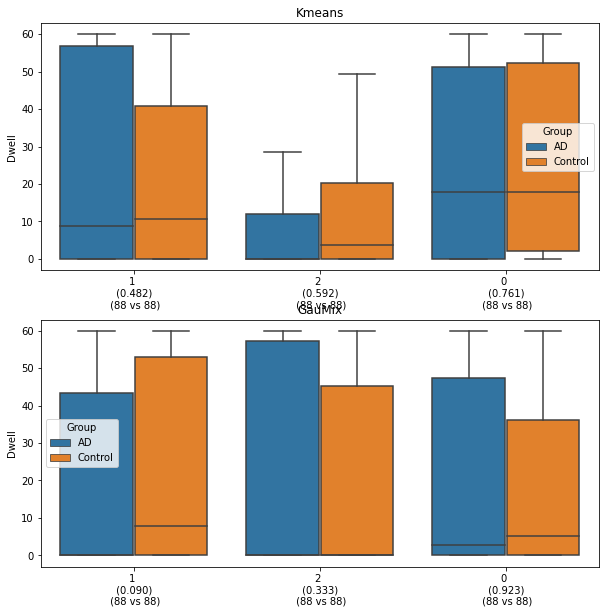

In [200]:
plt.figure(figsize=[10, 10])
plt.subplot(211)
plt.title("Kmeans")
sns.boxplot(x="elabs", y="Dwell", hue="Group", data=cluDFKM, showfliers=False, order=np.argsort(pvsKM))
#sns.violinplot(x="elabs", y="Dwell", hue="ClusterMethod", data=cluDFBoth, split=True)
plt.xlabel("")
_ = plt.xticks(np.arange(np.max(elabsKM)+1), np.array(xticklabsKM)[np.argsort(pvsKM)])
plt.subplot(212)
plt.title("GauMix")
sns.boxplot(x="elabs", y="Dwell", hue="Group", data=cluDFGM, showfliers=False, order=np.argsort(pvsGM))
#sns.violinplot(x="elabs", y="Dwell", hue="ClusterMethod", data=cluDFBoth, split=True)
plt.xlabel("")
_ = plt.xticks(np.arange(np.max(elabsGM)+1), np.array(xticklabsGM)[np.argsort(pvsGM)])

#### Cluster on ctrl

In [494]:
wUADAllMM = (wUADAll- wUADAll.min(axis=0))/(wUADAll.max(axis=0)-wUADAll.min(axis=0))
wUCtrlAllMM = (wUCtrlAll- wUCtrlAll.min(axis=0))/(wUCtrlAll.max(axis=0)-wUCtrlAll.min(axis=0))


In [495]:
#wUCtrlAllMM = (wUCtrlAll- wUCtrlAll.mean(axis=1).reshape(-1, 1))/wUCtrlAll.std(axis=1).reshape(-1, 1)
#wUCtrlAllMM = wUCtrlAll

28


Text(0.5, 0, 'Num comps')

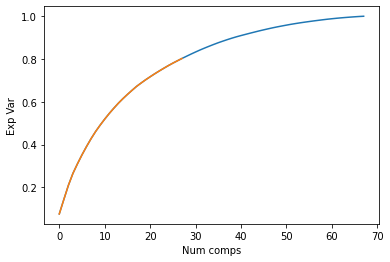

In [496]:
# select ncomp for PCA
perComp = 0.8
pca = PCA(n_components=wUCtrlAllMM.shape[0], random_state=0)
pcafit = pca.fit(wUCtrlAllMM.T)
cmVs = np.cumsum(pcafit.explained_variance_ratio_)

nComp =  np.where(cmVs>=perComp)[0][0] + 1
plt.plot(np.cumsum(pcafit.explained_variance_ratio_))
plt.ylabel("Exp Var")
plt.xlabel("Num comps")
print(nComp)

# PCA first 
pca = PCA(n_components=nComp, random_state=0)
pcafit = pca.fit(wUCtrlAllMM.T)
plt.plot(np.cumsum(pcafit.explained_variance_ratio_))
plt.ylabel("Exp Var")
plt.xlabel("Num comps")

2


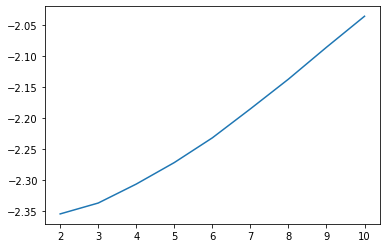

In [497]:
rdwUCtrlAll = pcafit.transform(wUCtrlAllMM.T)
n_clus = list(range(2, 11))
BICs = []
for n_clu in n_clus:
    curClu = KMeans(n_clusters=n_clu, random_state=0).fit(rdwUCtrlAll)
    BICs.append(KmeanBIC(curClu, Cn=2))
plt.plot(n_clus, BICs)
ncluOpt = n_clus[np.argmin(BICs)]
print(ncluOpt)

In [498]:
nclu = 3
#cluCtrlAll = SpectralClustering(n_clusters=3, random_state=0).fit(rdwUCtrlAll)
cluCtrlAll = KMeans(n_clusters=nclu, random_state=0).fit(rdwUCtrlAll)
labs_Ctrl = cluCtrlAll.labels_
np.unique(cluCtrlAll.labels_, return_counts=True)

(array([0, 1, 2], dtype=int32), array([142, 115, 124]))

In [499]:
clu_cens = cluCtrlAll.cluster_centers_
rdwUADAll = pcafit.transform(wUADAllMM.T)

In [500]:
dst_AD = []
for clu_cen in clu_cens:
    diff_ = rdwUADAll - clu_cen
    dst_AD.append(np.linalg.norm(diff_, axis=1))
dst_AD = np.array(dst_AD)
labs_AD = np.argmin(dst_AD, axis=0)
np.unique(labs_AD, return_counts=True)

(array([0, 1, 2]), array([ 96,  66, 120]))

In [501]:
# corr with connonical nets
org_clu_cens = pcafit.inverse_transform(clu_cens)
corrFn(org_clu_cens[0, :])

Corr        Pv
Unnamed: 0                           
Default           -0.040066  0.745635
Dorsal_Attention   0.009830  0.936589
Frontoparietal    -0.244542  0.044454
Limbic            -0.214333  0.079238
Somatomotor       -0.100911  0.412901
Ventral_Attention -0.045171  0.714539
Visual             0.462344  0.000072

In [502]:
# the paper may help
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8385433/
for ix in range(0, nclu):
    cur_vec = wUCtrlAllMM[:, labs_Ctrl==ix].mean(axis=-1)
    print(corrFn(cur_vec))

                       Corr        Pv
Unnamed: 0                           
Default           -0.040802  0.741124
Dorsal_Attention   0.011889  0.923340
Frontoparietal    -0.240410  0.048292
Limbic            -0.211191  0.083846
Somatomotor       -0.105688  0.391018
Ventral_Attention -0.043230  0.726309
Visual             0.460166  0.000079
                       Corr        Pv
Unnamed: 0                           
Default           -0.008818  0.943103
Dorsal_Attention  -0.077220  0.531380
Frontoparietal    -0.094405  0.443816
Limbic            -0.173700  0.156597
Somatomotor        0.183100  0.135031
Ventral_Attention  0.244833  0.044193
Visual            -0.051527  0.676456
                       Corr        Pv
Unnamed: 0                           
Default            0.039364  0.749946
Dorsal_Attention  -0.074276  0.547190
Frontoparietal    -0.179143  0.143819
Limbic             0.145266  0.237220
Somatomotor       -0.107351  0.383563
Ventral_Attention  0.090624  0.462363
Visual      

In [487]:
# dwell for each sub in AD
curDwellAD = []
curCluLabAD = []
flag = 0
curElabs = labs_AD
for ix in range(len(fsAD)):
    curDwellCt = {ix:0 for ix in range(nclu)}
    curMlabs = curElabs[flag:(flag+len(fsAD[ix].dwell))]
    for ixx, curMlab in enumerate(curMlabs):
        curDwellCt[curMlab] += fsAD[ix].dwell[ixx]
    allIts = list(curDwellCt.items())
    curDwellAD = curDwellAD + [ixxx[1] for ixxx in allIts]
    curCluLabAD = curCluLabAD + [ixxx[0] for ixxx in allIts]
    flag += len(fsAD[ix].dwell)

In [488]:
# dwell for each sub in Ctrl
curDwellCtrl = []
curCluLabCtrl = []
flag = 0
curElabs = labs_Ctrl
for ix in range(len(fsCtrl)):
    curDwellCt = {ix:0 for ix in range(nclu)}
    curMlabs = curElabs[flag:(flag+len(fsCtrl[ix].dwell))]
    for ixx, curMlab in enumerate(curMlabs):
        curDwellCt[curMlab] += fsCtrl[ix].dwell[ixx]
    allIts = list(curDwellCt.items())
    curDwellCtrl = curDwellCtrl + [ixxx[1] for ixxx in allIts]
    curCluLabCtrl = curCluLabCtrl + [ixxx[0] for ixxx in allIts]
    flag += len(fsCtrl[ix].dwell)

In [489]:
cluDF_ctrl  = pd.DataFrame({"Dwell": np.concatenate([curDwellAD, curDwellCtrl]),
                         "elabs": np.concatenate([curCluLabAD, curCluLabCtrl]), 
                         "Group":["AD"]*len(curCluLabAD)+["Control"]*len(curCluLabCtrl)})

pvs = []
xticklabs = []
for ix in range(nclu):
    curAD = cluDF_ctrl[(cluDF_ctrl["elabs"]==ix) & (cluDF_ctrl["Group"]=="AD")]
    curCtrl = cluDF_ctrl[(cluDF_ctrl["elabs"]==ix) & (cluDF_ctrl["Group"]=="Control")]
    restt = scipy.stats.ttest_ind(curAD["Dwell"], curCtrl["Dwell"])
    resrs = scipy.stats.ranksums(curAD["Dwell"], curCtrl["Dwell"])
    resks = scipy.stats.kstest(curAD["Dwell"], curCtrl["Dwell"])
    pv = resrs.pvalue
    pvs.append(pv)
    xticklabs.append(f"{ix} \n ({pv:.3f}) \n ({len(curAD)} vs {len(curCtrl)})")

In [490]:
cluDF_ctrl.groupby(["elabs", "Group"]).describe()

Dwell                                                        \
              count       mean        std  min  25%        50%        75%   
elabs Group                                                                 
0     AD       88.0  16.955492  22.679042  0.0  0.0   0.000000  34.893750   
      Control  88.0  22.251420  22.999964  0.0  0.0  12.779167  43.712500   
1     AD       88.0  17.237973  23.323862  0.0  0.0   0.000000  34.414583   
      Control  88.0  15.547538  21.256570  0.0  0.0   2.050000  29.764583   
2     AD       88.0  25.806534  24.790567  0.0  0.0  18.533333  60.000000   
      Control  88.0  22.201042  23.275210  0.0  0.0  15.254167  42.656250   

                     
                max  
elabs Group          
0     AD       60.0  
      Control  60.0  
1     AD       60.0  
      Control  60.0  
2     AD       60.0  
      Control  60.0

In [491]:
cluIdxMap = np.argsort(np.argsort(pvs))
print(pvs, cluIdxMap)

[0.025197482922696728, 0.9186932221470933, 0.16795059148694724] [0 2 1]


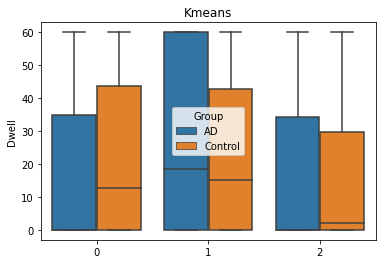

In [492]:
plt.title("Kmeans")
sns.boxplot(x="elabs", y="Dwell", hue="Group", data=cluDF_ctrl, showfliers=True, order=np.argsort(pvs))
#sns.violinplot(x="elabs", y="Dwell", hue="ClusterMethod", data=cluDFBoth, split=True)
plt.xlabel("")
_ = plt.xticks(np.arange(nclu), np.array(cluIdxMap)[np.argsort(pvs)])

In [372]:
#save the brain
for ix in list(range(nclu)):
    curVec = minmax(wUCtrlAllMM[:, labs_Ctrl==ix].mean(axis=-1))
    curVec[curVec <=0.55] = 0
    outVec = U2BrainVec(reorderU(curVec))
    curOrd = cluIdxMap[ix]
    # note that the order of the files is sorted by p value 
    np.savetxt(f"./brainPlotFils/ctrl_PCA_KMTrunc_{nclu}_{curOrd}.txt", outVec)
    #pd.DataFrame({"Name": regionNames, "Vec": curVec}).to_csv(f"./brainPlotFils/cltr_PCA_KMTrunc_{nclu}_{curOrd}.csv", index=False)
    

##### Reg with dwell 

In [360]:
cluDF_ctrl

Dwell  elabs    Group
0     0.000000      0       AD
1     0.000000      1       AD
2    60.000000      2       AD
3     0.000000      0       AD
4    60.000000      1       AD
..         ...    ...      ...
523   0.000000      1  Control
524  47.625000      2  Control
525  55.866667      0  Control
526   4.133333      1  Control
527   0.000000      2  Control

[528 rows x 3 columns]

#### More clustering

In [338]:
wUmeansAD = np.array([fs.wUmeanAll for fs in fsAD])
wUmeansCtrl = np.array([fs.wUmeanAll for fs in fsCtrl])
wUmeansAll = np.concatenate([wUmeansAD, wUmeansCtrl], axis=0).T
#wUmeansAll = wUmeansAD.T
wUmeansAllMM = (wUmeansAll - wUmeansAll.min(axis=0))/(wUmeansAll.max(axis=0)-wUmeansAll.min(axis=0))

28


Text(0.5, 0, 'Num comps')

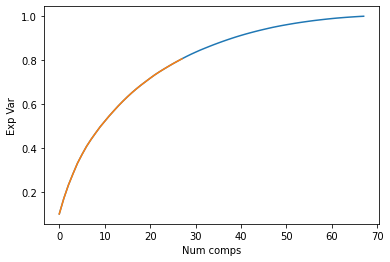

In [339]:
# select ncomp for PCA
perComp = 0.8
pca = PCA(n_components=wUmeansAllMM.shape[0], random_state=0)
pcafit = pca.fit(wUmeansAllMM.T)
cmVs = np.cumsum(pcafit.explained_variance_ratio_)

nComp =  np.where(cmVs>=perComp)[0][0] + 1
plt.plot(np.cumsum(pcafit.explained_variance_ratio_))
plt.ylabel("Exp Var")
plt.xlabel("Num comps")
print(nComp)

# PCA first 
pca = PCA(n_components=nComp, random_state=0)
pcafit = pca.fit(wUmeansAllMM.T)
plt.plot(np.cumsum(pcafit.explained_variance_ratio_))
plt.ylabel("Exp Var")
plt.xlabel("Num comps")

In [340]:
rdwUmeansAll = pcafit.transform(wUmeansAllMM.T)
cluAll = KMeans(n_clusters=3, random_state=0).fit(rdwUmeansAll)
elabs = cluAll.labels_
pd.crosstab(subTypLabs, elabs[:88])

col_0    0   1   2
row_0             
AD-LPA   5   7   3
AD-MEM  18  17  20
AD-PCA   4   5   8
NULL     0   1   0

In [341]:
wUmeanLabs = np.array([1]*88 + [0]*88)
#wUmeanLabs = np.array([1]*88)
ords = np.arange(np.max(elabs)+1)
cluMeans = []
for curOrd in ords:
    idxAD = np.bitwise_and(wUmeanLabs==1, elabs==curOrd)
    idxCtrl  = np.bitwise_and(wUmeanLabs==0, elabs==curOrd)
    curVecAD = wUmeansAll.T[idxAD, :].mean(axis=0)
    curVecCtrl = wUmeansAll.T[idxCtrl, :].mean(axis=0)
    curVec = wUmeansAll.T[elabs==curOrd, :].mean(axis=0)
    print(corrFn(minmax(curVec)))


                    Corr    Pv
Unnamed: 0                    
Default           -0.066 0.591
Dorsal_Attention   0.012 0.923
Frontoparietal    -0.187 0.127
Limbic            -0.168 0.170
Somatomotor       -0.013 0.917
Ventral_Attention  0.081 0.510
Visual             0.266 0.028
                    Corr    Pv
Unnamed: 0                    
Default           -0.149 0.227
Dorsal_Attention   0.031 0.804
Frontoparietal    -0.258 0.034
Limbic            -0.311 0.010
Somatomotor        0.266 0.028
Ventral_Attention  0.034 0.780
Visual             0.277 0.022
                    Corr    Pv
Unnamed: 0                    
Default           -0.010 0.938
Dorsal_Attention  -0.167 0.173
Frontoparietal    -0.283 0.019
Limbic             0.213 0.082
Somatomotor        0.124 0.313
Ventral_Attention  0.211 0.084
Visual            -0.182 0.138


#### Reg wU on CN (not used)

sample size is 68

In [97]:
OLSparassAD = []
for ix in range(wUADAll.shape[1]):
    curY = wUADAll[:, ix]
    curOLS = sm.OLS(curY, fcRarr.T )
    curOLSfit = curOLS.fit()
    OLSparassAD.append(curOLSfit.params)
OLSparassAD = np.array(OLSparassAD)

OLSparassCtrl = []
for ix in range(wUCtrlAll.shape[1]):
    curY = wUCtrlAll[:, ix]
    curOLS = sm.OLS(curY, fcRarr.T )
    curOLSfit = curOLS.fit()
    OLSparassCtrl.append(curOLSfit.params)
OLSparassCtrl = np.array(OLSparassCtrl)

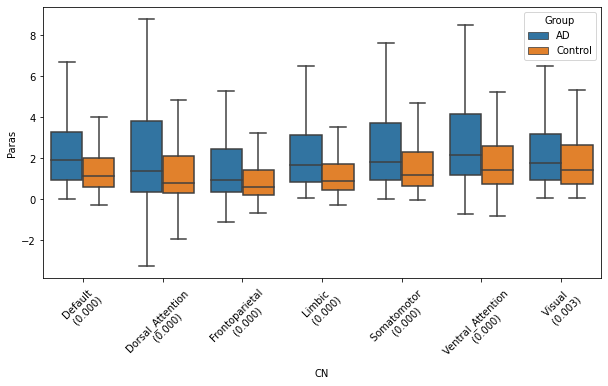

In [99]:
# Paras dist for each CN 
OLSparass = np.concatenate([OLSparassAD.reshape(-1), OLSparassCtrl.reshape(-1)])
CNLabs = rowNames * (OLSparassAD.shape[0]+OLSparassCtrl.shape[0])
grpLabs = ["AD"] *(OLSparassAD.shape[0]*7) +["Control"] *(OLSparassCtrl.shape[0]*7) 
OLSparasDF = pd.DataFrame({"Paras": OLSparass, "CN": CNLabs, "Group":grpLabs})

xticklabs = []
curDF = OLSparasDF
for nam in rowNames:
    curSubAD = curDF[(curDF["CN"] == nam) & (curDF["Group"] == "AD")]
    curSubCtrl = curDF[(curDF["CN"] == nam) & (curDF["Group"] == "Control")]
    restt = scipy.stats.ttest_ind(curSubAD["Paras"], curSubCtrl["Paras"])
    resrs = scipy.stats.ranksums(curSubAD["Paras"], curSubCtrl["Paras"])
    resks = scipy.stats.kstest(curSubAD["Paras"], curSubCtrl["Paras"])
    xticklabs.append(f"{nam} \n ({resks.pvalue:.3f})")
    
plt.figure(figsize=[10, 5])
low = np.mean(curDF["Paras"]) - 2* np.std(curDF["Paras"])
up = np.mean(curDF["Paras"]) + 2* np.std(curDF["Paras"])
sns.boxplot(x="CN", y="Paras", hue="Group", data=curDF,  order=rowNames, showfliers = False)
plt.xticks(np.arange(7), xticklabs)
_ = plt.xticks(rotation=45)

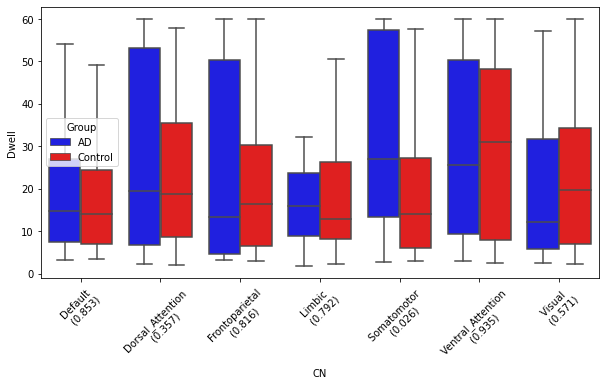

In [100]:
# dwell time for each CN with label by max parameter
curDNLAD = []
curDNLCtrl = []
curDwell = []

for ix in range(len(fsAD)):
    curDwellCt = ddict(float)
    curFs = fsAD[ix]
    curMlabs = []
    for ixx in range(curFs.wUAll.shape[1]):
        curY = curFs.wUAll[:, ixx]
        curOLS = sm.OLS(curY, fcRarr.T )
        curOLSfit = curOLS.fit()
        curMlabs.append(np.array(rowNames)[np.abs(curOLSfit.params).argmax()])
    for ixx, curMlab in enumerate(curMlabs):
        curDwellCt[curMlab] += curFs.dwell[ixx]
    allIts = list(curDwellCt.items())
    curDwell = curDwell + [ixxx[1] for ixxx in allIts]
    curDNLAD = curDNLAD + [ixxx[0] for ixxx in allIts]
    
for ix in range(len(fsCtrl)):
    curDwellCt = ddict(float)
    curFs = fsCtrl[ix]
    curMlabs = []
    for ixx in range(curFs.wUAll.shape[1]):
        curY = curFs.wUAll[:, ixx]
        curOLS = sm.OLS(curY, fcRarr.T )
        curOLSfit = curOLS.fit()
        curMlabs.append(np.array(rowNames)[np.abs(curOLSfit.params).argmax()])
    for ixx, curMlab in enumerate(curMlabs):
        curDwellCt[curMlab] += curFs.dwell[ixx]
    allIts = list(curDwellCt.items())
    curDwell = curDwell + [ixxx[1] for ixxx in allIts]
    curDNLCtrl = curDNLCtrl + [ixxx[0] for ixxx in allIts]
    
# below do not consider a subject have multiple segment for same label
# for ix in range(len(fsAD)):
#     curDwell = curDwell + list(fsAD[ix].dwell)
#     curFs = fsAD[ix]
#     for ixx in range(curFs.wUAll.shape[1]):
#         curY = curFs.wUAll[:, ixx]
#         curOLS = sm.OLS(curY, fcRarr.T )
#         curOLSfit = curOLS.fit()
#         curDNLAD.append(np.array(rowNames)[np.abs(curOLSfit.params).argmax()])
#     
# for ix in range(len(fsCtrl)):
#     curDwell = curDwell + list(fsCtrl[ix].dwell)
#     curFs = fsCtrl[ix]
#     for ixx in range(curFs.wUAll.shape[1]):
#         curY = curFs.wUAll[:, ixx]
#         curOLS = sm.OLS(curY, fcRarr.T )
#         curOLSfit = curOLS.fit()
#         curDNLCtrl.append(np.array(rowNames)[np.abs(curOLSfit.params).argmax()])
    
    
dwellDF = pd.DataFrame({"Dwell": curDwell, "CN": curDNLAD+curDNLCtrl, 
                        "Group": ["AD"]*len(curDNLAD) + ["Control"]*len(curDNLCtrl)})

xticklabs = []
for nam in rowNames:
    curSubAD = dwellDF[(dwellDF["CN"] == nam) & (dwellDF["Group"] == "AD")]
    curSubCtrl = dwellDF[(dwellDF["CN"] == nam) & (dwellDF["Group"] == "Control")]
    restt = scipy.stats.ttest_ind(curSubAD["Dwell"], curSubCtrl["Dwell"], equal_var=True)
    resrs = scipy.stats.ranksums(curSubAD["Dwell"], curSubCtrl["Dwell"])
    resks = scipy.stats.kstest(curSubAD["Dwell"], curSubCtrl["Dwell"])
    xticklabs.append(f"{nam} \n ({restt.pvalue:.3f})")
    
plt.figure(figsize=[10, 5])
sns.boxplot(x="CN", y="Dwell", hue="Group", data=dwellDF, showfliers=False, palette = {"AD":'blue', "Control":'red'}, order=rowNames)
plt.xticks(np.arange(7), xticklabs)
_ = plt.xticks(rotation=45)

### Imag part of eigen value (not used)

In [101]:
eigValImagAD = []
for ix in range(len(eigValsAD)):
    eigValImagAD.append(np.concatenate([list(tVal.imag) for tVal in eigValsAD[ix]]))
eigValImagAD = np.abs(np.concatenate(eigValImagAD))

eigValImagCtrl = []
for ix in range(len(eigValsCtrl)):
    eigValImagCtrl.append(np.concatenate([list(tVal.imag) for tVal in eigValsCtrl[ix]]))
eigValImagCtrl = np.abs(np.concatenate(eigValImagCtrl))

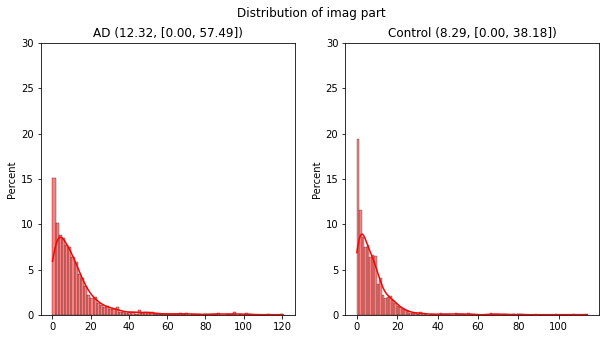

In [102]:
plt.figure(figsize=[10, 5])
plt.suptitle("Distribution of imag part")
plt.subplot(121)
plt.title(f"AD ({np.mean(eigValImagAD):.2f}, [{np.quantile(eigValImagAD, 0.025):.2f}, {np.quantile(eigValImagAD, 0.975):.2f}])")
sns.histplot(eigValImagAD, stat="percent", kde=1, color="red")
plt.xlabel("")
plt.ylim([0, 30])

plt.subplot(122)
plt.title(f"Control ({np.mean(eigValImagCtrl):.2f}, [{np.quantile(eigValImagCtrl, 0.025):.2f}, {np.quantile(eigValImagCtrl, 0.975):.2f}])")
sns.histplot(eigValImagCtrl, stat="percent", kde=1, color="red")
plt.ylim([0, 30])
plt.xlabel("")

#plt.savefig("./plots/eigValAbsImagDist.jpg", bbox_inches='tight')

In [103]:
restt = scipy.stats.ttest_ind(eigValImagAD, eigValImagCtrl)
resrs = scipy.stats.ranksums(eigValImagAD, eigValImagCtrl)
resks = scipy.stats.kstest(eigValImagAD, eigValImagCtrl)
print(
    f"The pvalue of t test is {restt.pvalue:.4f}, "
    f"The pvalue of rank sum test is {resrs.pvalue:.4f}, "
    f"The pvalue of ks test is {resks.pvalue:.4f}."
     )

The pvalue of t test is 0.0000, The pvalue of rank sum test is 0.0000, The pvalue of ks test is 0.0000.


## SubType analysis for AD

In [130]:
from scipy.stats import chi2_contingency
from sklearn.metrics import classification_report, f1_score, confusion_matrix

### Get Subtype labs for AD data

Note that we should use `kpAD` but in our case, we keep all the AD data, so we can ignore it.

In [129]:
RID_AD_labs = loadmat("./OtherFils/radid_AD.mat")["radid"].reshape(-1)
labs = [lab[0].split("A")[0] for lab in RID_AD_labs] # follow the correct order of the Mat data, 88 datasets
labMap = np.array(pd.read_excel('./OtherFils/ADlist_80_with_labels.xlsx')) # subtype, 80 datasets
P2RMap= np.array(pd.read_csv("./OtherFils/ADcomplete.csv")[["PID", "RID"]])[:88, :] # 88 datasets

In [131]:
col1 = np.array([6381,  13461,   15031,   17476,   18375,   18493,   18838,   19395,   21815,])
col2 = np.array(["AD-MEM",  "AD-MEM", "AD-MEM", "AD-PCA",  "AD-MEM", "AD-MEM", "AD-MEM", "AD-PCA",  "AD-MEM"])
addPID2Sub = np.array([col1, col2], dtype=np.object0).T

In [132]:
# put all the subtype info together
allSubType = []
for curIDs in P2RMap:
    PID, RID = curIDs
    addIdx = (addPID2Sub == PID).sum(axis=1, dtype=bool)
    orgIdx = (labMap == PID).sum(axis=1, dtype=bool)
    if PID != 18375:
        if orgIdx.sum() != 0:
            allSubType.append([PID, RID, labMap[orgIdx, -1][0]])
        elif addIdx.sum() != 0:
            allSubType.append([PID, RID, addPID2Sub[addIdx, -1][0]])
    else:
    # PID 18375 is skepical, so make it NULL
            allSubType.append([PID, RID, "NULL"])
    if orgIdx.sum() != 0 and  addIdx.sum() != 0:
        print(PID, RID, labMap[orgIdx, -1][0],  addPID2Sub[addIdx, -1][0])
allSubType = np.array(allSubType, dtype=np.object_)

18375 R2322 AD-MEM AD-MEM


In [133]:
# save the labs 
#np.savetxt("ADLabs87.txt", labs, fmt="%10s")
pd.DataFrame(labs).to_csv("RID_AD_labs.csv", index=False, header=False)
pd.DataFrame(allSubType).to_csv("./OtherFils/subTypesAll.csv", index=False, header=False)

In [134]:
subTypLabs = []
for lab in labs:
    idx = (allSubType== lab).sum(axis=1, dtype=bool)
    if idx.sum() != 0:
        subTypLabs.append(allSubType[idx, -1][0])
    else:
        subTypLabs.append("NULL")
subTypLabs = np.array(subTypLabs)

In [135]:
subTypLabsC = subTypLabs[subTypLabs!="NULL"]

###  Regression 

#### Logi model with ridge

class the three types

In [110]:
penalty = "l2"
fsName = ["r", "ncpts", "wUmeanAll"]
cFAD = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
    
    cFAD.append(cfAD)
cFAD = np.concatenate(cFAD, axis=1)
cFAD = cFAD[subTypLabs!="NULL"]
cFADstd = (cFAD- cFAD.mean(axis=0))/cFAD.std(axis=0)

In [111]:
Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4]
f1s = []
for C in Cs:
    eProbs = []
    loo = LeaveOneOut()
    for trIdxs, testIdxs in loo.split(cFADstd):
        clf = LogisticRegression(penalty=penalty, random_state=0, C=C)
        clf.fit(cFADstd[trIdxs, :], subTypLabsC[trIdxs])
        eProbs.append(clf.predict_proba(cFADstd[testIdxs, :]))
    eProbs = np.array(eProbs).squeeze()
    elabs = clf.classes_[eProbs.argmax(axis=1)]
    f1 = f1_score(subTypLabsC, elabs, average="weighted")
    f1s.append(f1)

In [112]:
optC = Cs[np.argmax(f1s)]
eProbs = []
loo = LeaveOneOut()
for trIdxs, testIdxs in loo.split(cFADstd):
    clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
    clf.fit(cFADstd[trIdxs, :], subTypLabsC[trIdxs])
    eProbs.append(clf.predict_proba(cFADstd[testIdxs, :]))
eProbs = np.array(eProbs).squeeze()
elabs = clf.classes_[eProbs.argmax(axis=1)]
f1 = f1_score(subTypLabsC, elabs, average="weighted")
print(classification_report(subTypLabsC, elabs))
pd.crosstab(subTypLabsC, elabs)

              precision    recall  f1-score   support

      AD-LPA       0.43      0.21      0.29        14
      AD-MEM       0.66      0.82      0.73        50
      AD-PCA       0.10      0.07      0.08        15

    accuracy                           0.57        79
   macro avg       0.40      0.37      0.37        79
weighted avg       0.51      0.57      0.53        79



col_0   AD-LPA  AD-MEM  AD-PCA
row_0                         
AD-LPA       3       8       3
AD-MEM       3      41       6
AD-PCA       1      13       1

####  Regression on each feature (not used)

Let `AD-MEM` as ref class

Y = each fs
X = three classes

Text(0.5, 1.0, 'Linear Reg R-squared')

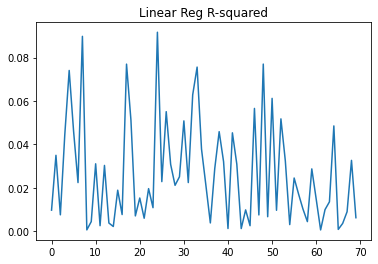

In [113]:
cX =  pd.get_dummies(subTypLabsC, drop_first=False).loc[:, ["AD-PCA", "AD-LPA"]]
#cX =  pd.get_dummies(subTypLabsC, drop_first=True)
Rvs = []
pvs = []
fpvs = []
for j in range(cFADstd.shape[-1]):
    cY = cFADstd[:, j]
    #cMd = sm.OLS(cY, cX)
    cMd = sm.OLS(cY, sm.add_constant(cX))
    cMdres = cMd.fit()
    Rvs.append(cMdres.rsquared)
    pvs.append(cMdres.pvalues)
    fpvs.append(cMdres.f_pvalue)
    
Rvs  = np.array(Rvs)
pvs  = np.array(pvs)
fpvs  = np.array(fpvs)
plt.plot(Rvs)
plt.title("Linear Reg R-squared")

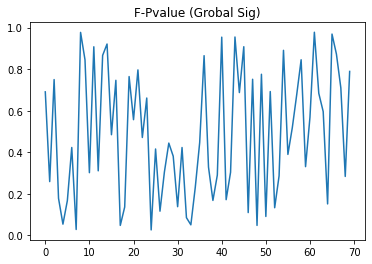

In [117]:
plt.title("F-Pvalue (Grobal Sig)")
plt.plot(fpvs)

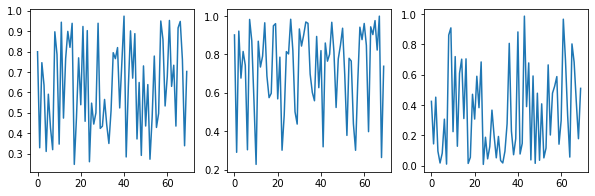

In [118]:
plt.figure(figsize=[10, 3])
plt.subplot(131)
plt.plot(pvs[:, 0])
plt.subplot(132)
plt.plot(pvs[:, 1])
plt.subplot(133)
plt.plot(pvs[:, 2])

In [119]:
# sig variable under pvs
selFs = xlabs[fpvs < 0.05]
selPs = fpvs[fpvs < 0.05]
# for selF in selFs:
#      if selF in xlabs[kpidxId]:
#             print(selF)
preFixSubtype = "_".join(fsName)
fSel = np.zeros(68)
fSel[fpvs[2:] < 0.05] = 1
outFSel = U2BrainVec(reorderU(fSel))
#np.savetxt(f"./brainPlotFils/{preFixSubtype}_SubType_Fsel.txt", outFSel)
print("Overall")
pd.DataFrame([selFs, selPs])

Overall


0                 1              2                       3
0  L-Frontalpole  L-Middletemporal  L-Postcentral  R-Lateralorbitofrontal
1          0.028             0.048          0.026                   0.048

In [120]:
tmpIdx = 0
# sig variable under pvs
selFs = xlabs[pvs[:, tmpIdx] < 0.05]
selPs = pvs[:, tmpIdx][pvs[:, tmpIdx] < 0.05]
# for selF in selFs:
#      if selF in xlabs[kpidxId]:
#             print(selF)
lpaSel = np.zeros(68)
lpaSel[pvs[2:, tmpIdx] < 0.05] = 1
outLPASel = U2BrainVec(reorderU(lpaSel))
#np.savetxt(f"./brainPlotFils/{preFixSubtype}_SubType_LPAsel.txt", outLPASel)

print("Intercept")
pd.DataFrame([selFs, selPs])

Intercept


Empty DataFrame
Columns: []
Index: [0, 1]

In [121]:
tmpIdx = 1
# sig variable under pvs
selFs = xlabs[pvs[:, tmpIdx] < 0.05]
selPs = pvs[:, tmpIdx][pvs[:, tmpIdx] < 0.05]
# for selF in selFs:
#      if selF in xlabs[kpidxId]:
#             print(selF)
print(cX.columns[tmpIdx-1])
pd.DataFrame([selFs, selPs])

AD-PCA


Empty DataFrame
Columns: []
Index: [0, 1]

In [122]:
tmpIdx = 2
# sig variable under pvs
selFs = xlabs[pvs[:, tmpIdx] < 0.05]
selPs = pvs[:, tmpIdx][pvs[:, tmpIdx] < 0.05]
# for selF in selFs:
#      if selF in xlabs[kpidxId]:
#             print(selF)
print(cX.columns[tmpIdx-1])
print(pd.DataFrame({"Feature": selFs, "Pvalue": selPs}))

AD-LPA
                  Feature  Pvalue
0   L-Caudalmiddlefrontal   0.017
1           L-Frontalpole   0.009
2        L-Middletemporal   0.014
3           L-Postcentral   0.008
4            L-Precentral   0.044
5      L-Superiortemporal   0.033
6         L-Supramarginal   0.017
7      R-Isthmuscingulate   0.037
8  R-Lateralorbitofrontal   0.014
9   R-Medialorbitofrontal   0.035


### Clustering on subtype (not used)

In [123]:
fsName = ["r", "ncpts", "wUmeanAll"]
cFAD = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
    
    cFAD.append(cfAD)
cFAD = np.concatenate(cFAD, axis=1)
cFAD = cFAD[subTypLabs!="NULL"]
cFADstd = (cFAD- cFAD.mean(axis=0))/cFAD.std(axis=0)


clu = KMeans(n_clusters=3, random_state=0).fit(cFADstd)
#clu= SpectralClustering(n_clusters=3, random_state=0).fit(cFADstd)
elabs =clu.labels_
tlabs = subTypLabsC

conTB = np.array(pd.crosstab(elabs, tlabs))
chi2, pv, _, _ = chi2_contingency(conTB)
pStr = f"The chisq stat is {chi2:.3f}, the pvalue of the test is {pv:.3f}."
print(pStr)
pd.crosstab(elabs, tlabs)

The chisq stat is 5.488, the pvalue of the test is 0.241.


col_0  AD-LPA  AD-MEM  AD-PCA
row_0                        
0          11      46      13
1           2       4       2
2           1       0       0

###  Combine `AD-LPA` and `AD-PCA` (not used)

In [125]:
twoLabs = subTypLabsC.copy()
twoLabs[subTypLabsC!="AD-MEM"] = 0
twoLabs[subTypLabsC=="AD-MEM"] = 1
twoLabs = twoLabs.astype(float)

In [126]:
penalty = "l2"
fsName = ["r", "ncpts", "wUmeanAll"]
cFAD = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
    
    cFAD.append(cfAD)
cFAD = np.concatenate(cFAD, axis=1)
cFAD = cFAD[subTypLabs!="NULL"]
cFADstd = (cFAD- cFAD.mean(axis=0))/cFAD.std(axis=0)
#cFADstd = cFADstd[:, kpidxId]

Text(0, 0.5, 'AUC')

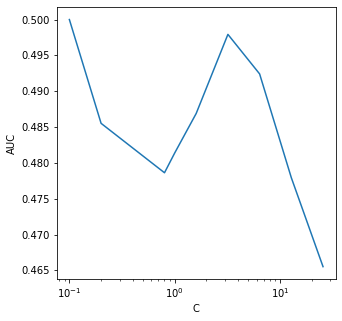

In [127]:
Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4, 12.8, 25.6]
aucCs = []
for C in Cs:
    eProbs = []
    loo = LeaveOneOut()
    for trIdxs, testIdxs in loo.split(cFADstd):
        clf = LogisticRegression(penalty=penalty, random_state=0, C=C)
        clf.fit(cFADstd[trIdxs, :], twoLabs[trIdxs])
        eProbs.append(clf.predict_proba(cFADstd[testIdxs, :]))
    eProbs = np.array(eProbs).squeeze()
    elabs = clf.classes_[eProbs.argmax(axis=1)]
    auc = roc_auc_score(twoLabs, eProbs[:, 1])
    aucCs.append(auc)
    

    
plt.figure(figsize=[5, 5])
plt.plot(Cs, aucCs)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("AUC")

In [128]:
optC = Cs[np.argmax(aucCs)]
eProbs = []
loo = LeaveOneOut()
parass = []
for trIdxs, testIdxs in loo.split(cFADstd):
    clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
    clf.fit(cFADstd[trIdxs, :], twoLabs[trIdxs])
    paras = clf.coef_.reshape(-1)
    parass.append(paras)
    eProbs.append(clf.predict_proba(cFADstd[testIdxs, :]))
eProbs = np.array(eProbs).squeeze()
auc = roc_auc_score(twoLabs, eProbs[:, 1])
fpr, tpr, thresholds = roc_curve(twoLabs, eProbs[:, 1], pos_label=1)
parass = np.array(parass)
print(auc)

0.5


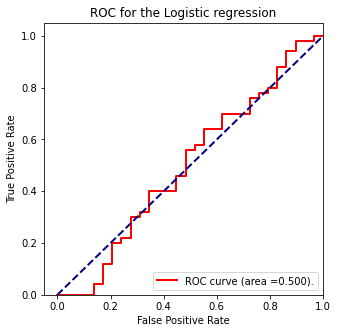

In [129]:
plt.figure(figsize=[5, 5])
plt.plot(fpr, tpr, label=f"ROC curve (area ={auc:.3f}).", lw=2, color="red")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for the Logistic regression")
plt.legend(loc="lower right")

### Subtype vs control

I combined `AD-PCA` and `AD-LPA` together

In [478]:
subTypLabsCom = subTypLabs.copy().astype("<U16")
subTypLabsCom[subTypLabsCom=="AD-PCA"] = "AD-PCA or AD-LPA"
subTypLabsCom[subTypLabsCom=="AD-LPA"] = "AD-PCA or AD-LPA"
pd.value_counts(subTypLabsCom)

AD-MEM              55
AD-PCA or AD-LPA    32
NULL                 1
dtype: int64

In [481]:
# KM 

wUsubLabs = []
flag = 0
curElabs = cluIdxMap[elabsKMused]
for ix in range(len(fsAD)):
    nds = len(fsAD[ix].dwell)
    wUsubLabs = wUsubLabs + [subTypLabsCom[ix]]*nds

cluDFKMsub  = pd.DataFrame({"Dwell": dwellAll, "elabs": curElabs, 
                         "Group":wUsubLabs+["Control"]*len(dwellCtrlAll)})
#cluDFKMsub = cluDFKMsub[cluDFKMsub["Group"]!="NULL"]


 
txtys, txth, txtcol = [62, 62, 62], 1, "k"
txtxdlt = 0.2
ylimUps = np.array(txtys) + 15

for ix, curSubTyp in enumerate(["AD-PCA or AD-LPA", "AD-MEM"]):
    curXticklabsSubKM = []
    curPvsSubKM = []
    for ixx in range(np.max(curElabs)+1):
        curAD = cluDFKMsub[(cluDFKMsub["elabs"]==ixx) & (cluDFKMsub["Group"]==curSubTyp)]
        curCtrl = cluDFKMsub[(cluDFKMsub["elabs"]==ixx) & (cluDFKMsub["Group"]=="Control")]
        restt = scipy.stats.ttest_ind(curAD["Dwell"], curCtrl["Dwell"], equal_var=False)
        pv = restt.pvalue
        curPvsSubKM.append(pv)
        curXticklabsSubKM.append(f"Cluster {ixx+1}")
        #curXticklabsSubKM.append(f"Cluster {ixx+1} \n ({len(curAD)} vs {len(curCtrl)})")
        
        
    plt.figure(figsize=[15, 5], dpi=1200)
    #plt.title("Kmeans")
    sns.boxplot(x="elabs", y="Dwell", hue="Group", data=cluDFKMsub[(cluDFKMsub["Group"]==curSubTyp) |(cluDFKMsub["Group"]=="Control")], 
                showfliers=False, order=list(range(np.max(curElabs)+1)))
           #     showmeans=True,
           # meanprops={"marker":"o",
           #            "markerfacecolor":"white", 
           #            "markeredgecolor":"black",
           #           "markersize":"10"})
    txty = txtys[ix]
    for ixx in range(np.max(curElabs)+1):
        txtx1, txtx2 = ixx-txtxdlt, ixx+txtxdlt
        plt.plot([txtx1, txtx1, txtx2, txtx2], [txty, txty+txth, txty+txth, txty], lw=1.5, c=txtcol)
        plt.text((txtx1+txtx2)*.5, txty+txth+0.5, f"P-value: {curPvsSubKM[ixx]:.3f}", ha='center', va='bottom', color=txtcol)
    plt.xlabel("")
    plt.ylabel("Dwell times", fontsize=20)
    plt.legend(loc="upper left")
    #plt.ylim([-10, ylimUps[ix]+20])
    plt.ylim([0, ylimUps[ix]])
    _ = plt.xticks(np.arange(np.max(curElabs)+1), np.array(curXticklabsSubKM), fontsize=20)
    plt.savefig(f"./plots/boxplot_wUKmeans_{nclu}_{curSubTyp}NoOrder.jpg", bbox_inches='tight')    
    #plt.savefig(f"./plots/boxplot_wUKmeans_{nclu}_{curSubTyp}.jpg", bbox_inches='tight')    

In [490]:
cluDFKMsub[cluDFKMsub["elabs"]==2].groupby("Group").describe()

Dwell                                                    \
                     count      mean       std       min       25%       50%   
Group                                                                          
AD-MEM           8.600e+01 1.481e+01 1.505e+01 2.667e+00 5.000e+00 8.383e+00   
AD-PCA or AD-LPA 3.600e+01 2.331e+01 2.363e+01 2.650e+00 4.856e+00 8.092e+00   
Control          1.620e+02 1.403e+01 1.523e+01 1.733e+00 5.294e+00 8.117e+00   
NULL             5.000e+00 1.200e+01 9.089e+00 3.542e+00 6.458e+00 8.233e+00   

                                         elabs                                \
                       75%       max     count      mean       std       min   
Group                                                                          
AD-MEM           1.704e+01 6.000e+01 8.600e+01 2.000e+00 0.000e+00 2.000e+00   
AD-PCA or AD-LPA 5.287e+01 6.000e+01 3.600e+01 2.000e+00 0.000e+00 2.000e+00   
Control          1.493e+01 6.000e+01 1.620e+02 2.000e+00 0.000e+00 2.000e+00   
NULL             1.558e+01 2.618e+01 5.000e+00 2.000e+00 0.000e+00 2.000e+00   

                                                          
                       25%       50%       75%       max  
Group                                                     
AD-MEM           2.000e+00 2.000e+00 2.000e+00 2.000e+00  
AD-PCA or AD-LPA 2.000e+00 2.000e+00 2.000e+00 2.000e+00  
Control          2.000e+00 2.000e+00 2.000e+00 2.000e+00  
NULL             2.000e+00 2.000e+00 2.000e+00 2.000e+00

In [182]:
cluDFKMsub.to_csv("./results/subtype_dwell_cluNoOrder.csv", index=False)

In [444]:
penalty = "l2"
fsName = ["r", "ncpts", "absEigValMean", "wUmeanAll"]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)

XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)

In [445]:
# Standardize after choose X
np.random.seed(0)
for cSubTyp in ["AD-MEM", "Other"]:
    print(cSubTyp)
    cYs = np.concatenate([np.ones(np.sum(subTypLabsCom==cSubTyp)), np.zeros(len(fsCtrl))])
    cXsAD = Xs[:len(fsAD), :][subTypLabsCom==cSubTyp, :]
    cXsCtrl = Xs[len(fsAD):, :]
    cXs = np.concatenate([cXsAD, cXsCtrl], axis=0)
    cStdXs = (cXs - cXs.mean(axis=0))/cXs.std(axis=0)
    
    
    Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4]
    
    eProbs = []
    loo = LeaveOneOut()
    with tqdm(total=len(cYs)) as t:
        for trIdxs, testIdxs in loo.split(cStdXs):
            curCStdXs, curCYs = cStdXs[trIdxs, :], cYs[trIdxs]
            #curOptC = TuningCFn(curCStdXs, curCYs, Cs)["optC"]
            clf = LogisticRegression(penalty=penalty, random_state=0, C=gOptC)
            clf.fit(curCStdXs, curCYs)
            eProbs.append(clf.predict_proba(cStdXs[testIdxs, :]))
            t.update()
    eProbs = np.array(eProbs).squeeze()
    auc = roc_auc_score(cYs, eProbs[:, 1])
    fpr, tpr, thresholds = roc_curve(cYs, eProbs[:, 1], pos_label=1)
    print(auc)
    
    repTime = 10000
    cParassBoot = []
    for i in tqdm(range(repTime)):
        bootIdx = np.random.choice(len(cYs), len(cYs))
        YsBoot = cYs[bootIdx]
        stdXsBoot = cStdXs[bootIdx]
        clf = LogisticRegression(penalty=penalty, random_state=0, C=gOptC)
        clf.fit(stdXsBoot, YsBoot)
        parasBoot = clf.coef_.reshape(-1)
        cParassBoot.append(parasBoot)
        
    cParassBoot = np.array(cParassBoot)
    
    curClfFinal = LogisticRegression(penalty=penalty, random_state=0, C=gOptC)
    curClfFinal.fit(cStdXs, cYs)
    curCoefsFinal = curClfFinal.coef_.reshape(-1)
    
    
    lows, ups = curCoefsFinal - 1.96*cParassBoot.std(axis=0), curCoefsFinal + 1.96*cParassBoot.std(axis=0)
    #lows, ups = np.quantile(cParassBoot[:, :], [0.025, 0.975], axis=0)
    cKpidxBoot = np.bitwise_or(lows >0,  ups < 0)
    cKpidxIdBoot = np.where(cKpidxBoot)[0]
    #print(", ".join(xlabs[cKpidxBoot]))
    curTestStatsBoot = curCoefsFinal/cParassBoot.std(axis=0)
    normRV = norm()
    # to be consistent, I think we should use two-sided pvalue
    curBootPvs = 2*(1-normRV.cdf(np.abs(curTestStatsBoot)))
    
    resDic = {
       "Feature" : xlabs,  
        "Parameters": curCoefsFinal,
        "Lower": lows,
        "Upper": ups,
        "Pvalues": curBootPvs
    }
    pd.set_option("display.precision", 3)
    curResDF = pd.DataFrame(resDic)
    print(curResDF)
    curResDF.to_csv(f"./results/{preFix}_subtype_regRes_{cSubTyp}.csv", index=False)
    
    outVecs = np.array([f"{xlabs[ix]} ({curBootPvs[ix]:0.3E})" for ix in range(len(xlabs))])
    print(", ".join(outVecs[cKpidxBoot]))
    
    # The selected ROIs by after selection, by CI
    selVec = (cKpidxBoot[3:]).astype(np.int)
    outSelVec = U2BrainVec(reorderU(selVec))
    np.savetxt(f"./brainPlotFils/{preFix}_{cSubTyp}_SelVecBoot.txt", outSelVec)
    pd.DataFrame({"Name": regionNames, "Vec": selVec}).to_csv(f"./brainPlotFils/{preFix}_{cSubTyp}_SelVecBoot.csv", index=False)
    
    # Estimate parameters
    #outSelVec = U2BrainVec(reorderU(minmax2(curCoefsFinal[3:])))
    #np.savetxt(f"./brainPlotFils/{preFix}_{cSubTyp}_OParas.txt", outSelVec)
    #pd.DataFrame({"Name": regionNames, "Vec": minmax2(curCoefsFinal[3:])}).to_csv(f"./brainPlotFils/{preFix}_{cSubTyp}_OParas.csv", index=False)
    
    ## Estimate parameters by two hesispheres
    #outSelVec = U2BrainVec(reorderU(halfMinmax(np.abs(curCoefsFinal[3:]))))
    #np.savetxt(f"./brainPlotFils/{preFix}_{cSubTyp}_ParasHalf.txt", outSelVec)
    #pd.DataFrame({"Name": regionNames, "Vec": halfMinmax(np.abs(curCoefsFinal[3:]))}).to_csv(f"./brainPlotFils/{preFix}_{cSubTyp}_ParasHalf.csv", index=False)
    
    curNLogPvs = -np.log10(curBootPvs[3:])
    curNLogPvs[curNLogPvs < -np.log10(0.05)] = 0
    outSelVec = U2BrainVec(reorderU(curNLogPvs))
    np.savetxt(f"./brainPlotFils/{preFix}_{cSubTyp}_NLogPvsBoot.txt", outSelVec)
    pd.DataFrame({"Name": regionNames, "Vec": curNLogPvs}).to_csv(f"./brainPlotFils/{preFix}_{cSubTyp}_NLogPvsBoot.csv", index=False)

    curParaVec = minmax2(curCoefsFinal[3:])
    curParaVec[curNLogPvs < -np.log10(0.05)] = 0
    print(np.sum(curParaVec==0), np.sum(curNLogPvs < -np.log10(0.05)))
    outSelVec = U2BrainVec(reorderU(curParaVec))
    np.savetxt(f"./brainPlotFils/{preFix}_{cSubTyp}_OPParas.txt", outSelVec)
    pd.DataFrame({"Name": regionNames, "Vec": curParaVec}).to_csv(f"./brainPlotFils/{preFix}_{cSubTyp}_OPParas.csv", index=False)
    

  0%|          | 0/10000 [00:00<?, ?it/s]

AD-MEM
0.7433884297520661


100%|██████████| 10000/10000 [00:11<00:00, 863.70it/s]


                      Feature  Parameters  Lower  Upper  Pvalues
0                        Rank       1.011  0.493  1.529    0.000
1                 Num of cpts      -0.343 -0.672 -0.014    0.041
2                      Lambda       0.503  0.050  0.957    0.030
3                  L-Bankssts      -0.206 -0.507  0.095    0.179
4   L-Caudalanteriorcingulate       0.030 -0.317  0.376    0.867
..                        ...         ...    ...    ...      ...
66         R-Superiorparietal      -0.168 -0.547  0.211    0.385
67         R-Superiortemporal      -0.029 -0.273  0.215    0.814
68            R-Supramarginal       0.205 -0.114  0.523    0.209
69             R-Temporalpole      -0.044 -0.450  0.362    0.831
70       R-Transversetemporal      -0.013 -0.424  0.397    0.949

[71 rows x 5 columns]
Rank (1.309E-04), Num of cpts (4.083E-02), Lambda (2.956E-02), L-Cuneus (2.977E-03), L-Fusiform (3.442E-04), L-Inferiorparietal (3.524E-03), L-Lateraloccipital (1.323E-02), L-Lingual (1.170E-02), L

  0%|          | 0/10000 [00:00<?, ?it/s]

Other
0.762784090909091


100%|██████████| 10000/10000 [00:09<00:00, 1063.89it/s]


                      Feature  Parameters  Lower  Upper  Pvalues
0                        Rank       0.851  0.306  1.395    0.002
1                 Num of cpts      -0.443 -0.920  0.034    0.068
2                      Lambda       0.543  0.264  0.823    0.000
3                  L-Bankssts      -0.014 -0.354  0.326    0.934
4   L-Caudalanteriorcingulate      -0.032 -0.321  0.257    0.830
..                        ...         ...    ...    ...      ...
66         R-Superiorparietal      -0.200 -0.610  0.209    0.338
67         R-Superiortemporal       0.033 -0.293  0.359    0.841
68            R-Supramarginal       0.204 -0.164  0.573    0.277
69             R-Temporalpole       0.065 -0.240  0.371    0.676
70       R-Transversetemporal      -0.077 -0.426  0.272    0.664

[71 rows x 5 columns]
Rank (2.198E-03), Lambda (1.381E-04), L-Fusiform (6.190E-04), L-Inferiortemporal (1.962E-02), L-Lingual (2.819E-03), L-Parahippocampal (2.128E-05), L-Pericalcarine (4.133E-03), L-Precentral (4.963E

In [446]:
pd.value_counts(subTypLabsCom)

AD-MEM    55
Other     32
NULL       1
dtype: int64

In [470]:
subFils = list(resDir.glob("*abs*subtype_regRes*.csv"))
ix = 3
print(subFils[ix])
dat = pd.read_csv(subFils[ix])
pd.set_option('display.float_format',lambda x : '%.3e' % x)
print(dat[dat["Pvalues"]<0.05])
#print(dat)

results/r_ncpts_absEigValMean_wUmeanAll_l2_subtype_regRes_Other.csv
                       Feature  Parameters      Lower      Upper   Pvalues
0                         Rank   8.506e-01  3.061e-01  1.395e+00 2.198e-03
2                       Lambda   5.433e-01  2.639e-01  8.226e-01 1.381e-04
9                   L-Fusiform  -5.559e-01 -8.741e-01 -2.376e-01 6.190e-04
11          L-Inferiortemporal  -3.596e-01 -6.617e-01 -5.756e-02 1.962e-02
16                   L-Lingual  -4.045e-01 -6.699e-01 -1.391e-01 2.819e-03
20           L-Parahippocampal  -5.142e-01 -7.513e-01 -2.771e-01 2.128e-05
24             L-Pericalcarine  -4.472e-01 -7.529e-01 -1.416e-01 4.133e-03
27                L-Precentral   2.880e-01  4.581e-04  5.755e-01 4.963e-02
29  L-Rostralanteriorcingulate   3.680e-01  4.184e-02  6.941e-01 2.700e-02
35              L-Temporalpole   5.362e-01  2.311e-01  8.414e-01 5.725e-04


#### wU Diff between subtype and control

In [137]:
wUlabsSub = []
for subTypLab, fs in zip(subTypLabs, fsAD):
    wUlabsSub.append([subTypLab]*fs.wUAll.shape[-1])
wUlabsSub = np.concatenate(wUlabsSub)

In [138]:
vecCtrlAll = wUAll.T[wUlabs==0, :].mean(axis=0)
for subT in ["AD-MEM", "AD-PCA", "AD-LPA"]:
    curVecSub = wUADAll.T[wUlabsSub==subT, :].mean(axis=0)
    curVecDiffSub = np.abs(curVecSub-vecCtrlAll)
    #curVecDiffSub = np.abs(minmax(curVecSub)-minmax(vecCtrlAll))
    outCurVecDiffSub = U2BrainVec(reorderU(minmax(curVecDiffSub)))
    
    np.savetxt(f"./brainPlotFils/wUDiffSub_{subT}.txt", outCurVecDiffSub)
    pd.DataFrame({"Name": regionNames, "Vec": minmax(curVecDiffSub)}).to_csv(f"./brainPlotFils/wUDiffSub_{subT}.csv", index=False)
    

In [143]:
wUmeanAD = np.array([fs.wUmeanAll for fs in fsAD])
wUmeanCtrl = np.array([fs.wUmeanAll for fs in fsCtrl])
vecCtrlwUmean = wUmeanCtrl.mean(axis=0)
for subT in ["AD-MEM", "AD-PCA", "AD-LPA"]:
    curVecSub = wUmeanAD[subTypLabs==subT, :].mean(axis=0)
    #curVecDiffSub = np.abs(curVecSub-vecCtrlwUmean)
    curVecDiffSub = np.abs(minmax(curVecSub)-minmax(vecCtrlwUmean))
    outCurVecDiffSub = U2BrainVec(reorderU(minmax(curVecDiffSub)))
    
    np.savetxt(f"./brainPlotFils/wUmeanDiffSub_{subT}.txt", outCurVecDiffSub)
    pd.DataFrame({"Name": regionNames, "Vec": minmax(curVecDiffSub)}).to_csv(f"./brainPlotFils/wUmeanDiffSub_{subT}.csv", index=False)
    

#### After projection (I will not use it)

In [156]:
fsName = ["r", "ncpts", "wUmeanAll"]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)
stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

targetMat = stdXs[:, :2]
orgMat = stdXs[:, 2:]
projMat = np.eye(targetMat.shape[0]) -  \
          np.matmul(np.matmul(targetMat, np.linalg.inv(np.matmul(targetMat.T, targetMat))), targetMat.T)
resMat = np.matmul(projMat, orgMat)

projXs = np.concatenate([targetMat, resMat], axis=1)
projStdXs = (projXs - projXs.mean(axis=0))/projXs.std(axis=0)

In [157]:
np.random.seed(0)
for cSubTyp in ["AD-LPA", "AD-MEM", "AD-PCA"]:
    print(cSubTyp)
    cYs = np.concatenate([np.ones(np.sum(subTypLabs==cSubTyp)), np.zeros(len(fsCtrl))])
    cStdXsAD = projStdXs[:len(fsAD), :][subTypLabs==cSubTyp, :]
    cStdXsCtrl = projStdXs[len(fsAD):, :]
    cStdXs = np.concatenate([cStdXsAD, cStdXsCtrl], axis=0)
    
    
    Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4]
    
    eProbs = []
    loo = LeaveOneOut()
    with tqdm(total=len(cYs)) as t:
        for trIdxs, testIdxs in loo.split(cStdXs):
            curCStdXs, curCYs = cStdXs[trIdxs, :], cYs[trIdxs]
            curOptC = TuningCFn(curCStdXs, curCYs, Cs)["optC"]
            clf = LogisticRegression(penalty=penalty, random_state=0, C=curOptC)
            clf.fit(curCStdXs, curCYs)
            eProbs.append(clf.predict_proba(cStdXs[testIdxs, :]))
            t.update()
    eProbs = np.array(eProbs).squeeze()
    auc = roc_auc_score(cYs, eProbs[:, 1])
    fpr, tpr, thresholds = roc_curve(cYs, eProbs[:, 1], pos_label=1)
    print(auc)
    
    repTime = 10000
    cParassBoot = []
    for i in tqdm(range(repTime)):
        bootIdx = np.random.choice(len(cYs), len(cYs))
        YsBoot = cYs[bootIdx]
        stdXsBoot = cStdXs[bootIdx]
        clf = LogisticRegression(penalty=penalty, random_state=0, C=projOptC)
        clf.fit(stdXsBoot, YsBoot)
        parasBoot = clf.coef_.reshape(-1)
        cParassBoot.append(parasBoot)
        
    cParassBoot = np.array(cParassBoot)
    
    curClfFinal = LogisticRegression(penalty=penalty, random_state=0, C=projOptC)
    curClfFinal.fit(cStdXs, cYs)
    curCoefsFinal = curClfFinal.coef_.reshape(-1)
    
    
    lows, ups = curCoefsFinal - 1.96*cParassBoot.std(axis=0), curCoefsFinal + 1.96*cParassBoot.std(axis=0)
    #lows, ups = np.quantile(cParassBoot[:, :], [0.025, 0.975], axis=0)
    cKpidxBoot = np.bitwise_or(lows >0,  ups < 0)
    cKpidxIdBoot = np.where(cKpidxBoot)[0]
    print(", ".join(xlabs[cKpidxBoot]))
    curTestStatsBoot = curCoefsFinal/cParassBoot.std(axis=0)
    normRV = norm()
    # to be consistent, I think we should use two-sided pvalue
    curBootPvs = 2*(1-normRV.cdf(np.abs(curTestStatsBoot)))
    
    resDic = {
       "Feature" : xlabs,  
        "Parameters": curCoefsFinal,
        "Lower": lows,
        "Upper": ups,
        "Pvalues": curBootPvs
    }
    pd.set_option("display.precision", 3)
    curResDF = pd.DataFrame(resDic)
    print(curResDF)
    
    # The selected ROIs by after selection, by CI
    selVec = (cKpidxBoot[2:]).astype(np.int)
    outSelVec = U2BrainVec(reorderU(selVec))
    np.savetxt(f"./brainPlotFils/{preFix}_{cSubTyp}_SelVecBootProj.txt", outSelVec)
    pd.DataFrame({"Name": regionNames, "Vec": selVec}).to_csv(f"./brainPlotFils/{preFix}_{cSubTyp}_SelVecBootProj.csv", index=False)
    
    # Estimate parameters
    outSelVec = U2BrainVec(reorderU(minmax(np.abs(curCoefsFinal[2:]))))
    np.savetxt(f"./brainPlotFils/{preFix}_{cSubTyp}_ParasProj.txt", outSelVec)
    pd.DataFrame({"Name": regionNames, "Vec": minmax(np.abs(curCoefsFinal[2:]))}).to_csv(f"./brainPlotFils/{preFix}_{cSubTyp}_ParasProj.csv", index=False)

  0%|          | 0/84 [00:00<?, ?it/s]

AD-LPA


  1%|          | 120/10000 [00:00<00:08, 1195.55it/s]

0.6775510204081633


100%|██████████| 10000/10000 [00:08<00:00, 1246.23it/s]


Rank, L-Fusiform, L-Lingual, L-Parahippocampal, L-Posteriorcingulate, L-Rostralanteriorcingulate, R-Bankssts, R-Cuneus, R-Frontalpole, R-Inferiorparietal, R-Lingual, R-Pericalcarine, R-Superiorparietal, R-Superiortemporal
                      Feature  Parameters  Lower  Upper  Pvalues
0                        Rank       0.342  0.130  0.554    0.002
1                 Num of cpts      -0.456 -0.915  0.003    0.052
2                  L-Bankssts      -0.014 -0.239  0.211    0.901
3   L-Caudalanteriorcingulate       0.001 -0.239  0.241    0.993
4       L-Caudalmiddlefrontal       0.035 -0.246  0.316    0.807
..                        ...         ...    ...    ...      ...
65         R-Superiorparietal      -0.224 -0.444 -0.004    0.046
66         R-Superiortemporal       0.273  0.011  0.535    0.041
67            R-Supramarginal      -0.148 -0.366  0.069    0.181
68             R-Temporalpole      -0.084 -0.338  0.170    0.517
69       R-Transversetemporal       0.004 -0.304  0.311    0.98

  0%|          | 0/120 [00:00<?, ?it/s]

AD-MEM


  1%|          | 95/10000 [00:00<00:10, 948.32it/s]

0.7662857142857143


100%|██████████| 10000/10000 [00:10<00:00, 993.54it/s]


L-Cuneus, L-Fusiform, L-Inferiorparietal, L-Lateraloccipital, L-Lingual, L-Postcentral, L-Rostralanteriorcingulate, L-Superiortemporal, R-Cuneus, R-Inferiorparietal, R-Inferiortemporal, R-Isthmuscingulate, R-Pericalcarine
                      Feature  Parameters  Lower  Upper  Pvalues
0                        Rank       0.248 -0.012  0.509    0.062
1                 Num of cpts      -0.260 -0.603  0.083    0.138
2                  L-Bankssts      -0.225 -0.541  0.091    0.162
3   L-Caudalanteriorcingulate       0.044 -0.344  0.431    0.825
4       L-Caudalmiddlefrontal       0.068 -0.296  0.432    0.713
..                        ...         ...    ...    ...      ...
65         R-Superiorparietal       0.029 -0.354  0.413    0.880
66         R-Superiortemporal       0.205 -0.071  0.482    0.145
67            R-Supramarginal      -0.008 -0.359  0.344    0.965
68             R-Temporalpole       0.163 -0.182  0.509    0.354
69       R-Transversetemporal      -0.064 -0.518  0.389    0.78

  0%|          | 0/85 [00:00<?, ?it/s]

AD-PCA


  1%|          | 123/10000 [00:00<00:08, 1220.07it/s]

0.6885714285714285


100%|██████████| 10000/10000 [00:07<00:00, 1258.38it/s]


Rank, Num of cpts, L-Cuneus, L-Fusiform, L-Inferiorparietal, L-Lateraloccipital, L-Lingual, L-Parahippocampal, L-Pericalcarine, L-Rostralanteriorcingulate, L-Superiorfrontal, L-Temporalpole, R-Caudalanteriorcingulate, R-Cuneus, R-Inferiorparietal, R-Pericalcarine, R-Rostralmiddlefrontal
                      Feature  Parameters  Lower  Upper    Pvalues
0                        Rank       0.502  0.291  0.713  2.999e-06
1                 Num of cpts      -0.441 -0.844 -0.039  3.174e-02
2                  L-Bankssts      -0.073 -0.315  0.170  5.567e-01
3   L-Caudalanteriorcingulate      -0.064 -0.312  0.184  6.136e-01
4       L-Caudalmiddlefrontal       0.236 -0.046  0.518  1.016e-01
..                        ...         ...    ...    ...        ...
65         R-Superiorparietal      -0.118 -0.494  0.258  5.381e-01
66         R-Superiortemporal       0.061 -0.161  0.282  5.919e-01
67            R-Supramarginal       0.213 -0.084  0.509  1.594e-01
68             R-Temporalpole       0.206 

## Analyze the freq of Xmat after smoothing

In [68]:
ADfreqRaw = loadmat(list(resDir.glob("*ADPower.mat"))[0])["psAD"][0, 0]
CtrlfreqRaw = loadmat(list(resDir.glob("*CtrlPower.mat"))[0])["psCtrl"][0, 0]

In [117]:
freqs = ADfreqRaw[0][0, 0][1].reshape(-1)
ADfreqs = [ADfreq[0, 0][0] for ADfreq in ADfreqRaw]
Ctrlfreqs = [Ctrlfreq[0, 0][0] for Ctrlfreq in CtrlfreqRaw]
ADfreqs = [ADfreq[0, 0][0]/np.sum(ADfreq[0, 0][0], axis=0) for ADfreq in ADfreqRaw]
Ctrlfreqs = [Ctrlfreq[0, 0][0]/np.sum(Ctrlfreq[0, 0][0], axis=0) for Ctrlfreq in CtrlfreqRaw]

In [118]:
ADfreqsAll = np.concatenate(ADfreqs, axis=1)
CtrlfreqsAll = np.concatenate(Ctrlfreqs, axis=1)

In [119]:
ADfreqlows, ADfrequps  = np.quantile(ADfreqsAll[:, :], [0.025, 0.975], axis=1)
ADfreqMean = np.mean(ADfreqsAll, axis=1)
Ctrlfreqlows, Ctrlfrequps  = np.quantile(CtrlfreqsAll[:, :], [0.025, 0.975], axis=1)
CtrlfreqMean = np.mean(CtrlfreqsAll, axis=1)

Text(0.5, 0, 'Frequency (Hz)')

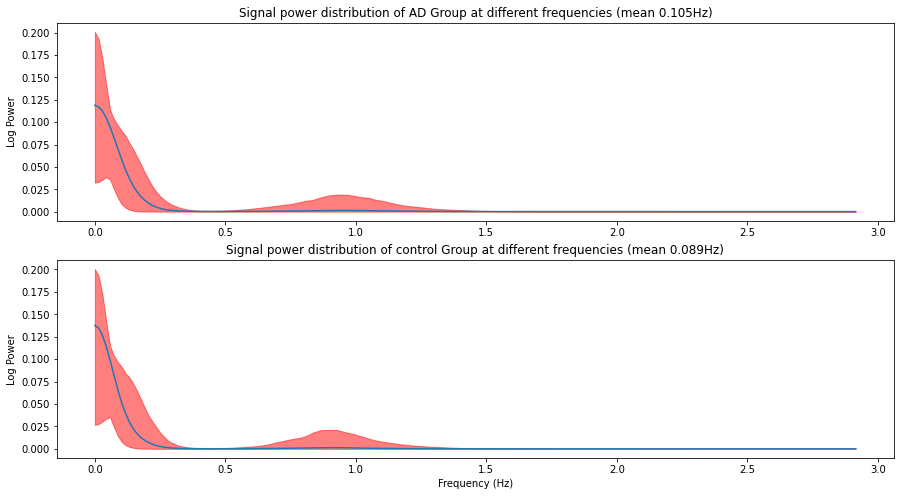

In [134]:
uplim = 200
plt.figure(figsize=[15, 8])
plt.subplot(211)
plt.fill_between(freqs[:uplim], ADfreqlows[:uplim], ADfrequps[:uplim], color="red", alpha=.5)
plt.plot(freqs[:uplim], ADfreqMean[:uplim])
#plt.yscale("log")
plt.title(f"Signal power distribution of AD Group at different frequencies (mean {np.sum(ADfreqMean*freqs):.3f}Hz)")
plt.ylabel("Log Power")
#plt.xlabel("Frequency (Hz)")


plt.subplot(212)
plt.fill_between(freqs[:uplim], Ctrlfreqlows[:uplim], Ctrlfrequps[:uplim], color="red", alpha=.5)
plt.plot(freqs[:uplim], CtrlfreqMean[:uplim])
#plt.yscale("log")
plt.title(f"Signal power distribution of control Group at different frequencies (mean {np.sum(CtrlfreqMean*freqs):.3f}Hz)")
plt.ylabel("Log Power")
plt.xlabel("Frequency (Hz)")
#plt.savefig(f"./plots/{preFix}_penaltySelBoot.jpg", bbox_inches='tight')